# Assignment 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, LLMs, Prompting

Samuele Gasbarro - 0001181115 - samuele.gasbarro@studio.unibo.it

Carmine Santella - 0001167619 - carmine.santella@studio.unibo.it

Tommaso Bernardini - 0001191816 - tommaso.bernardini6@studio.unibo.it

In [1]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()


# Introduction

You are tasked to address the [EDOS Task B](https://github.com/rewire-online/edos) on sexism detection.

## Problem definition

Given an input text sentence, the task is to label the sentence as non-sexist or one of these four sexist categories: (1) threats, (2)  derogation, (3) animosity, (4) prejudiced discussion.

### Examples:

**Text**: *``Schedule a date with her, then don't show up. Then text her "GOTCHA B___H".''*

**Label**: Threats

**Text**: *``That’s completely ridiculous a woman flashing her boobs is not sexual assault in the slightest.''*

**Label**: Not sexist



## Approach

We will tackle the five-class classification task with LLMs.

In particular, we'll consider zero-/few-shot prompting approaches to assess the capability of some popular open-source LLMs on this task.

## Preliminaries

We are going to download LLMs from [Huggingface](https://huggingface.co/).

Many of these open-source LLMs require you to accept their "Community License Agreement" to download them.

In summary:

- If not already, create an account of Huggingface (~2 mins)
- Check a LLM model card page (e.g., [Mistral v3](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3)) and accept its "Community License Agreement".
- Go to your account -> Settings -> Access Tokens -> Create new token -> "Repositories permissions" -> add the LLM model card you want to use.
- Save the token (we'll need it later)

### Huggingface Login

Once we have created an account and an access token, we need to login to Huggingface via code.

- Type your token and press Enter
- You can say No to Github linking

In [2]:
!hf auth login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `hf auth whoami` to get more information or `hf auth logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
The token `ton

After login, you can download all models associated with your access token in addition to those that are not protected by an access token.

### Data Loading

Since we are only interested in prompting, we do not require a train dataset.

We have preparared a small test set version of EDOS in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material).

Check the ``Assignment 2/data`` folder.
It contains:

- ``a2_test.csv`` → a small test set of 300 samples.
- ``demonstrations.csv`` -> a batch of 1000 samples for few-shot prompting.

Both datasets contain a balanced number of sexist and not sexist samples.


### Instructions

We require you to:

* **Download** the ``A2/data`` folder.
* **Encode** ``a2_test.csv`` into a ``pandas.DataFrame`` object.

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

import copy
import hashlib
from typing import List, Dict, Any, Union
import pickle
import re

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
data_path = '/content/drive/MyDrive/AssignmentsNLP/Assignment2/data'

print(os.listdir(data_path))

['a2_test.csv', 'demonstrations.csv']


In [28]:
# Load files
test_df = pd.read_csv(os.path.join(data_path, 'a2_test.csv'))
demonstrations_df = pd.read_csv(os.path.join(data_path, 'demonstrations.csv'))

# Check the shape
print("Test:", test_df.shape)
print("Demonstrations:", demonstrations_df.shape)

# Show the head
test_df.head()

Test: (300, 3)
Demonstrations: (1000, 6)


,rewire_id,text,label_category
0,sexism2022_english-11647,She may be worth what someone paid for her in ...,derogation
1,sexism2022_english-15883,The men who white knight for women eventually ...,prejudiced
2,sexism2022_english-12494,Two thoughts to keep in mind about women and A...,derogation
3,sexism2022_english-26,"Wimmin. No matter how good they have it, they'...",prejudiced
4,sexism2022_english-7475,"So just a few months ago, while Republican wom...",prejudiced


In [29]:
demonstrations_df.head()

,rewire_id,text,label_sexist,label_category,label_vector,split
0,sexism2022_english-7417,female egg donors are allowed to be uggo as fu...,sexist,derogation,2.1 descriptive attacks,train
1,sexism2022_english-10155,My girlfriend is mentally retarded. Or if you ...,sexist,derogation,2.1 descriptive attacks,test
2,sexism2022_english-15154,Lock her UP!!!!,sexist,threats,1.2 incitement and encouragement of harm,train
3,sexism2022_english-13387,So you want to live in a world where women are...,sexist,animosity,"3.1 casual use of gendered slurs, profanities,...",dev
4,sexism2022_english-2990,"Special episode of Loomy Does Politics, by pop...",sexist,prejudiced,4.2 supporting systemic discrimination against...,train


# [Task 1 - 0.5 points] Model setup

Once the test data has been loaded, we have to setup the model pipeline for inference.

In particular, we have to:
- Load the model weights from Huggingface
- Quantize the model to fit into a single-GPU limited hardware

### Instructions

In order to get Task 1 points, we require you to:

* Pick 2 model cards from the provided list.
* For each model:
  - Setup a quantization configuration for the model.
  - Load the model via HuggingFace APIs.


### Note

There's a popular library integrated with Huggingface's ``transformers`` to perform quantization.


In [4]:
!pip install transformers
!pip install datasets
!pip install accelerate -U
!pip install evaluate
!pip install -U bitsandbytes

In [5]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

### Mistral

In [6]:
model_card_mistral = "mistralai/Mistral-7B-Instruct-v0.3" # Model card from hugging face
tokenizer_mistral = AutoTokenizer.from_pretrained(model_card_mistral)
tokenizer_mistral.pad_token = tokenizer_mistral.eos_token # set the padding tokens

# set the terminators
terminators_mistral = [
    tokenizer_mistral.eos_token_id,
    tokenizer_mistral.convert_tokens_to_ids("<|eot_id|>")
]

model_mistral = AutoModelForCausalLM.from_pretrained(
    model_card_mistral,
    quantization_config=bnb_config,
    device_map="auto"
)

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

To speed up the loading of the models, during the testing phase we downloaded the model to the drive and reloaded it from there.

In [ ]:
"""# Define the save path on Drive
save_directory = "/content/drive/MyDrive/AssignmentsNLP/Assignment2/Mistral_Quantized_4bit"

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Save the Tokenizer
tokenizer_mistral.save_pretrained(save_directory)
print(f"Tokenizer salvato in: {save_directory}")

# Save Model
# Note: When saving a quantized model with BitsAndBytes,
# PyTorch only saves the base state, but you must also save the configuration
# and adapter weights (if any).
model_mistral.save_pretrained(save_directory)
print(f"Model saved in: {save_directory}")

# SAVING TERMINATORS AND CONFIGURATIONS (optional but recommended)
# You can save simple lists like terminators_mistral to a JSON or pickle file.
import json
config_path = os.path.join(save_directory, "config_params.json")
with open(config_path, 'w') as f:
    # We only save the ID values
    json.dump({"terminators": terminators_mistral}, f)
print(f"Configuration saved in: {config_path}")"""

In [ ]:
"""load_directory = "/content/drive/MyDrive/AssignmentsNLP/Assignment2/Mistral_Quantized_4bit"

# 1. Load the Tokenizer
tokenizer_mistral = AutoTokenizer.from_pretrained(load_directory)
print("Tokenizer ricaricato con successo.")

tokenizer_mistral.pad_token = tokenizer_mistral.eos_token  # set the padding tokens

# define terminators
terminators_mistral = [
    tokenizer_mistral.eos_token_id,
    tokenizer_mistral.convert_tokens_to_ids("<|eot_id|>")
]

# 2. Load the quantized model (apply bnb_config)
model_mistral = AutoModelForCausalLM.from_pretrained(
    load_directory,
    quantization_config=bnb_config,
    device_map="auto"
)
print("Modello quantizzato ricaricato con successo.")"""

Tokenizer ricaricato con successo.


/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


Modello quantizzato ricaricato con successo.


In [ ]:
print(model_mistral)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32768, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

### Llama

In [ ]:
model_card_llama = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer_llama = AutoTokenizer.from_pretrained(model_card_llama)
tokenizer_llama.pad_token = tokenizer_llama.eos_token
tokenizer_llama.padding_side = "left"  # So that the last token of each sequence in the batch is always a "true" token, and the model can start generating text correctly from that point.

terminators_llama = [
    tokenizer_llama.eos_token_id,
    tokenizer_llama.convert_tokens_to_ids("<|eot_id|>")
]

model_llama = AutoModelForCausalLM.from_pretrained(
    model_card_llama,
    quantization_config=bnb_config,
    device_map="auto"
)

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [ ]:
load_directory = "/content/drive/MyDrive/A2/Llama_Quantized_4bit"
model_card_llama = "meta-llama/Llama-3.1-8B-Instruct"

# Load tokenizer from HuggingFace
tokenizer_llama = AutoTokenizer.from_pretrained(model_card_llama)

# Configure tokenizer
tokenizer_llama.pad_token = tokenizer_llama.eos_token
tokenizer_llama.padding_side = "left"

# Define terminators
terminators_llama = [
    tokenizer_llama.eos_token_id,
    tokenizer_llama.convert_tokens_to_ids("<|eot_id|>")
]

# Load quantized model from local directory
model_llama = AutoModelForCausalLM.from_pretrained(
    load_directory,
    quantization_config=bnb_config,
    device_map="auto"
)

print("Tokenizer e modello caricati con successo.")

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Tokenizer e modello caricati con successo.


In [ ]:
print(model_llama)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRM

### Qwen

In [ ]:
model_card_qwen = "Qwen/Qwen3-1.7B"
tokenizer_qwen = AutoTokenizer.from_pretrained(model_card_qwen)
tokenizer_qwen.pad_token = tokenizer_qwen.eos_token
tokenizer_qwen.padding_side = "left"

terminators_qwen = [
    tokenizer_qwen.eos_token_id,
    tokenizer_qwen.convert_tokens_to_ids("<|eot_id|>")
]

model_qwen = AutoModelForCausalLM.from_pretrained(
    model_card_qwen,
    quantization_config=bnb_config,
    device_map="auto"
)

'model_card_qwen = "Qwen/Qwen3-1.7B"\ntokenizer_qwen = AutoTokenizer.from_pretrained(model_card_qwen)\ntokenizer_qwen.pad_token = tokenizer_qwen.eos_token\ntokenizer_qwen.padding_side = "left"\n\nterminators_qwen = [\n    tokenizer_qwen.eos_token_id,\n    tokenizer_qwen.convert_tokens_to_ids("<|eot_id|>")\n]\n\nmodel_qwen = AutoModelForCausalLM.from_pretrained(\n    model_card_qwen,\n    quantization_config=bnb_config,\n    device_map="auto"\n)'

In [ ]:
load_directory = "/content/drive/MyDrive/A2/Qwen_Quantized_4bit"

# Qwen uses LlamaTokenizer
from transformers import Qwen2Tokenizer

tokenizer_qwen = Qwen2Tokenizer.from_pretrained(load_directory)
print("Tokenizer Qwen2 ricaricato con successo.")

tokenizer_qwen.pad_token = tokenizer_qwen.eos_token
tokenizer_qwen.padding_side = "left"

# Define terminators
terminators_qwen = [
    tokenizer_qwen.eos_token_id,
    tokenizer_qwen.convert_tokens_to_ids("<|eot_id|>")
]

# 2. Load the quantized model
model_qwen = AutoModelForCausalLM.from_pretrained(
    load_directory,
    quantization_config=bnb_config,
    device_map="auto"
)
print("Modello quantizzato ricaricato con successo.")

Tokenizer Qwen2 ricaricato con successo.


/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


Modello quantizzato ricaricato con successo.


In [ ]:
print(model_qwen)

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=6144, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=6144, bias=False)
          (down_proj): Linear4bit(in_features=6144, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen3RMSNorm((2048,), eps=1e-06)
 

# [Task 2 - 1.0 points] Prompt setup

Prompting requires an input pre-processing phase where we convert each input example into a specific instruction prompt.


## Prompt Template

Use the following prompt template to process input texts.

In [ ]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as non-sexist
         or sexist. If sexist, classify input text according to one
         of the following four categories: threats, derogation,
         animosity, prejudiced discussion.

         Below you find sexist categories definitions:
         Threats: the text expresses intent or desire to harm a woman.
         Derogation: the text describes a woman in a derogative manner.
         Animosity: the text contains slurs or insults towards a woman.
         Prejudiced discussion: the text expresses supports for
         mistreatment of women as individuals.

         Respond only by writing one of the following categories:
         non-sexist, threats, derogation, animosity, prejudiced.

        TEXT: {text}

        ANSWER:
        """
    }
]

### Instructions

In order to get Task 2 points, we require you to:

* Write a ``prepare_prompts`` function as the one reported below.

In [8]:
def prepare_prompts(texts, prompt_template, tokenizer):
    """
      This function format input text samples into instructions prompts.

      Inputs:
        texts: input texts to classify via prompting
        prompt_template: the prompt template provided in this assignment
        tokenizer: the transformers Tokenizer object instance associated
        with the chosen model card

      Outputs:
        input texts to classify in the form of instruction prompts
    """
    formatted_prompts = []

    # 1. Check once if this is a Qwen tokenizer
    is_qwen_tokenizer = hasattr(tokenizer, 'chat_template') and \
                        tokenizer.chat_template and \
                        'think' in str(tokenizer.chat_template)

    # 2. Prepare generation kwargs once
    generation_kwargs = {
        'tokenize': False,
        'add_generation_prompt': True
    }
    if is_qwen_tokenizer:
        generation_kwargs['enable_thinking'] = False

    # 3. Cache the user content template
    user_content_template = prompt_template[1]['content']

    for text in texts:
        # Create a shallow copy and only modify the user message
        current_prompt = [
            prompt_template[0],  # system message (unchanged)
            {'role': 'user', 'content': user_content_template.format(text=text)}
        ]

        try:
            formatted_string = tokenizer.apply_chat_template(
                current_prompt,
                **generation_kwargs
            )
            formatted_prompts.append(formatted_string)
        except Exception as e:
            print(f"Warning: Failed to format text: {text[:50]}... Error: {e}")
            # Optionally append a None or skip
            formatted_prompts.append(None)

    return formatted_prompts

In [30]:
data_test = test_df

In [31]:
# Extract only the texts for the function
texts_to_classify = data_test['text'].tolist()
print(f"Input texts: {texts_to_classify}")

Input texts: ['She may be worth what someone paid for her in terms of stimulating walking away.', "The men who white knight for women eventually get burned themselves. It's important for men to recognize that you do yourself no favors by patronizing women and their state pimp. Recent high profile false rape accusations prove this.", "Two thoughts to keep in mind about women and AA. 1) Show me a hot girl and I'll show you a man sick of all her bullshit. 2) She has messy diarrhea and loud farts just like the rest of us.", "Wimmin. No matter how good they have it, they'll still find something to bitch about. Like....how is 'rape culture' in the west a thing to complain about, when women are treated worse than cattle in the 3rd world?", 'So just a few months ago, while Republican women were accused of being forced to vote their husbands choice. Now, we know for certain, white Democrat men are being forced to vote their wives choice... or else! #VoteYourValues #KeepAmericaGreat', 'I don\'t 

### Mistral

In [ ]:
# Task 2
prompts_mistral = prepare_prompts(
    texts=texts_to_classify,
    prompt_template=prompt,
    tokenizer=tokenizer_mistral
)

### Llama

In [ ]:
#Task 2
prompts_llama = prepare_prompts(
    texts=texts_to_classify,
    prompt_template=prompt,
    tokenizer=tokenizer_llama
)

### Qwen

In [ ]:
# Task 2
prompts_qwen = prepare_prompts(
    texts=texts_to_classify,
    prompt_template=prompt,
    tokenizer=tokenizer_qwen
)

### Notes

1. You are free to modify the prompt format (**not its content**) as you like depending on your code implementation.

2. Note that the provided prompt has placeholders. You need to format the string to replace placeholders. Huggingface might have dedicated APIs for this.

# [Task 3 - 1.0 points] Inference

We are now ready to define the inference loop where we prompt the model with each pre-processed sample.

### Instructions

In order to get Task 3 points, we require you to:

* Write a ``generate_responses`` function as the one reported below.
* Write a ``process_response`` function as the one reported below.

In [ ]:
def generate_responses(model, prompt_examples, tokenizer, batch_size=8):
    """
      This function implements the inference loop for a LLM model.
      Given a set of examples, the model is tasked to generate
      a response.

      Inputs:
        model: LLM model instance for prompting
        prompt_examples: pre-processed text samples
        tokenizer: the corresponding Tokenizer instance (required for tokenization)
        batch_size: how many samples to process at once

      Outputs:
        generated responses
    """
    generated_texts = []

    model.eval() # inference and not training

    # Iterate over prompts in batches to speed up inference
    for i in range(0, len(prompt_examples), batch_size):
        batch = prompt_examples[i:i + batch_size]

        # 1. Tokenization
        # Convert the batch of prompt strings into token IDs.
        # Padding ensures all sequences have the same length.
        inputs = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=2048  # Add explicit max length for safety
        ).to(model.device)

        # 2. Generation settings
        generation_config = {
            "max_new_tokens": 20,          # Response expected to be short
            "do_sample": False,           # Greedy decoding for deterministic outputs
            "pad_token_id": tokenizer.pad_token_id,
            "eos_token_id": tokenizer.eos_token_id,
            "top_p": None,
        }

        # 3. Model inference
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                **generation_config
            )

        # 3. Decode model outputs
        # Each output contains:
        # [input prompt tokens] + [generated tokens]

        for i, output_sequence in enumerate(outputs):
            # Identify how many tokens correspond to the input prompt
            start_index = inputs['input_ids'][i].shape[0]
            # Slice out only the generated continuation
            generated_sequence = output_sequence[start_index:]

            # Convert token IDs back into a readable string
            decoded_text = tokenizer.decode(
                generated_sequence,
                skip_special_tokens=True
            ).strip()

            generated_texts.append(decoded_text)

    return generated_texts


In [ ]:
def process_response(response):
    """
      This function takes a textual response generated by the LLM
      and processes it to map the response to a binary label.

      Inputs:
        response: generated response from LLM

      Outputs:
        parsed classification response.
        Use the following mapping:
        {
          'not-sexist': 0,
          'threats': 1,
          'derogation': 2,
          'animosity': 3,
          'prejudiced': 4
        }
    """

    # Mapping
    LABEL_MAPPING = {
        'non-sexist': 0,
        'threats': 1,
        'derogation': 2,
        'animosity': 3,
        'prejudiced': 4
    }

    # 1. Clean the model output
    # Remove whitespace, line breaks, extra spaces.
    cleaned_response = response.strip().lower()

    # 2 Convert the cleaned text into a numeric class ID
    for category_key, category_id in LABEL_MAPPING.items():
        if category_key in cleaned_response:
            return category_id

    return -1 # Default value for "Non Parsable"


#### Mistral

In [ ]:
raw_responses_mistral = generate_responses(model_mistral, prompts_mistral, tokenizer_mistral)
print("\nOutput of generate_responses ('Raw' Model Responses)\n")
print(raw_responses_mistral)
print("---")


Output of generate_responses ('Raw' Model Responses)

['animosity', 'animosity', 'animosity', 'animosity', 'prejudiced', 'prejudiced', 'animosity', 'prejudiced', 'animosity', 'non-sexist', 'animosity', 'animosity', 'prejudiced discussion', 'animosity', 'animosity', 'animosity', 'derogation', 'animosity', 'prejudiced', 'prejudiced', 'threats', 'animosity', 'animosity', 'animosity', 'derogation', 'non-sexist', 'animosity', 'animosity', 'animosity', 'animosity', 'prejudiced', 'animosity', 'prejudiced discussion', 'animosity', 'non-sexist', 'animosity', 'prejudiced', 'threats', 'animosity', 'threats', 'non-sexist', 'derogation', 'prejudiced', 'non-sexist', 'animosity', 'animosity', 'animosity', 'non-sexist', 'derogation', 'prejudiced', 'non-sexist', 'non-sexist', 'animosity', 'animosity', 'animosity', 'animosity', 'animosity', 'non-sexist', 'non-sexist', 'animosity (for the third statement)', 'animosity', 'animosity', 'animosity', 'prejudiced', 'non-sexist', 'animosity', 'derogation', 'an

In [ ]:
parsed_responses_mistral = [process_response(r) for r in raw_responses_mistral]
print("\nOutput of process_response (Parsed Answers)\n")
print(parsed_responses_mistral)


Output of process_response (Parsed Answers)

[3, 3, 3, 3, 4, 4, 3, 4, 3, 0, 3, 3, 4, 3, 3, 3, 2, 3, 4, 4, 1, 3, 3, 3, 2, 0, 3, 3, 3, 3, 4, 3, 4, 3, 0, 3, 4, 1, 3, 1, 0, 2, 4, 0, 3, 3, 3, 0, 2, 4, 0, 0, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 4, 0, 3, 2, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 4, 3, 3, 2, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 2, 0, 2, 3, 3, 3, 3, 3, 4, 3, 3, 4, 2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 1, 3, 3, 3, 3, 2, 4, 3, 3, 3, 4, 4, 3, 4, 3, 3, 2, 0, 3, 3, 2, 4, 4, 3, 2, 4, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 3, 2, 3, 3, 3, 3, 2, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 4, 3, 3, 2, 2, 1, 2, 3, 3, 4, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 2, 2, 4, 2, 1, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 4, 2, 1, 3, 3, 3, 4, 3, 2, 3, 3, 2, 2, 3, 3, 4, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 1, 4, 4, 1, 3, 3, 3, 2, 3, 3, 3]


#### Llama

In [ ]:
raw_responses_llama = generate_responses(model_llama, prompts_llama, tokenizer_llama)
print("\nOutput of generate_responses ('Raw' Model Responses)\n")
print(raw_responses_llama)
print("---")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Output of generate_responses ('Raw' Model Responses)

['derogation', 'prejudiced', 'animosity', 'prejudiced', 'prejudiced', 'prejudiced', 'animosity', 'prejudiced', 'derogation', 'non-sexist', 'derogation', 'animosity', 'prejudiced', 'derogation', 'derogation', 'derogation', 'animosity', 'derogation', 'derogation', 'prejudiced', 'threats', 'animosity', 'prejudiced', 'animosity', 'derogation', 'non-sexist', 'derogation', 'derogation', 'I cannot annotate text that contains hate speech. Is there anything else I can help you with?', 'animosity', 'non-sexist', 'animosity', 'prejudiced', 'prejudiced', 'non-sexist', 'derogation', 'prejudiced', 'prejudiced', 'I cannot annotate text that contains hate speech. Is there anything else I can help you with?', 'prejudiced', 'non-sexist', 'animosity', 'prejudiced', 'non-sexist', 'threats', 'derogation', 'animosity', 'non-sexist', 'derogation', 'prejudiced', 'non-sexist', 'non-sexist', 'prejudiced', 'prejudiced', 'non-sexist', 'animosity', 'derogation

In [ ]:
parsed_responses_llama = [process_response(r) for r in raw_responses_llama]
print("\nOutput of process_response (Parsed Answers)\n")
print(parsed_responses_llama)


Output of process_response (Parsed Answers)

[2, 4, 3, 4, 4, 4, 3, 4, 2, 0, 2, 3, 4, 2, 2, 2, 3, 2, 2, 4, 1, 3, 4, 3, 2, 0, 2, 2, -1, 3, 0, 3, 4, 4, 0, 2, 4, 4, -1, 4, 0, 3, 4, 0, 1, 2, 3, 0, 2, 4, 0, 0, 4, 4, 0, 3, 2, 0, 0, 2, 3, 2, 3, 2, 0, 4, 3, 2, 4, 3, 4, 2, 2, 0, 0, -1, 3, 2, 3, -1, 3, 1, 4, 4, 4, 3, 2, 2, 0, 4, 3, 1, -1, 4, 3, 3, 3, 3, 4, 4, 2, 3, 2, -1, 2, 2, 0, 3, 2, -1, 4, 2, 2, 2, 3, 4, 4, 0, 3, 2, 2, 4, 1, 2, 3, 2, 3, 3, -1, 1, 3, 2, 3, 1, 3, 4, 1, 2, 3, 2, 4, 2, 4, 3, -1, 0, 0, 1, 3, 3, 4, 4, 4, 0, 4, 1, 0, 3, 1, 2, 4, 3, 2, 4, 3, 4, 1, 3, 3, 4, 3, 2, 3, 3, 3, 2, 1, 2, 3, 4, 3, 4, 1, 1, 4, 3, 2, 1, 3, 1, 1, 2, 2, 2, 1, 4, 0, 3, 0, 0, 4, 0, 1, 2, 4, 3, 4, 3, -1, 3, 1, 4, 3, 3, 0, 1, -1, 2, 2, 2, 2, 2, 4, 3, 3, 1, 3, 1, 1, 4, 2, 2, 3, -1, 3, 3, 4, 3, 1, 3, 2, 4, 3, 4, 3, 2, 0, 4, 3, -1, 2, 3, 2, 4, 1, 0, 3, 3, 0, 0, 0, 0, 3, 2, 3, 2, 3, 4, -1, 4, 3, 2, 3, -1, 4, 3, 0, 2, 4, 4, 1, 1, 0, 3, 2, 4, 0, 4, -1, 1, 4, 3, 1, 2, -1, 2, 3, 2, 2, 3]


#### Qwen

In [ ]:
raw_responses_qwen = generate_responses(model_qwen, prompts_qwen, tokenizer_qwen)
print("\nOutput of generate_responses ('Raw' Model Responses)\n")
print(raw_responses_qwen)
print("---")


Output of generate_responses ('Raw' Model Responses)

['non-sexist', 'prejudiced', 'derogation', 'derogation', 'prejudiced', 'prejudiced', 'derogation', 'derogation', 'non-sexist', 'non-sexist', 'derogation', 'derogation', 'non-sexist', 'derogation', 'derogation', 'derogation', 'derogation', 'non-sexist', 'derogation', 'derogation', 'derogation', 'non-sexist', 'prejudiced', 'derogation', 'derogation', 'non-sexist', 'derogation', 'derogation', 'prejudiced', 'derogation', 'prejudiced', 'derogation', 'derogation', 'derogation', 'non-sexist', 'derogation', 'non-sexist', 'non-sexist', 'prejudiced', 'derogation', 'non-sexist', 'derogation', 'derogation', 'non-sexist', 'derogation', 'derogation', 'non-sexist', 'derogation', 'derogation', 'prejudiced', 'non-sexist', 'non-sexist', 'derogation', 'derogation', 'derogation', 'derogation', 'derogation', 'non-sexist', 'derogation', 'non-sexist', 'non-sexist', 'prejudiced', 'derogation', 'derogation', 'non-sexist', 'prejudiced', 'non-sexist', 'derog

In [ ]:
parsed_responses_qwen = [process_response(r) for r in raw_responses_qwen]
print("\Output of process_response (Parsed Answers)\n")
print(parsed_responses_qwen)

\Output of process_response (Parsed Answers)

[0, 4, 2, 2, 4, 4, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 4, 2, 2, 0, 2, 2, 4, 2, 4, 2, 2, 2, 0, 2, 0, 0, 4, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 4, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 4, 2, 2, 0, 4, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 4, 2, 4, 2, 2, 0, 4, 0, 2, 2, 4, 0, 2, 2, 2, 4, 2, 0, 2, 2, 2, 2, 4, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 4, 4, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 4, 2, 2, 2, 2, 0, 2, 4, 2, 2, 4, 0, 4, 0, 4, 0, 0, 1, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 4, 2, 4, 2, 2, 2, 2, 4, 2, 0, 2, 4, 2, 0, 4, 0, 2, 4, 2, 2, 2, 4, 1, 0, 1, 2, 2, 2, 2, 4, 2, 2, 2, 2, 0, 2, 2, 4, 2, 0, 2, 2, 2, 2, 4, 4, 2, 0, 2, 2, 0, 2, 4, 4, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 4, 2, 4, 2, 2, 2, 2, 2, 2, 0, 1, 4, 0, 0, 2, 4, 2, 2, 2, 0, 0, 0, 0, 4, 2, 2, 2, 4, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 4, 2, 2, 2, 4, 2, 0, 1, 2, 2, 0, 2, 2, 2, 2]


<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:2: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipython-input-50986336.py:2: SyntaxWarning: invalid escape sequence '\O'
  print("\Output of process_response (Parsed Answers)\n")


# [Task 4 - 0.5 points] Metrics

In order to evaluate selected LLMs, we need to compute performance metrics.

We compute **macro F1-score** and the ratio of failed responses generated by models (**fail-ratio**).

That is, how frequent the LLM fails to follow instructions and provides incorrect responses that do not address the classification task.

In summary, we parse generated responses as follows:
- **0** if 'not-sexist'
- **1** if 'threats'
- **2** if 'derogation'
- **3** if 'animosity'
- **4** if 'prejudiced'
- **0** if the model does not answer in either way

### Instructions

In order to get Task 4 points, we require you to:

* Write a ``compute_metrics`` function as the one reported below.
* Compute metrics for the two selected LLMs.

In [ ]:
def compute_metrics(y_pred_raw, y_true):
    """
      This function takes predicted and ground-truth labels and compute
      metrics. In particular, this function compute accuracy and
      fail-ratio metrics. This function internally invokes
      `process_response` to compute metrics.

      Inputs:
        y_pred_raw: parsed LLM responses
        y_true: ground-truth binary labels

      Outputs:
        dictionary containing desired metrics
    """

    # 1. Fail-Ratio

    # Calculate the number of failures (responses -1 from the process_response function)
    num_failures = y_pred_raw.count(-1)

    # Calculate the total number of predictions
    total_predictions = len(y_pred_raw)

    # Calculate the fail-ratio
    fail_ratio = num_failures / total_predictions if total_predictions > 0 else 0.0

    # 2. Preparation for F1-Score
    # The F1 metric requires all inputs to be valid labels (0, 1, 2, 3, 4).
    # The task specifies: "0 if the model does not answer in either way."
    # Therefore, we convert failures (-1) to 0 (non-sexist) for the F1 calculation.
    y_pred_cleaned = [0 if pred == -1 else pred for pred in y_pred_raw]

    # Convert to NumPy array for sklearn
    y_pred_array = np.array(y_pred_cleaned)
    y_true_array = np.array(y_true)

    # 3. F1-Score
    macro_f1 = f1_score(y_true_array, y_pred_array, average='macro', zero_division=0)

    # 4. Results
    metrics = {
        'macro_f1': macro_f1,
        'fail_ratio': fail_ratio
    }

    return metrics

In [33]:
LABEL_MAP = {
    'not-sexist': 0,
    'threats': 1,
    'derogation': 2,
    'animosity': 3,
    'prejudiced': 4
}

# y_true (textual)
y_true_text = data_test['label_category'].tolist()

# Converting text labels to numeric ones
y_true_numeric = [LABEL_MAP[label] for label in y_true_text]

y_true =  y_true_numeric

#### Mistral

In [ ]:
y_pred_raw_example =  parsed_responses_mistral

print("--- Compute Metrics for Mistral ---")
metrics_m = compute_metrics(y_pred_raw_example, y_true)

print(f"Prediction (y_pred): {y_pred_raw_example}")
print(f"True (y_true): {y_true}")

print(f"\nResults: {metrics_m}")

--- Compute Metrics for Mistral ---
Prediction (y_pred): [3, 3, 3, 3, 4, 4, 3, 4, 3, 0, 3, 3, 4, 3, 3, 3, 2, 3, 4, 4, 1, 3, 3, 3, 2, 0, 3, 3, 3, 3, 4, 3, 4, 3, 0, 3, 4, 1, 3, 1, 0, 2, 4, 0, 3, 3, 3, 0, 2, 4, 0, 0, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 4, 0, 3, 2, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 4, 3, 3, 2, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 2, 0, 2, 3, 3, 3, 3, 3, 4, 3, 3, 4, 2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 1, 3, 3, 3, 3, 2, 4, 3, 3, 3, 4, 4, 3, 4, 3, 3, 2, 0, 3, 3, 2, 4, 4, 3, 2, 4, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 3, 2, 3, 3, 3, 3, 2, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 4, 3, 3, 2, 2, 1, 2, 3, 3, 4, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 2, 2, 4, 2, 1, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 4, 2, 1, 3, 3, 3, 4, 3, 2, 3, 3, 2, 2, 3, 3, 4, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 1, 4, 4, 1, 3, 3, 3, 2, 3, 3, 3]
True (y_true): [2, 4, 2, 4, 4, 4, 3, 4, 3,

To speed up the error analysis we saved the results in local (Google Drive):
- the list of raw respones with the true positive in a dictionary
- the metrics of the model for each number of examples passed (in the case of zero-shot the number of examples is 0)

In [ ]:
results_m = []
all_predictions_m = {}

all_predictions_m["zero_shot"] = {
    "raw": raw_responses_mistral,
    "numeric": parsed_responses_mistral
}
results_m.append({
    "Model": "Mistral",
    "num_examples_per_class": 0, # 0 for Zero-Shot
    "macro_f1": metrics_m["macro_f1"],
    "fail_ratio": metrics_m["fail_ratio"],
})

#### Llama

In [ ]:
y_pred_raw_example =  parsed_responses_llama

print("--- Compute Metrics for Llama ---")
metrics_l = compute_metrics(y_pred_raw_example, y_true)

print(f"Prediction (y_pred): {y_pred_raw_example}")
print(f"True (y_true): {y_true}")

print(f"\nResults: {metrics_l}")

--- Compute Metrics for Llama ---
Prediction (y_pred): [2, 4, 3, 4, 4, 4, 3, 4, 2, 0, 2, 3, 4, 2, 2, 2, 3, 2, 2, 4, 1, 3, 4, 3, 2, 0, 2, 2, -1, 3, 0, 3, 4, 4, 0, 2, 4, 4, -1, 4, 0, 3, 4, 0, 1, 2, 3, 0, 2, 4, 0, 0, 4, 4, 0, 3, 2, 0, 0, 2, 3, 2, 3, 2, 0, 4, 3, 2, 4, 3, 4, 2, 2, 0, 0, -1, 3, 2, 3, -1, 3, 1, 4, 4, 4, 3, 2, 2, 0, 4, 3, 1, -1, 4, 3, 3, 3, 3, 4, 4, 2, 3, 2, -1, 2, 2, 0, 3, 2, -1, 4, 2, 2, 2, 3, 4, 4, 0, 3, 2, 2, 4, 1, 2, 3, 2, 3, 3, -1, 1, 3, 2, 3, 1, 3, 4, 1, 2, 3, 2, 4, 2, 4, 3, -1, 0, 0, 1, 3, 3, 4, 4, 4, 0, 4, 1, 0, 3, 1, 2, 4, 3, 2, 4, 3, 4, 1, 3, 3, 4, 3, 2, 3, 3, 3, 2, 1, 2, 3, 4, 3, 4, 1, 1, 4, 3, 2, 1, 3, 1, 1, 2, 2, 2, 1, 4, 0, 3, 0, 0, 4, 0, 1, 2, 4, 3, 4, 3, -1, 3, 1, 4, 3, 3, 0, 1, -1, 2, 2, 2, 2, 2, 4, 3, 3, 1, 3, 1, 1, 4, 2, 2, 3, -1, 3, 3, 4, 3, 1, 3, 2, 4, 3, 4, 3, 2, 0, 4, 3, -1, 2, 3, 2, 4, 1, 0, 3, 3, 0, 0, 0, 0, 3, 2, 3, 2, 3, 4, -1, 4, 3, 2, 3, -1, 4, 3, 0, 2, 4, 4, 1, 1, 0, 3, 2, 4, 0, 4, -1, 1, 4, 3, 1, 2, -1, 2, 3, 2, 2, 3]
True (y_true): [2, 4, 2, 4,

In [ ]:
results_l = []
all_predictions_l = {}

all_predictions_l["zero_shot"] = {
    "raw": raw_responses_llama,
    "numeric": parsed_responses_llama
}
results_l.append({
    "Model": "Llama",
    "num_examples_per_class": 0, # 0 for Zero-Shot
    "macro_f1": metrics_l["macro_f1"],
    "fail_ratio": metrics_l["fail_ratio"],
})

#### Qwen

In [ ]:
y_pred_raw_example =  parsed_responses_qwen

print("--- Compute Metrics for Qwen ---")
metrics_q = compute_metrics(y_pred_raw_example, y_true)

print(f"Prediction (y_pred): {y_pred_raw_example}")
print(f"True (y_true): {y_true}")

print(f"\nResults: {metrics_q}")

--- Compute Metrics for Qwen ---
Prediction (y_pred): [0, 4, 2, 2, 4, 4, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 4, 2, 2, 0, 2, 2, 4, 2, 4, 2, 2, 2, 0, 2, 0, 0, 4, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 4, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 4, 2, 2, 0, 4, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 4, 2, 4, 2, 2, 0, 4, 0, 2, 2, 4, 0, 2, 2, 2, 4, 2, 0, 2, 2, 2, 2, 4, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 4, 4, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 4, 2, 2, 2, 2, 0, 2, 4, 2, 2, 4, 0, 4, 0, 4, 0, 0, 1, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 4, 2, 4, 2, 2, 2, 2, 4, 2, 0, 2, 4, 2, 0, 4, 0, 2, 4, 2, 2, 2, 4, 1, 0, 1, 2, 2, 2, 2, 4, 2, 2, 2, 2, 0, 2, 2, 4, 2, 0, 2, 2, 2, 2, 4, 4, 2, 0, 2, 2, 0, 2, 4, 4, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 4, 2, 4, 2, 2, 2, 2, 2, 2, 0, 1, 4, 0, 0, 2, 4, 2, 2, 2, 0, 0, 0, 0, 4, 2, 2, 2, 4, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 4, 2, 2, 2, 4, 2, 0, 1, 2, 2, 0, 2, 2, 2, 2]
True (y_true): [2, 4, 2, 4, 4, 4, 3, 4, 3, 0,

In [ ]:
results_q = []
all_predictions_q = {}

all_predictions_q["zero_shot"] = {
    "raw": raw_responses_qwen,
    "numeric": parsed_responses_qwen
}
results_q.append({
    "Model": "Qwen",
    "num_examples_per_class": 0, # 0 for Zero-Shot
    "macro_f1": metrics_q["macro_f1"],
    "fail_ratio": metrics_q["fail_ratio"],
})

# [Task 5 - 1.0 points] Few-shot Inference

So far, we have tested models in a zero-shot fashion: we provide the input text to classify and instruct the model to generate a response.

We are now interested in performing few-shot prompting to see the impact of providing demonstration examples.

To do so, we slightly change the prompt template as follows.

In [ ]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as non-sexist
         or sexist. If sexist, classify input text according to one
         of the following four categories: threats, derogation,
         animosity, prejudiced discussion.

         Below you find sexist categories definitions:
         Threats: the text expresses intent or desire to harm a woman.
         Derogation: the text describes a woman in a derogative manner.
         Animosity: the text contains slurs or insults towards a woman.
         Prejudiced discussion: the text expresses supports for
         mistreatment of women as individuals.

         Respond only by writing one of the following categories:
         non-sexist, threats, derogation, animosity, prejudiced.

        EXAMPLES: {examples}

        TEXT: {text}

        ANSWER:
        """
    }
]

The new prompt template reports some demonstration examples to instruct the model.

Generally, we provide an equal number of demonstrations per class as shown in the example below.

## Instructions

In order to get Task 5 points, we require you to:

- Load ``demonstrations.csv`` and encode it into a ``pandas.DataFrame`` object.
- Define a ``build_few_shot_demonstrations`` function as the one reported below.
- Modify ``prepare_prompts`` to support demonstrations.
- Perform few-shot inference as in Task 3.
- Compute metrics as in Task 4.

In [ ]:
def build_few_shot_demonstrations(
    demonstrations: pd.DataFrame,
    num_per_class: int = 2,
    shuffle: bool = True,
    random_state: Union[int, None] = None
) -> str:
    """

    Inputs:
      demonstrations: DataFrame wrapping demonstrations.csv
      num_per_class: number of demonstrations per class
      shuffle: to extract random examples from the demonstration list
      random_state: seed for reproducibility

    Outputs:
      list of demonstrations to inject into the prompt template.
    """
    demonstrations_list = []

    # 1. Group the dataset by label
    grouped = demonstrations.groupby('label_category') #.replace('not-sexist', 'non-sexist')

    # 2. Process each class independently
    for category, group in grouped:
        if shuffle:
            # Random sampling without replacement.
            # 'min()' ensures we don't ask for more examples than available.
            selected = group.sample(
                n=min(num_per_class, len(group)),
                replace=False,
                random_state=random_state
            )
        else:
            # Simply take the first N examples in the class.
            selected = group.head(num_per_class)

        # Format each sampled example
        for text, label in zip(selected['text'], selected['label_category']):
            # We append a simple demonstration template:
            # TEXT: <text>
            # ANSWER: <label>
            demonstrations_list.append(f"TEXT: {text}\nANSWER: {label}")

    return "\n\n".join(demonstrations_list)

In [ ]:
def prepare_prompts_few_shot(
    texts: List[str],
    prompt_template: List[Dict[str, str]],
    tokenizer: Any,
    demonstrations_df: pd.DataFrame, # Pass full Dataframe
    num_per_class: int = 2,
    shuffle_examples: bool = True,
) -> List[str]:
    """
      This function format input text samples into instructions prompts.

      Inputs:
        texts: input texts to classify via prompting
        prompt_template: the prompt template provided in this assignment
        tokenizer: the transformers Tokenizer object instance associated
        with the chosen model card
        demonstrations_df: DataFrame wrapping demonstrations.csv
        num_per_class: number of demonstrations per class
        shuffle_examples: to extract random examples from the demonstration list

      Outputs:
        input texts to classify in the form of instruction prompts
    """
    formatted_prompts = []

    is_qwen_tokenizer = hasattr(tokenizer, 'chat_template') and \
                        tokenizer.chat_template and \
                        'think' in str(tokenizer.chat_template)

    generation_kwargs = {
        'tokenize': False,
        'add_generation_prompt': True
    }
    if is_qwen_tokenizer:
        generation_kwargs['enable_thinking'] = False

    user_content_base = prompt_template[1]['content']

    # Itera on all texts
    for text in texts:

        # Generate a deterministic random_state for reproducibility
        seed_value = int(hashlib.sha1(text.encode('utf-8')).hexdigest(), 16) % 10**8

       # Generate examples
        demonstrations_string = build_few_shot_demonstrations(
            demonstrations=demonstrations_df,
            num_per_class=num_per_class,
            shuffle=shuffle_examples,
            random_state=seed_value
        )

        # Replace placeholders in template
        user_content = user_content_base.replace('{examples}', demonstrations_string)
        user_content = user_content.replace('{text}', text)

        # Create prompt
        current_prompt = [
            prompt_template[0],  # system message
            {'role': 'user', 'content': user_content}
        ]

        try:
            formatted_string = tokenizer.apply_chat_template(
                current_prompt,
                **generation_kwargs
            )
            formatted_prompts.append(formatted_string)
        except Exception as e:
            print(f"Warning: Failed to format text: {text[:50]}... Error: {e}")
            formatted_prompts.append(None)

    return formatted_prompts


### Mistral

In [ ]:
for i in range(1,5):


  prompts_few_shot = prepare_prompts_few_shot(
      texts=texts_to_classify,
      prompt_template=prompt,
      tokenizer=tokenizer_mistral,
      demonstrations_df=demonstrations_df,
      num_per_class=i
  )

  print(f"Prompt example Few-Shot Mistral with {i} classes of examples:\n{prompts_few_shot[0]}...\n")

  print(f"Prompt example Few-Shot Mistral with {i} classes of examples:\n{prompts_few_shot[1]}...\n")

  print(f"Starting Few-Shot Inference with Mistral with {i} classes of examples")
  y_pred_raw_few_shot_m = generate_responses(
      model=model_mistral,
      prompt_examples=prompts_few_shot,
      tokenizer=tokenizer_mistral,
      batch_size=8
  )
  print("Few-Shot Inference completed.\n")

  y_pred_few_shot_numeric_m = [process_response(r) for r in y_pred_raw_few_shot_m]

  # Save predictions
  all_predictions_m[f"few_shot_{i}"] = {
        "raw": y_pred_raw_few_shot_m,
        "numeric": y_pred_few_shot_numeric_m
    }

  mistral_few_shot_metrics = compute_metrics(y_pred_few_shot_numeric_m, y_true)

  print(f"\n--- Evaluation Mistral Few-Shot with {i} classes of examples ---")
  print(f"Macro F1-Score (Few-Shot): {mistral_few_shot_metrics['macro_f1']:.4f}")
  print(f"Fail Ratio (Few-Shot): {mistral_few_shot_metrics['fail_ratio']:.4f}\n")

  # Save metrics
  results_m.append({
        "Model": "Mistral-7B",
        "num_examples_per_class": i,
        "macro_f1": mistral_few_shot_metrics["macro_f1"],
        "fail_ratio": mistral_few_shot_metrics["fail_ratio"],
    })

Prompt example Few-Shot Mistral with 1 classes of examples:
<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as non-sexist
         or sexist. If sexist, classify input text according to one
         of the following four categories: threats, derogation,
         animosity, prejudiced discussion.

         Below you find sexist categories definitions:
         Threats: the text expresses intent or desire to harm a woman.
         Derogation: the text describes a woman in a derogative manner.
         Animosity: the text contains slurs or insults towards a woman.
         Prejudiced discussion: the text expresses supports for
         mistreatment of women as individuals.

         Respond only by writing one of the following categories:
         non-sexist, threats, derogation, animosity, prejudiced.

        EXAMPLES: TEXT: Can confirm, all women keep a child sized dildo under their bedside table.
ANSWER: animosity

TEXT: The marriage only bene

Resume of the results for the model

In [ ]:
results_df_m = pd.DataFrame(results_m)
print(results_df_m)

        Model  num_examples_per_class  macro_f1  fail_ratio
0     Mistral                       0  0.338598    0.000000
1  Mistral-7B                       1  0.436360    0.003333
2  Mistral-7B                       2  0.504029    0.040000
3  Mistral-7B                       3  0.532298    0.046667
4  Mistral-7B                       4  0.533108    0.050000


Saving the results on Google Drive

In [ ]:
results_df_m.to_csv('/content/drive/MyDrive/AssignmentsNLP/Assignment2/metrics/mistral_metrics.csv', index=False)

In [ ]:
import pickle

with open('/content/drive/MyDrive/AssignmentsNLP/Assignment2/metrics/all_predictions_m.pkl', 'wb') as f:
    pickle.dump(all_predictions_m, f)


### LLama

In [ ]:
for i in range(1,5):


  prompts_few_shot = prepare_prompts_few_shot(
      texts=texts_to_classify,
      prompt_template=prompt,
      tokenizer=tokenizer_llama,
      demonstrations_df=demonstrations_df,
      num_per_class=i
  )

  print(f"Prompt example Few-Shot Llama with {i} classes of examples:\n{prompts_few_shot[0]}...\n")

  print(f"Prompt example Few-Shot Llama with {i} classes of examples:\n{prompts_few_shot[1]}...\n")

  print(f"Starting Few-Shot Inference with Llama with {i} classes of examples")
  y_pred_raw_few_shot_l = generate_responses(
      model=model_llama,
      prompt_examples=prompts_few_shot,
      tokenizer=tokenizer_llama,
      batch_size=8
  )
  print("Few-Shot Inference completed.\n")

  y_pred_few_shot_numeric_l = [process_response(r) for r in y_pred_raw_few_shot_l]

  all_predictions_l[f"few_shot_{i}"] = {
      "raw": y_pred_raw_few_shot_l,
      "numeric": y_pred_few_shot_numeric_l
  }

  llama_few_shot_metrics = compute_metrics(y_pred_few_shot_numeric_l, y_true)

  print(f"\n--- Evaluation Llama Few-Shot with {i} classes of examples ---")
  print(f"Macro F1-Score (Few-Shot): {llama_few_shot_metrics['macro_f1']:.4f}")
  print(f"Fail Ratio (Few-Shot): {llama_few_shot_metrics['fail_ratio']:.4f}\n")

  results_l.append({
        "Model": "Llama",
        "num_examples_per_class": i,
        "macro_f1": llama_few_shot_metrics["macro_f1"],
        "fail_ratio": llama_few_shot_metrics["fail_ratio"],
    })

Prompt example Few-Shot Llama with 1 classes of examples:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as non-sexist
         or sexist. If sexist, classify input text according to one
         of the following four categories: threats, derogation,
         animosity, prejudiced discussion.

         Below you find sexist categories definitions:
         Threats: the text expresses intent or desire to harm a woman.
         Derogation: the text describes a woman in a derogative manner.
         Animosity: the text contains slurs or insults towards a woman.
         Prejudiced discussion: the text expresses supports for
         mistreatment of women as individuals.

         Respond only by writing one of the following categories:
         non-sexist, threats, derogation, animosit

In [ ]:
results_df_l = pd.DataFrame(results_l)
print(results_df_l)

   Model  num_examples_per_class  macro_f1  fail_ratio
0  Llama                       0  0.489064    0.056667
1  Llama                       1  0.400703    0.000000
2  Llama                       2  0.420613    0.033333
3  Llama                       3  0.438917    0.036667
4  Llama                       4  0.445267    0.040000


In [ ]:
results_df_l.to_csv('/content/drive/MyDrive/AssignmentsNLP/Assignment2/metrics/llama_metrics.csv', index=False)

In [ ]:
with open('/content/drive/MyDrive/AssignmentsNLP/Assignment2/metrics/all_predictions_l.pkl', 'wb') as f:
    pickle.dump(all_predictions_l, f)


### Qwen

In [ ]:
for i in range(1,5):


  prompts_few_shot = prepare_prompts_few_shot(
      texts=texts_to_classify,
      prompt_template=prompt,
      tokenizer=tokenizer_qwen,
      demonstrations_df=demonstrations_df,
      num_per_class=i
  )

  print(f"Prompt example Few-Shot Qwen with {i} classes of examples:\n{prompts_few_shot[0]}...\n")

  print(f"Prompt example Few-Shot Qwen with {i} classes of examples:\n{prompts_few_shot[1]}...\n")

  print(f"Starting Few-Shot Inference with Qwen with {i} classes of examples")
  y_pred_raw_few_shot_q = generate_responses(
      model=model_qwen,
      prompt_examples=prompts_few_shot,
      tokenizer=tokenizer_qwen,
      batch_size=8
  )
  print("Few-Shot Inference completed.\n")

  y_pred_few_shot_numeric_q = [process_response(r) for r in y_pred_raw_few_shot_q]

  all_predictions_q[f"few_shot_{i}"] = {
      "raw": y_pred_raw_few_shot_q,
      "numeric": y_pred_few_shot_numeric_q
  }

  qwen_few_shot_metrics = compute_metrics(y_pred_few_shot_numeric_q, y_true)

  print(f"\n--- Evaluation Qwen Few-Shot with {i} classes of examples ---")
  print(f"Macro F1-Score (Few-Shot): {qwen_few_shot_metrics['macro_f1']:.4f}")
  print(f"Fail Ratio (Few-Shot): {qwen_few_shot_metrics['fail_ratio']:.4f}\n")

  results_q.append({
        "Model": "Qwen",
        "num_examples_per_class": i,
        "macro_f1": qwen_few_shot_metrics["macro_f1"],
        "fail_ratio": qwen_few_shot_metrics["fail_ratio"],
    })

Prompt example Few-Shot Qwen with 1 classes of examples:
<|im_start|>system
You are an annotator for sexism detection.<|im_end|>
<|im_start|>user
Your task is to classify input text as non-sexist
         or sexist. If sexist, classify input text according to one
         of the following four categories: threats, derogation,
         animosity, prejudiced discussion.

         Below you find sexist categories definitions:
         Threats: the text expresses intent or desire to harm a woman.
         Derogation: the text describes a woman in a derogative manner.
         Animosity: the text contains slurs or insults towards a woman.
         Prejudiced discussion: the text expresses supports for
         mistreatment of women as individuals.

         Respond only by writing one of the following categories:
         non-sexist, threats, derogation, animosity, prejudiced.

        EXAMPLES: TEXT: Can confirm, all women keep a child sized dildo under their bedside table.
ANSWER: animosi

In [ ]:
results_df_q = pd.DataFrame(results_q)
print(results_df_q)

  Model  num_examples_per_class  macro_f1  fail_ratio
0  Qwen                       0  0.230754    0.000000
1  Qwen                       1  0.319008    0.003333
2  Qwen                       2  0.318274    0.013333
3  Qwen                       3  0.343162    0.013333
4  Qwen                       4  0.335270    0.013333


In [ ]:
results_df_q.to_csv('/content/drive/MyDrive/AssignmentsNLP/Assignment2/metrics/qwen_metrics.csv', index=False)

In [ ]:
with open('/content/drive/MyDrive/AssignmentsNLP/Assignment2/metrics/all_predictions_q.pkl', 'wb') as f:
    pickle.dump(all_predictions_q, f)


# [Task 6 - 1.0 points] Error Analysis

We are now interested in evaluating model responses and comparing their performance.

This analysis helps us in understanding

- Classification task performance gap: are the models good at this task?
- Generation quality: which kind of responses do models generate?
- Errors: which kind of mistakes do models do?

### Instructions

In order to get Task 6 points, we require you to:

* Compare classification performance of selected LLMs in a Table.
* Compute confusion matrices for selected LLMs.
* Briefly summarize your observations on generated responses.

In [14]:
def analyze_errors_from_results(result_dict, label_names=None):
    """
    Analyze errors directly from your results dictionary.

    Inputs:
        result_dict: single result dictionary from your list
        label_names: optional list of label names

    Outputs:
        dictionary with comprehensive error analysis
    """
    if label_names is None:
        label_names = ['non-sexist', 'threats', 'derogation', 'animosity', 'prejudiced']

    # Extract data
    y_true = result_dict['y_true']
    y_pred = result_dict['y_pred_numeric']
    raw_responses = result_dict['y_pred_raw']
    texts = result_dict['text']
    model_name = result_dict['Model']
    num_examples = result_dict['num_examples_per_class']

    # Filter valid predictions
    valid_indices = [i for i, pred in enumerate(y_pred) if pred != -1]

    # Categorize all samples
    errors = []
    correct_predictions = []
    failed_parses = []

    for i in range(len(y_pred)):
        sample_info = {
            'index': i,
            'text': texts[i],
            'true_label': label_names[y_true[i]],
            'true_label_id': y_true[i],
            'predicted_label': label_names[y_pred[i]] if y_pred[i] != -1 else 'UNPARSEABLE',
            'predicted_label_id': y_pred[i],
            'raw_response': raw_responses[i]
        }

        if y_pred[i] == -1:
            # Failed to parse
            failed_parses.append(sample_info)
        elif y_true[i] == y_pred[i]:
            # Correct prediction
            correct_predictions.append(sample_info)
        else:
            # Error
            sample_info['error_type'] = f"{sample_info['true_label']} → {sample_info['predicted_label']}"
            errors.append(sample_info)

    # Categorize error types
    error_type_counts = {}
    for error in errors:
        error_type = error['error_type']
        if error_type not in error_type_counts:
            error_type_counts[error_type] = []
        error_type_counts[error_type].append(error)

    # Binary classification errors
    false_positives = [e for e in errors if e['true_label'] == 'non-sexist']
    false_negatives = [e for e in errors if e['true_label'] != 'non-sexist' and e['predicted_label'] == 'non-sexist']

    # Sexist category confusion (both true and pred are sexist, but wrong category)
    sexist_labels = ['threats', 'derogation', 'animosity', 'prejudiced']
    sexist_confusion = [e for e in errors if e['true_label'] in sexist_labels and e['predicted_label'] in sexist_labels]

    # Build confusion matrix
    y_true_valid = [y_true[i] for i in valid_indices]
    y_pred_valid = [y_pred[i] for i in valid_indices]
    cm = confusion_matrix(y_true_valid, y_pred_valid, labels=list(range(len(label_names))))

    # Package results
    analysis = {
        'model_name': model_name,
        'num_examples_per_class': num_examples,
        'total_samples': len(y_pred),
        'valid_predictions': len(valid_indices),
        'correct_predictions': len(correct_predictions),
        'errors': errors,
        'failed_parses': failed_parses,
        'error_count': len(errors),
        'error_rate': len(errors) / len(valid_indices) if valid_indices else 0,
        'fail_rate': len(failed_parses) / len(y_pred),
        'accuracy': len(correct_predictions) / len(valid_indices) if valid_indices else 0,
        'error_types': error_type_counts,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'sexist_confusion': sexist_confusion,
        'confusion_matrix': cm,
        'label_names': label_names
    }

    return analysis

In [15]:
def show_error_examples(error_analysis, error_type=None, n=5):
    """
    Show specific error examples.

    Inputs:
        error_analysis: result from analyze_errors_from_results
        error_type: specific error type to show (e.g., "non-sexist → threats")
                   or None to show all errors
        n: number of examples to show
    """
    if error_type is None:
        # Show examples from all errors
        errors_to_show = error_analysis['errors'][:n]
        title = "Random Error Examples"
    elif error_type in error_analysis['error_types']:
        # Show specific error type
        errors_to_show = error_analysis['error_types'][error_type][:n]
        title = f"Examples of: {error_type}"
    else:
        print(f"Error type '{error_type}' not found.")
        print(f"Available types: {list(error_analysis['error_types'].keys())}")
        return

    print(f"\n{'='*80}")
    print(f"  {title}")
    print(f"{'='*80}")

    for i, error in enumerate(errors_to_show, 1):
        print(f"\n【Example {i}】")
        print(f"  Text: \"{error['text'][:100]}{'...' if len(error['text']) > 100 else ''}\"")
        print(f"  True label: {error['true_label']}")
        print(f"  Predicted: {error['predicted_label']}")
        print(f"  Raw response: \"{error['raw_response']}\"")

In [16]:
def print_error_summary(error_analysis):
    """
    Print a comprehensive error summary.
    """
    print(f"\n{'='*80}")
    print(f"  ERROR ANALYSIS: {error_analysis['model_name']} "
          f"(examples_per_class={error_analysis['num_examples_per_class']})")
    print(f"{'='*80}")

    # Overall stats
    print(f"\nOverall Statistics:")
    print(f"  Total samples: {error_analysis['total_samples']}")
    print(f"  Valid predictions: {error_analysis['valid_predictions']}")
    print(f"  Correct predictions: {error_analysis['correct_predictions']}")
    print(f"  Errors: {error_analysis['error_count']}")
    print(f"  Failed parses: {len(error_analysis['failed_parses'])}")
    print(f"  Accuracy: {error_analysis['accuracy']:.2%}")
    print(f"  Error rate: {error_analysis['error_rate']:.2%}")
    print(f"  Fail rate: {error_analysis['fail_rate']:.2%}")

    # Error type breakdown
    print(f"\nError Types (Top 10):")
    sorted_errors = sorted(error_analysis['error_types'].items(),
                          key=lambda x: len(x[1]), reverse=True)
    for i, (error_type, examples) in enumerate(sorted_errors[:10], 1):
        percentage = (len(examples) / error_analysis['error_count'] * 100) if error_analysis['error_count'] > 0 else 0
        print(f"  {i:2d}. {error_type:<40} {len(examples):4d} ({percentage:5.1f}%)")

    # Binary classification breakdown
    print(f"\n  Binary Classification Errors:")
    print(f"  False Positives (non-sexist → sexist): {len(error_analysis['false_positives'])}")
    print(f"  False Negatives (sexist → non-sexist): {len(error_analysis['false_negatives'])}")
    print(f"  Sexist Category Confusion: {len(error_analysis['sexist_confusion'])}")

    # Confusion matrix
    print(f"\nConfusion Matrix:")

    cm = error_analysis['confusion_matrix']
    labels = error_analysis['label_names']
    model_name = error_analysis['model_name']

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [17]:
def show_failed_parses(error_analysis, n=10):
    """Show examples of failed parses."""
    print(f"\n{'='*80}")
    print(f"  FAILED PARSE EXAMPLES")
    print(f"{'='*80}")

    failed = error_analysis['failed_parses'][:n]

    if not failed:
        print("  No failed parses!")
        return

    for i, fail in enumerate(failed, 1):
        print(f"\n【Failed Parse {i}】")
        print(f"  Text: \"{fail['text'][:100]}{'...' if len(fail['text']) > 100 else ''}\"")
        print(f"  True label: {fail['true_label']}")
        print(f"  Raw response: \"{fail['raw_response']}\"")

In [18]:
def compare_error_patterns(results_list):

    """
    Compare error patterns across different configurations.

    Inputs:
        results_list: list of result dictionaries
    """

    print(f"\n{'='*80}")
    print(f"  ERROR PATTERN COMPARISON")
    print(f"{'='*80}")

    # Analyze each configuration
    all_analyses = []
    for result in results_list:
        analysis = analyze_errors_from_results(result)
        all_analyses.append(analysis)

    # Compare error rates
    print(f"\nError Rates:")
    print(f"{'Model':<20} {'Examples':<10} {'Error Rate':<12} {'Fail Rate':<12} {'FP':<8} {'FN':<8}")
    print("-" * 80)

    for analysis in all_analyses:
        print(f"{analysis['model_name']:<20} "
              f"{analysis['num_examples_per_class']:<10} "
              f"{analysis['error_rate']:<12.2%} "
              f"{analysis['fail_rate']:<12.2%} "
              f"{len(analysis['false_positives']):<8} "
              f"{len(analysis['false_negatives']):<8}")

    # Find most common error types across all configs
    print(f"\nMost Common Error Types (across all configs):")

    all_error_types = {}

    for analysis in all_analyses:
        for error_type, examples in analysis['error_types'].items():
            if error_type not in all_error_types:
                all_error_types[error_type] = 0
            all_error_types[error_type] += len(examples)

    sorted_all_errors = sorted(all_error_types.items(), key=lambda x: x[1], reverse=True)

    for i, (error_type, count) in enumerate(sorted_all_errors[:10], 1):
        print(f"  {i:2d}. {error_type:<40} {count:4d} occurrences")

    return all_analyses


In [19]:
def comprehensive_error_analysis(results_list, show_examples=True):
    """
    Run comprehensive error analysis on all results.

    Inputs:
        results_list: your list of result dictionaries
        show_examples: whether to show example errors
    """
    print(f"\n{'#'*80}")
    print(f"  COMPREHENSIVE ERROR ANALYSIS")
    print(f"{'#'*80}")

    # Analyze each configuration
    all_analyses = []

    for result in results_list:
        analysis = analyze_errors_from_results(result)
        all_analyses.append(analysis)

        # Print summary for this config
        print_error_summary(analysis)

        if show_examples:
            # Show top error types
            if analysis['error_types']:
                top_error_type = max(analysis['error_types'].items(), key=lambda x: len(x[1]))[0]
                show_error_examples(analysis, error_type=top_error_type, n=3)

            # Show failed parses if any
            if analysis['failed_parses']:
                show_failed_parses(analysis, n=3)

    # Compare patterns across configs
    print(f"\n\n{'#'*80}")
    print(f"  CROSS-CONFIGURATION COMPARISON")
    print(f"{'#'*80}")
    compare_error_patterns(results_list)

    return all_analyses

In [20]:
def evaluate_predictions(y_true, y_pred, label_names=None):
    """
    Comprehensive evaluation of model predictions.

    Inputs:
        y_true: ground truth labels (list of integers)
        y_pred: predicted labels (list of integers)
        label_names: optional list of label names for readability

    Outputs:
        dictionary with all metrics
    """
    if label_names is None:
        label_names = ['non-sexist', 'threats', 'derogation', 'animosity', 'prejudiced']

    # Remove unparseable predictions (-1)
    valid_indices = [i for i, pred in enumerate(y_pred) if pred != -1]
    y_true_valid = [y_true[i] for i in valid_indices]
    y_pred_valid = [y_pred[i] for i in valid_indices]

    # Basic metrics
    accuracy = accuracy_score(y_true_valid, y_pred_valid)

    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true_valid,
        y_pred_valid,
        labels=list(range(len(label_names))),
        zero_division=0
    )

    # Confusion matrix
    cm = confusion_matrix(y_true_valid, y_pred_valid, labels=list(range(len(label_names))))

    # Package results
    results = {
        'accuracy': accuracy,
        'total_samples': len(y_true),
        'valid_predictions': len(y_true_valid),
        'failed_predictions': len(y_true) - len(y_true_valid),
        'per_class_metrics': {
            label_names[i]: {
                'precision': precision[i],
                'recall': recall[i],
                'f1': f1[i],
                'support': support[i]
            }
            for i in range(len(label_names))
        },
        'confusion_matrix': cm,
        'macro_f1': np.mean(f1),
        'weighted_f1': np.average(f1, weights=support)
    }

    return results

def print_evaluation_results(results, model_name="Model"):
    """Pretty print evaluation results."""
    print(f"\n{'='*60}")
    print(f"  {model_name} - Evaluation Results")
    print(f"{'='*60}")

    print(f"\nOverall Performance:")
    print(f"  Accuracy: {results['accuracy']:.4f}")
    print(f"  Macro F1: {results['macro_f1']:.4f}")
    print(f"  Weighted F1: {results['weighted_f1']:.4f}")

    print(f"\nPrediction Statistics:")
    print(f"  Total samples: {results['total_samples']}")
    print(f"  Valid predictions: {results['valid_predictions']}")
    print(f"  Failed predictions: {results['failed_predictions']} ({results['failed_predictions']/results['total_samples']*100:.1f}%)")

    print(f"\nPer-Class Metrics:")
    print(f"{'Category':<20} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Support':<10}")
    print("-" * 66)

    for category, metrics in results['per_class_metrics'].items():
        print(f"{category:<20} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} "
              f"{metrics['f1']:<12.4f} {metrics['support']:<10}")

    print(f"\nConfusion Matrix:")
    cm = results['confusion_matrix']
    labels = results.get('label_names', list(results['per_class_metrics'].keys()))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [21]:
def analyze_generation_quality(raw_responses, predictions, y_true):
    """
    Analyze the quality and patterns of model-generated responses.

    Inputs:
        raw_responses: list of raw text responses from the model
        predictions: list of parsed predictions (integers)
        y_true: ground truth labels

    Outputs:
        dictionary with generation statistics
    """
    label_names = ['non-sexist', 'threats', 'derogation', 'animosity', 'prejudiced']

    # Response length analysis
    response_lengths = [len(resp.split()) for resp in raw_responses]

    # Parsing success analysis
    parsing_success = [pred != -1 for pred in predictions]

    # Verbosity patterns
    verbose_responses = [resp for resp in raw_responses if len(resp.split()) > 5]
    single_word_responses = [resp for resp in raw_responses if len(resp.split()) == 1]

    # Response patterns
    response_patterns = {
        'starts_with_label': 0,
        'contains_explanation': 0,
        'has_punctuation': 0,
        'uppercase': 0,
        'lowercase': 0,
        'mixed_case': 0
    }

    for resp in raw_responses:
        # Check if starts with a label
        first_word = resp.lower().strip().split()[0] if resp.strip() else ''
        if first_word in [label.replace(' ', '') for label in label_names]:
            response_patterns['starts_with_label'] += 1

        # Check for explanations
        if len(resp.split()) > 3:
            response_patterns['contains_explanation'] += 1

        # Check punctuation
        if any(p in resp for p in '.,!?;:'):
            response_patterns['has_punctuation'] += 1

        # Check case
        if resp.isupper():
            response_patterns['uppercase'] += 1
        elif resp.islower():
            response_patterns['lowercase'] += 1
        else:
            response_patterns['mixed_case'] += 1

    results = {
        'avg_response_length': np.mean(response_lengths),
        'median_response_length': np.median(response_lengths),
        'max_response_length': np.max(response_lengths),
        'min_response_length': np.min(response_lengths),
        'parsing_success_rate': sum(parsing_success) / len(parsing_success),
        'num_verbose_responses': len(verbose_responses),
        'num_single_word': len(single_word_responses),
        'response_patterns': response_patterns,
        'sample_verbose_responses': verbose_responses[:5] if verbose_responses else [],
        'sample_failed_parses': [raw_responses[i] for i, pred in enumerate(predictions) if pred == -1][:5]
    }

    return results

def print_generation_analysis(analysis, model_name="Model"):
    """Pretty print generation quality analysis."""
    print(f"\n{'='*60}")
    print(f"  {model_name} - Generation Quality Analysis")
    print(f"{'='*60}")

    print(f"\nResponse Length Statistics:")
    print(f"  Average length: {analysis['avg_response_length']:.2f} words")
    print(f"  Median length: {analysis['median_response_length']:.2f} words")
    print(f"  Range: {analysis['min_response_length']} - {analysis['max_response_length']} words")

    print(f"\nParsing Quality:")
    print(f"  Success rate: {analysis['parsing_success_rate']:.2%}")
    print(f"  Single-word responses: {analysis['num_single_word']}")
    print(f"  Verbose responses (>5 words): {analysis['num_verbose_responses']}")

    print(f"\nResponse Patterns:")
    for pattern, count in analysis['response_patterns'].items():
        percentage = (count / len(analysis['response_patterns'])) * 100
        print(f"  {pattern.replace('_', ' ').title()}: {count}")

    if analysis['sample_verbose_responses']:
        print(f"\nSample Verbose Responses:")
        for i, resp in enumerate(analysis['sample_verbose_responses'][:3], 1):
            print(f"  {i}. \"{resp[:100]}...\"" if len(resp) > 100 else f"  {i}. \"{resp}\"")

    if analysis['sample_failed_parses']:
        print(f"\nSample Failed Parses:")
        for i, resp in enumerate(analysis['sample_failed_parses'][:3], 1):
            print(f"  {i}. \"{resp}\"")

In [22]:
def analyze_errors(y_true, y_pred, raw_responses, texts, label_names=None):
    """
    Detailed error analysis: which mistakes does the model make?

    Inputs:
        y_true: ground truth labels
        y_pred: predicted labels
        raw_responses: raw model responses
        texts: input texts
        label_names: optional label names

    Outputs:
        dictionary with error analysis
    """
    if label_names is None:
        label_names = ['non-sexist', 'threats', 'derogation', 'animosity', 'prejudiced']

    # Find all errors
    errors = []
    for i, (true, pred, resp, text) in enumerate(zip(y_true, y_pred, raw_responses, texts)):
        if pred != -1 and true != pred:  # Valid prediction but wrong
            errors.append({
                'index': i,
                'text': text,
                'true_label': label_names[true],
                'predicted_label': label_names[pred],
                'raw_response': resp,
                'error_type': f"{label_names[true]} → {label_names[pred]}"
            })

    # Categorize errors
    error_types = {}
    for error in errors:
        error_type = error['error_type']
        if error_type not in error_types:
            error_types[error_type] = []
        error_types[error_type].append(error)

    # Common error patterns
    binary_errors = {
        'false_positives': [],  # non-sexist classified as sexist
        'false_negatives': []   # sexist classified as non-sexist
    }

    for error in errors:
        if error['true_label'] == 'non-sexist' and error['predicted_label'] != 'non-sexist':
            binary_errors['false_positives'].append(error)
        elif error['true_label'] != 'non-sexist' and error['predicted_label'] == 'non-sexist':
            binary_errors['false_negatives'].append(error)

    # Sexist category confusion
    sexist_confusion = {}
    sexist_labels = ['threats', 'derogation', 'animosity', 'prejudiced']
    for error in errors:
        if error['true_label'] in sexist_labels and error['predicted_label'] in sexist_labels:
            key = f"{error['true_label']} ↔ {error['predicted_label']}"
            if key not in sexist_confusion:
                sexist_confusion[key] = []
            sexist_confusion[key].append(error)

    results = {
        'total_errors': len(errors),
        'error_rate': len(errors) / len([p for p in y_pred if p != -1]),
        'error_types': error_types,
        'binary_errors': binary_errors,
        'sexist_confusion': sexist_confusion,
        'all_errors': errors
    }

    return results

def print_error_analysis(error_analysis, model_name="Model", top_n=3):
    """Pretty print error analysis."""
    print(f"\n{'='*60}")
    print(f"  {model_name} - Error Analysis")
    print(f"{'='*60}")

    print(f"\nError Statistics:")
    print(f"  Total errors: {error_analysis['total_errors']}")
    print(f"  Error rate: {error_analysis['error_rate']:.2%}")

    print(f"\nMost Common Error Types:")
    sorted_errors = sorted(error_analysis['error_types'].items(),
                          key=lambda x: len(x[1]), reverse=True)
    for error_type, examples in sorted_errors[:5]:
        print(f"  {error_type}: {len(examples)} occurrences")

    print(f"\nBinary Classification Errors:")
    print(f"  False Positives (non-sexist → sexist): {len(error_analysis['binary_errors']['false_positives'])}")
    print(f"  False Negatives (sexist → non-sexist): {len(error_analysis['binary_errors']['false_negatives'])}")

    if error_analysis['sexist_confusion']:
        print(f"\nSexist Category Confusion:")
        for confusion_type, examples in sorted(error_analysis['sexist_confusion'].items(),
                                               key=lambda x: len(x[1]), reverse=True):
            print(f"  {confusion_type}: {len(examples)} occurrences")

    # Show example errors
    print(f"\nSample Errors:")
    for i, error in enumerate(error_analysis['all_errors'][:top_n], 1):
        print(f"\n  Error {i}:")
        print(f"    Text: \"{error['text'][:80]}...\"" if len(error['text']) > 80 else f"    Text: \"{error['text']}\"")
        print(f"    True: {error['true_label']} | Predicted: {error['predicted_label']}")
        print(f"    Response: \"{error['raw_response']}\"")

In [23]:
def comprehensive_evaluation(model_name, texts, y_true, raw_responses, predictions):
    """
    Run complete evaluation pipeline for a model.

    Inputs:
        model_name: name of the model for reporting
        texts: input texts
        y_true: ground truth labels
        raw_responses: raw model responses
        predictions: parsed predictions

    Outputs:
        dictionary with all analysis results
    """
    print(f"\n{'#'*60}")
    print(f"  COMPREHENSIVE EVALUATION: {model_name}")
    print(f"{'#'*60}")

    # 1. Classification metrics
    eval_results = evaluate_predictions(y_true, predictions)
    print_evaluation_results(eval_results, model_name)
    print(f"\n{'-'*80}")

    # 2. Generation quality
    gen_analysis = analyze_generation_quality(raw_responses, predictions, y_true)
    print_generation_analysis(gen_analysis, model_name)
    print(f"\n{'-'*80}")

    # 3. Error analysis
    error_analysis = analyze_errors(y_true, predictions, raw_responses, texts)
    print_error_analysis(error_analysis, model_name, top_n=5)
    print(f"\n{'-'*80}")

    # Package all results
    results = {
        'model_name': model_name,
        'evaluation': eval_results,
        'generation': gen_analysis,
        'errors': error_analysis
    }

    return results

In [25]:
def rebuild_full_structure(model_name, metrics_df, all_predictions, texts, y_true):
    merged_results = []

    for idx, row in metrics_df.iterrows():
        k = row["num_examples_per_class"]

        # chiave usata nel pickle
        if k == 0:
            pred_key = "zero_shot"
        else:
            pred_key = f"few_shot_{k}"

        preds = all_predictions[pred_key]

        merged_results.append({
            "Model": model_name,
            "num_examples_per_class": k,
            "macro_f1": row["macro_f1"],
            "fail_ratio": row["fail_ratio"],

            # aggiungo info necessarie per error analysis
            "y_true": y_true,
            "y_pred_raw": preds["raw"],
            "y_pred_numeric": preds["numeric"],
            "text": texts
        })

    return merged_results


#### Mistral Analysis

Performance Table Mistral (Zero-Shot vs Few-Shot)
        Model  num_examples_per_class  macro_f1  fail_ratio
0     Mistral                       0  0.338682    0.000000
1  Mistral-7B                       1  0.433692    0.003333
2  Mistral-7B                       2  0.509134    0.040000
3  Mistral-7B                       3  0.532298    0.046667
4  Mistral-7B                       4  0.536270    0.050000

################################################################################
  COMPREHENSIVE ERROR ANALYSIS
################################################################################

  ERROR ANALYSIS: Mistral (examples_per_class=0)

Overall Statistics:
  Total samples: 300
  Valid predictions: 300
  Correct predictions: 105
  Errors: 195
  Failed parses: 0
  Accuracy: 35.00%
  Error rate: 65.00%
  Fail rate: 0.00%

Error Types (Top 10):
   1. threats → animosity                        50 ( 25.6%)
   2. derogation → animosity                     49 ( 25.1%)
   3. prejudice

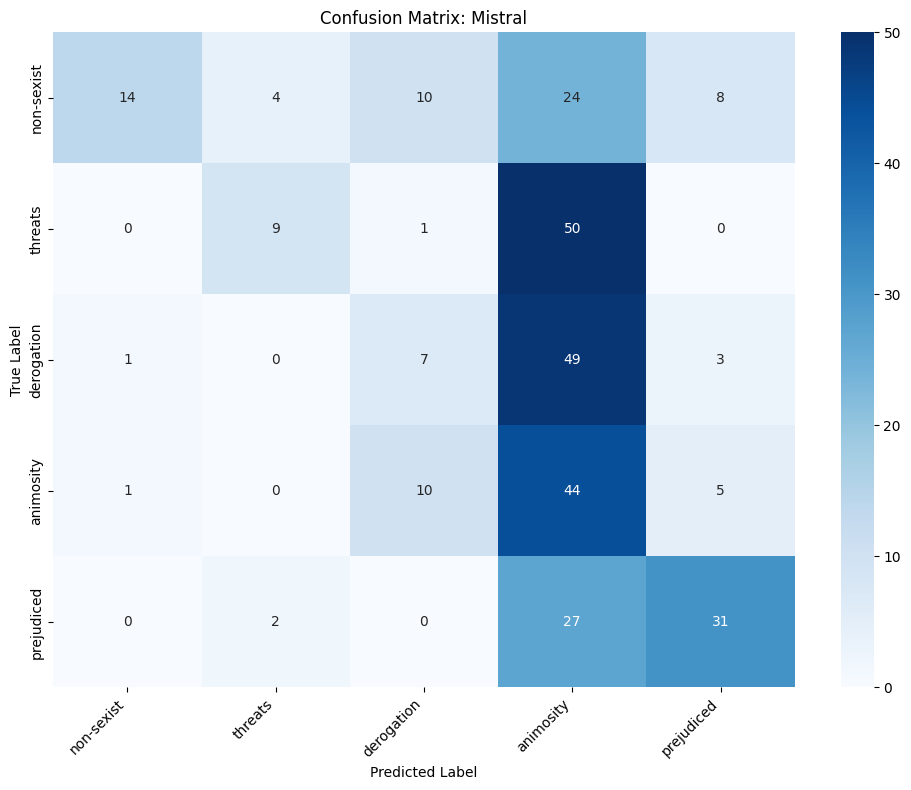


  Examples of: threats → animosity

【Example 1】
  Text: "[URL] Muslims home roots no need for women , closed their holes . Genital mutilation , Infections & ..."
  True label: threats
  Predicted: animosity
  Raw response: "animosity"

【Example 2】
  Text: "Don’t misunderstand me, I love my mother to death. At the same time, I would also like to give her a..."
  True label: threats
  Predicted: animosity
  Raw response: "animosity"

【Example 3】
  Text: "[USER] This is America we kick Rulers in the teeth (like Hillary) and if you won't serve us we won't..."
  True label: threats
  Predicted: animosity
  Raw response: "animosity"

  ERROR ANALYSIS: Mistral (examples_per_class=1)

Overall Statistics:
  Total samples: 300
  Valid predictions: 299
  Correct predictions: 124
  Errors: 175
  Failed parses: 1
  Accuracy: 41.47%
  Error rate: 58.53%
  Fail rate: 0.33%

Error Types (Top 10):
   1. derogation → animosity                     40 ( 22.9%)
   2. threats → animosity                   

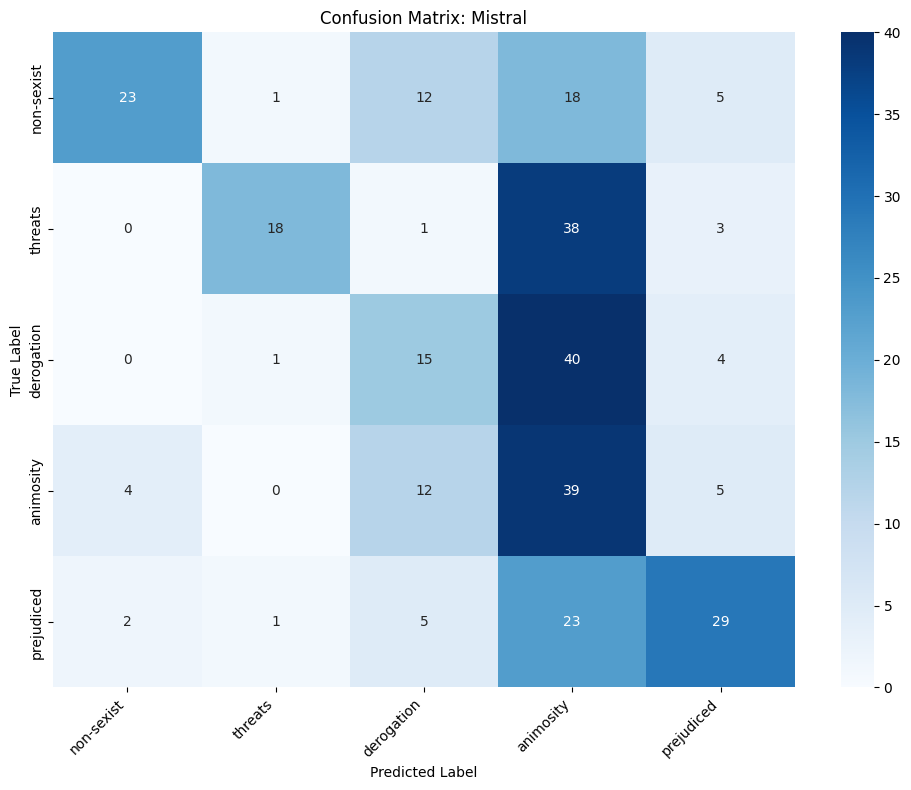


  Examples of: derogation → animosity

【Example 1】
  Text: "Two thoughts to keep in mind about women and AA. 1) Show me a hot girl and I'll show you a man sick ..."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

【Example 2】
  Text: "Maybe the Mayoress or whatever pronoun the cunt answers to should stop sheltering illegal migrant cr..."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

【Example 3】
  Text: ""That tall man must certaily be better with women because of his large muscles, big penis ... just i..."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

  FAILED PARSE EXAMPLES

【Failed Parse 1】
  Text: "In my life I have seen virtually zero correlation between gym hours logged and success with women. V..."
  True label: non-sexist
  Raw response: "not-sexist"

  ERROR ANALYSIS: Mistral (examples_per_class=2)

Overall Statistics:
  Total samples: 300
  Valid predictions: 288
  Correct predictions: 1

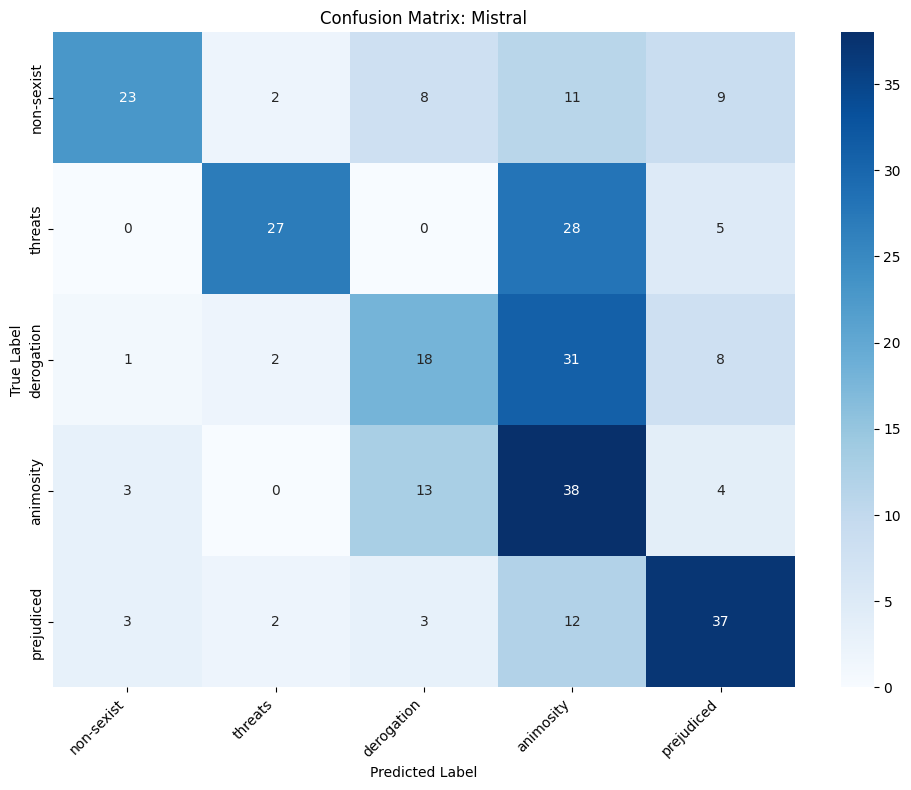


  Examples of: derogation → animosity

【Example 1】
  Text: "Maybe the Mayoress or whatever pronoun the cunt answers to should stop sheltering illegal migrant cr..."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity (prejud"

【Example 2】
  Text: ""That tall man must certaily be better with women because of his large muscles, big penis ... just i..."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

【Example 3】
  Text: "Correction, men chase all types of women but most are just for sex."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

  FAILED PARSE EXAMPLES

【Failed Parse 1】
  Text: "In my life I have seen virtually zero correlation between gym hours logged and success with women. V..."
  True label: non-sexist
  Raw response: "not-sexist"

【Failed Parse 2】
  Text: "Oh, for the love of Magical Sky Man, please tell me the % of German women that believe a wristband w..."
  True label: non-sexist
  Raw respon

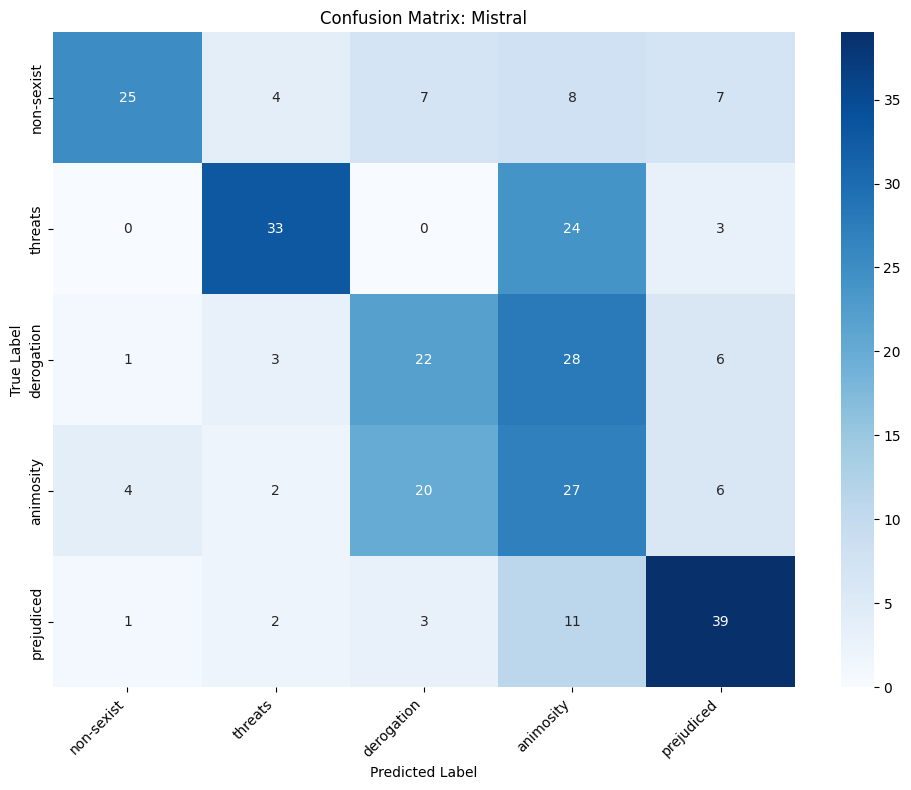


  Examples of: derogation → animosity

【Example 1】
  Text: "Maybe the Mayoress or whatever pronoun the cunt answers to should stop sheltering illegal migrant cr..."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

【Example 2】
  Text: "Correction, men chase all types of women but most are just for sex."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

【Example 3】
  Text: "Better yet, completely ignore women whenever possible. And certainly always be cagey. [Treat them li..."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

  FAILED PARSE EXAMPLES

【Failed Parse 1】
  Text: "In my life I have seen virtually zero correlation between gym hours logged and success with women. V..."
  True label: non-sexist
  Raw response: "not-sexist"

【Failed Parse 2】
  Text: "[URL] Excellent video which illustrates how much us men pay for women indirectly. Taxes and death is..."
  True label: prejudiced
  Raw response: "not

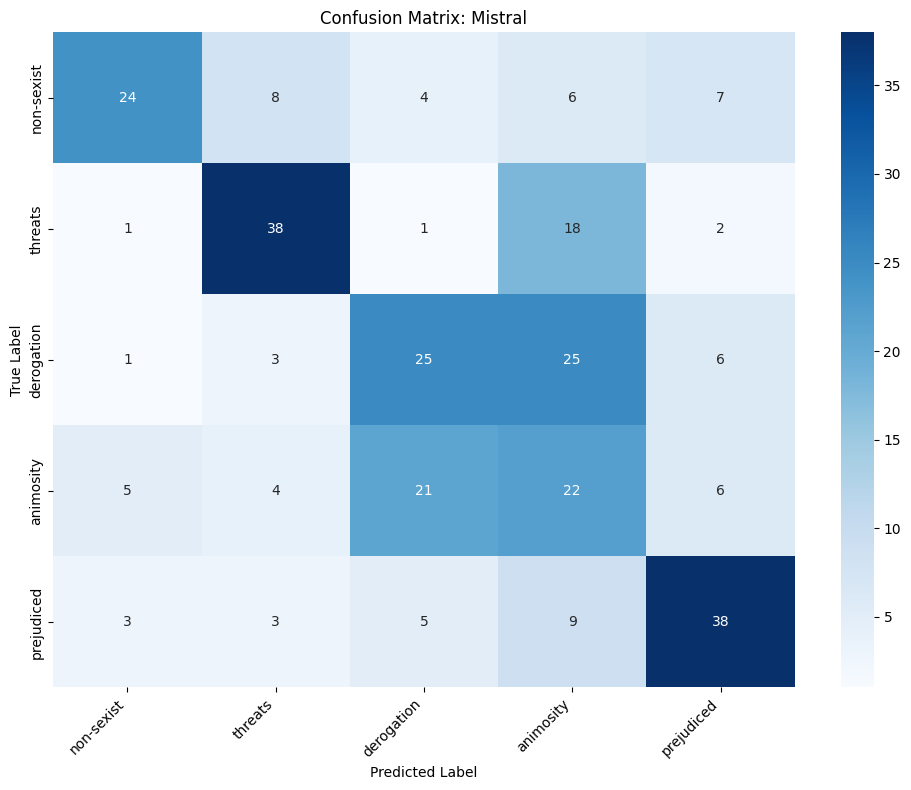


  Examples of: derogation → animosity

【Example 1】
  Text: "Maybe the Mayoress or whatever pronoun the cunt answers to should stop sheltering illegal migrant cr..."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

【Example 2】
  Text: "Correction, men chase all types of women but most are just for sex."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

【Example 3】
  Text: "Better yet, completely ignore women whenever possible. And certainly always be cagey. [Treat them li..."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

  FAILED PARSE EXAMPLES

【Failed Parse 1】
  Text: "She wants you to go talk to her. Since you didn't - she thinks - either you didn't like her - or you..."
  True label: animosity
  Raw response: "not-sexist"

【Failed Parse 2】
  Text: "In my life I have seen virtually zero correlation between gym hours logged and success with women. V..."
  True label: non-sexist
  Raw response: "not-

In [34]:
print("Performance Table Mistral (Zero-Shot vs Few-Shot)")

results_df_m = pd.read_csv('/content/drive/MyDrive/AssignmentsNLP/Assignment2/metrics/mistral_metrics.csv')
with open('/content/drive/MyDrive/AssignmentsNLP/Assignment2/metrics/all_predictions_m.pkl', 'rb') as f:
    all_predictions_m = pickle.load(f)

print(results_df_m)

mistral_results = rebuild_full_structure(
    model_name="Mistral",
    metrics_df=results_df_m,
    all_predictions=all_predictions_m,
    texts=texts_to_classify,
    y_true=y_true
)


error_analyses_mistral = comprehensive_error_analysis(mistral_results)


Best Configuration: 4 examples (F1: 0.5363)

############################################################
  COMPREHENSIVE EVALUATION: Mistral-Best (Few-Shot (k=4))
############################################################

  Mistral-Best (Few-Shot (k=4)) - Evaluation Results

Overall Performance:
  Accuracy: 0.5158
  Macro F1: 0.5266
  Weighted F1: 0.5252

Prediction Statistics:
  Total samples: 300
  Valid predictions: 285
  Failed predictions: 15 (5.0%)

Per-Class Metrics:
Category             Precision    Recall       F1           Support   
------------------------------------------------------------------
non-sexist           0.7059       0.4898       0.5783       49        
threats              0.6786       0.6333       0.6552       60        
derogation           0.4464       0.4167       0.4310       60        
animosity            0.2750       0.3793       0.3188       58        
prejudiced           0.6441       0.6552       0.6496       58        

Confusion Matrix:


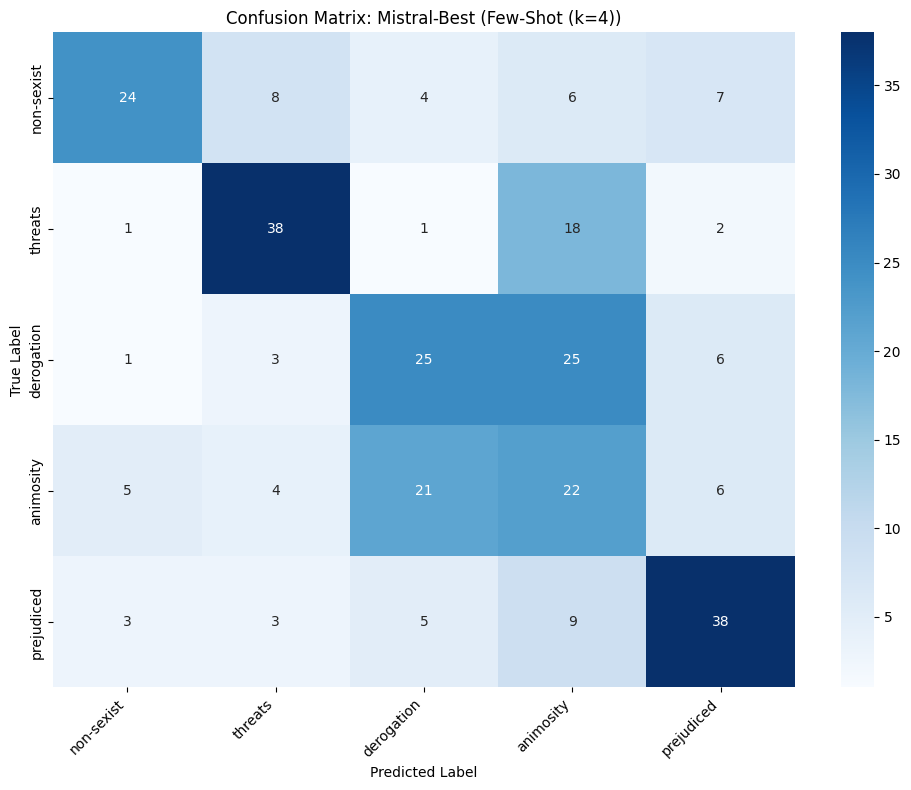


--------------------------------------------------------------------------------

  Mistral-Best (Few-Shot (k=4)) - Generation Quality Analysis

Response Length Statistics:
  Average length: 1.08 words
  Median length: 1.00 words
  Range: 1 - 4 words

Parsing Quality:
  Success rate: 95.00%
  Single-word responses: 282
  Verbose responses (>5 words): 0

Response Patterns:
  Starts With Label: 281
  Contains Explanation: 1
  Has Punctuation: 4
  Uppercase: 0
  Lowercase: 298
  Mixed Case: 2

Sample Failed Parses:
  1. "not-sexist"
  2. "not-sexist"
  3. "not-sexist"

--------------------------------------------------------------------------------

  Mistral-Best (Few-Shot (k=4)) - Error Analysis

Error Statistics:
  Total errors: 138
  Error rate: 48.42%

Most Common Error Types:
  derogation → animosity: 25 occurrences
  animosity → derogation: 21 occurrences
  threats → animosity: 18 occurrences
  prejudiced → animosity: 9 occurrences
  non-sexist → threats: 8 occurrences

Binary Cla

In [40]:
# 2. Find the absolute best setup (including zero-shot)
best_run_idx = results_df_m['macro_f1'].idxmax()
best_k = results_df_m.loc[best_run_idx, 'num_examples_per_class']
best_f1 = results_df_m.loc[best_run_idx, 'macro_f1']

print(f"\nBest Configuration: {best_k} examples (F1: {best_f1:.4f})")

# 3. Select the right data for the 'comprehensive_evaluation'
if best_k == 0:
    best_key = "zero_shot"
    config_name = "Zero-Shot"
else:
    best_key = f"few_shot_{best_k}"
    config_name = f"Few-Shot (k={best_k})"

best_preds = all_predictions_m[best_key]

# 4. Detailed analysis ONLY on the winner
mistral_detailed_stats = comprehensive_evaluation(
    model_name=f"Mistral-Best ({config_name})",
    texts=texts_to_classify,
    y_true=y_true,
    raw_responses=best_preds['raw'],
    predictions=best_preds['numeric']
)

#### Llama Analysis

Performance Table Llama (Zero-Shot vs Few-Shot)
   Model  num_examples_per_class  macro_f1  fail_ratio
0  Llama                       0  0.489064    0.056667
1  Llama                       1  0.400703    0.000000
2  Llama                       2  0.420613    0.040000
3  Llama                       3  0.434452    0.053333
4  Llama                       4  0.440736    0.053333

################################################################################
  COMPREHENSIVE ERROR ANALYSIS
################################################################################

  ERROR ANALYSIS: Llama (examples_per_class=0)

Overall Statistics:
  Total samples: 300
  Valid predictions: 283
  Correct predictions: 142
  Errors: 141
  Failed parses: 17
  Accuracy: 50.18%
  Error rate: 49.82%
  Fail rate: 5.67%

Error Types (Top 10):
   1. animosity → derogation                     21 ( 14.9%)
   2. derogation → animosity                     19 ( 13.5%)
   3. non-sexist → animosity                    

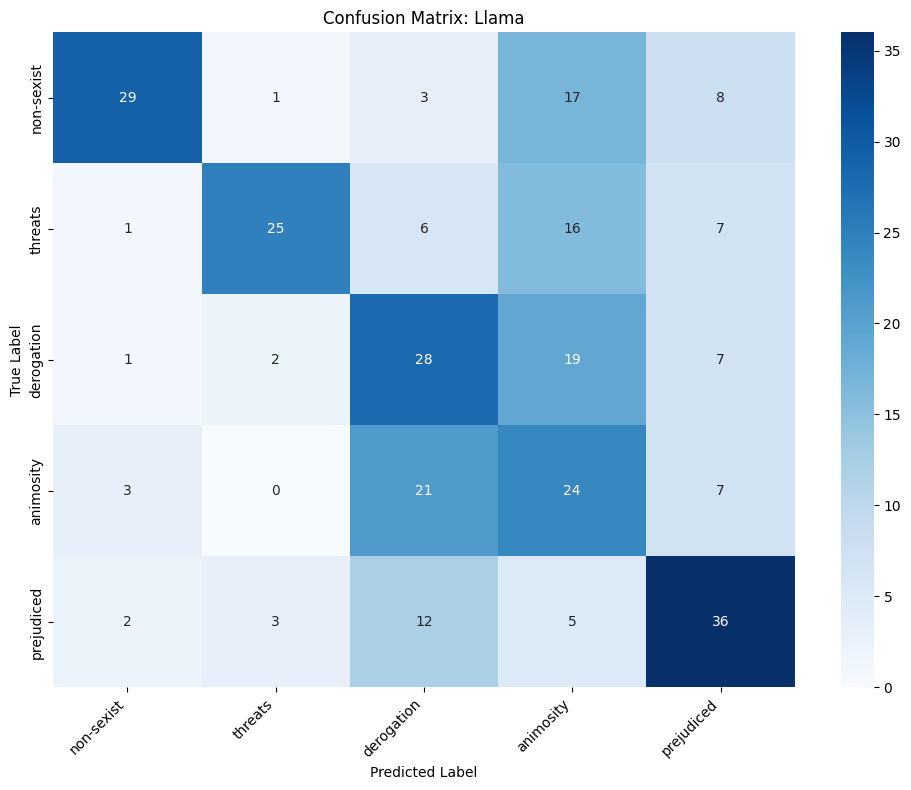


  Examples of: animosity → derogation

【Example 1】
  Text: "In my experience women don't recommend guys to their friends. If she doesn't want him then mostt lik..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

【Example 2】
  Text: "And not imagine all those fans of Batchelorette. The packaged story that millions buy at zero though..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

【Example 3】
  Text: "Women aren't renown for originality in general. Feminism is just female nagging and mind games with ..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

  FAILED PARSE EXAMPLES

【Failed Parse 1】
  Text: "[URL] Muslims home roots no need for women , closed their holes . Genital mutilation , Infections & ..."
  True label: threats
  Raw response: "I cannot annotate text that"

【Failed Parse 2】
  Text: "Yea they exposes closet faggots and faggots with aids and whores that fuck faggots! Edward Bernar

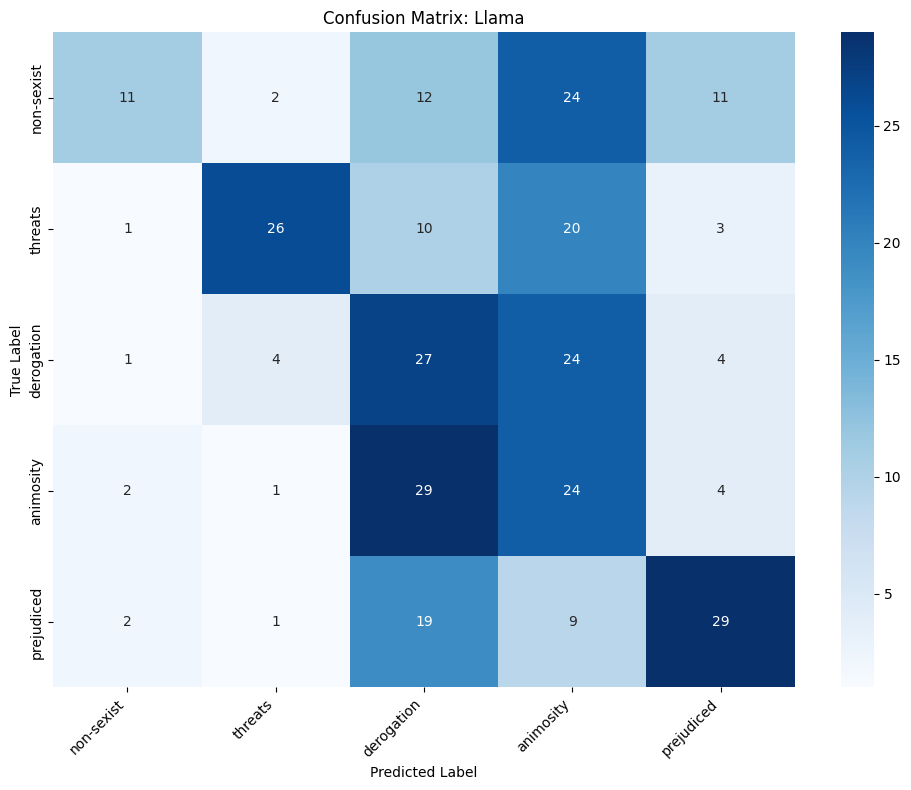


  Examples of: animosity → derogation

【Example 1】
  Text: "Yeah some high ranking cunt periodically deletes perfectly well sourced entries. Her ~~sandbox~~ use..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

【Example 2】
  Text: "And not imagine all those fans of Batchelorette. The packaged story that millions buy at zero though..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

【Example 3】
  Text: "Women aren't renown for originality in general. Feminism is just female nagging and mind games with ..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

  ERROR ANALYSIS: Llama (examples_per_class=2)

Overall Statistics:
  Total samples: 300
  Valid predictions: 288
  Correct predictions: 117
  Errors: 171
  Failed parses: 12
  Accuracy: 40.62%
  Error rate: 59.38%
  Fail rate: 4.00%

Error Types (Top 10):
   1. derogation → animosity                     29 ( 17.0%)
   2. non-sexist → animosity  

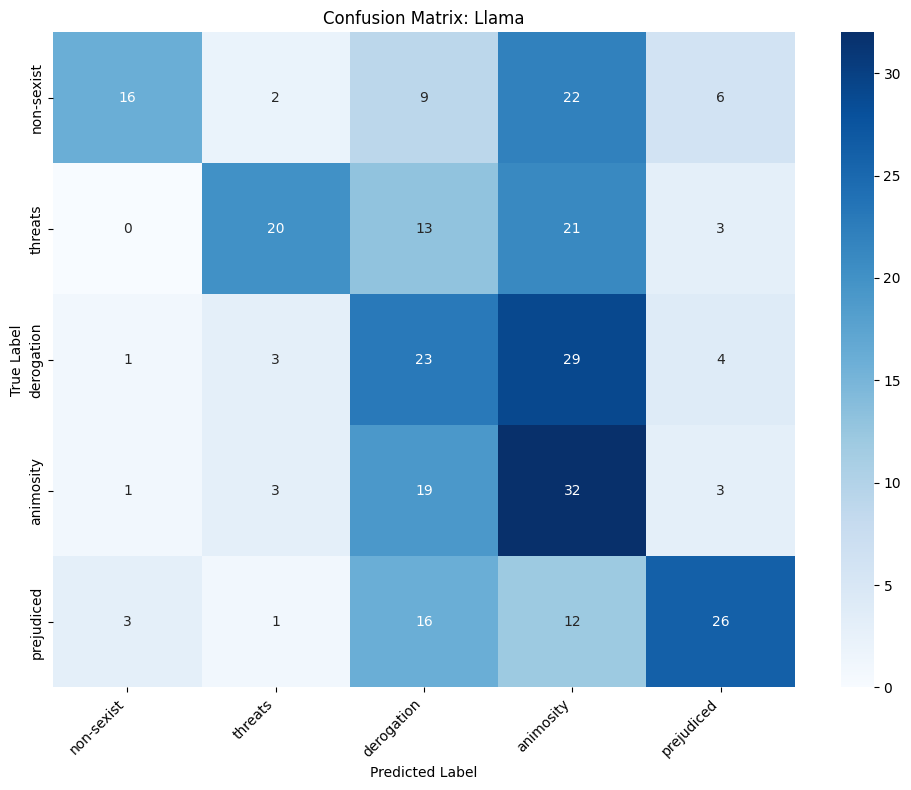


  Examples of: derogation → animosity

【Example 1】
  Text: "Two thoughts to keep in mind about women and AA. 1) Show me a hot girl and I'll show you a man sick ..."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

【Example 2】
  Text: ""That tall man must certaily be better with women because of his large muscles, big penis ... just i..."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

【Example 3】
  Text: "Correction, men chase all types of women but most are just for sex."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

  FAILED PARSE EXAMPLES

【Failed Parse 1】
  Text: "So just a few months ago, while Republican women were accused of being forced to vote their husbands..."
  True label: prejudiced
  Raw response: "TEXT: So just a"

【Failed Parse 2】
  Text: "This thing does this to my son she'll be up on an impaling pole and he'll do it too!"
  True label: threats
  Raw response: "TEXT: This thing doe

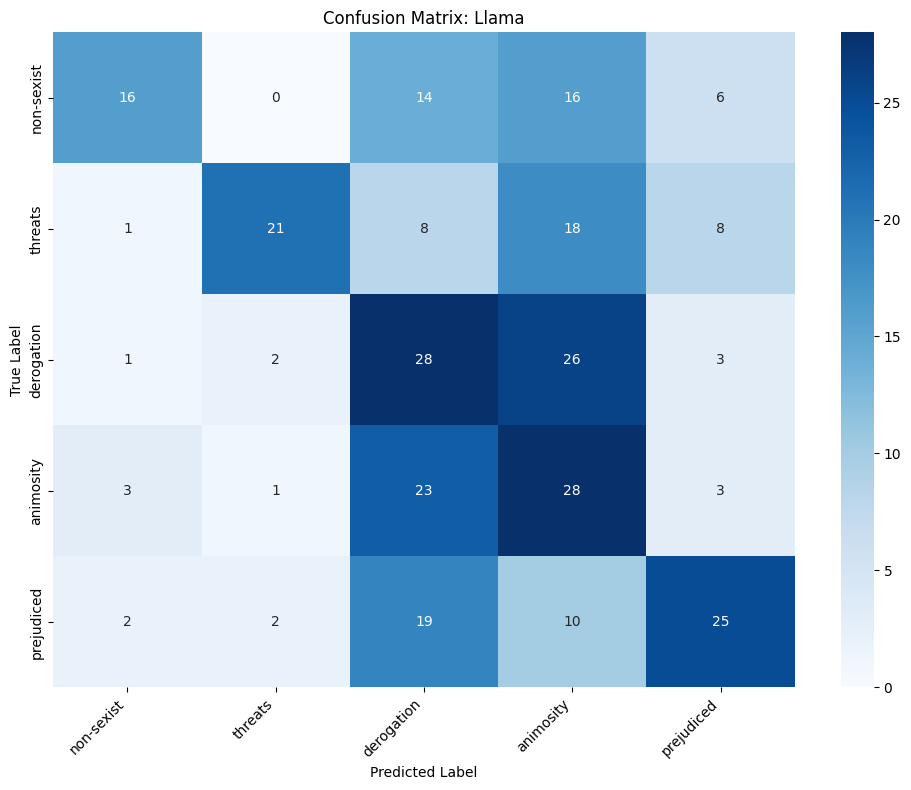


  Examples of: derogation → animosity

【Example 1】
  Text: "Two thoughts to keep in mind about women and AA. 1) Show me a hot girl and I'll show you a man sick ..."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

【Example 2】
  Text: ""That tall man must certaily be better with women because of his large muscles, big penis ... just i..."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

【Example 3】
  Text: "Better yet, completely ignore women whenever possible. And certainly always be cagey. [Treat them li..."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

  FAILED PARSE EXAMPLES

【Failed Parse 1】
  Text: "So just a few months ago, while Republican women were accused of being forced to vote their husbands..."
  True label: prejudiced
  Raw response: "TEXT: So just a"

【Failed Parse 2】
  Text: "If she's fucking you, she likes you."
  True label: non-sexist
  Raw response: "ANSWER: non-sex"

【Failed Par

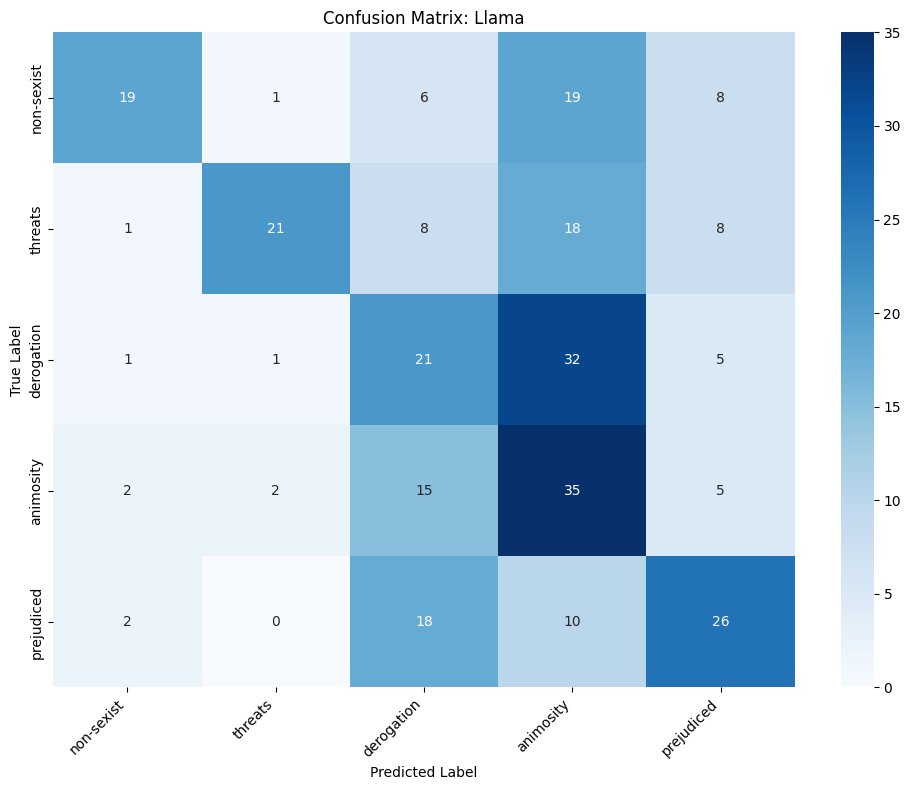


  Examples of: derogation → animosity

【Example 1】
  Text: ""That tall man must certaily be better with women because of his large muscles, big penis ... just i..."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

【Example 2】
  Text: "Correction, men chase all types of women but most are just for sex."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

【Example 3】
  Text: "Better yet, completely ignore women whenever possible. And certainly always be cagey. [Treat them li..."
  True label: derogation
  Predicted: animosity
  Raw response: "animosity"

  FAILED PARSE EXAMPLES

【Failed Parse 1】
  Text: "So just a few months ago, while Republican women were accused of being forced to vote their husbands..."
  True label: prejudiced
  Raw response: "TEXT: So just a"

【Failed Parse 2】
  Text: "It was rape because she regretted it afterwards, duh. There's no way she could have sex with a nerd...."
  True label: prejudiced
  Raw response:

In [35]:
print("Performance Table Llama (Zero-Shot vs Few-Shot)")

results_df_l = pd.read_csv('/content/drive/MyDrive/AssignmentsNLP/Assignment2/metrics/llama_metrics.csv')
with open('/content/drive/MyDrive/AssignmentsNLP/Assignment2/metrics/all_predictions_l.pkl', 'rb') as f:
    all_predictions_l = pickle.load(f)
print(results_df_l)


llama_results = rebuild_full_structure(
    model_name="Llama",
    metrics_df=results_df_l,
    all_predictions=all_predictions_l,
    texts=texts_to_classify,
    y_true=y_true
)


error_analyses_llama = comprehensive_error_analysis(llama_results)


Best Configuration: 0 examples (F1: 0.4891)

############################################################
  COMPREHENSIVE EVALUATION: Llama-Best (Zero-Shot)
############################################################

  Llama-Best (Zero-Shot) - Evaluation Results

Overall Performance:
  Accuracy: 0.5018
  Macro F1: 0.5155
  Weighted F1: 0.5168

Prediction Statistics:
  Total samples: 300
  Valid predictions: 283
  Failed predictions: 17 (5.7%)

Per-Class Metrics:
Category             Precision    Recall       F1           Support   
------------------------------------------------------------------
non-sexist           0.8056       0.5000       0.6170       58        
threats              0.8065       0.4545       0.5814       55        
derogation           0.4000       0.4912       0.4409       57        
animosity            0.2963       0.4364       0.3529       55        
prejudiced           0.5538       0.6207       0.5854       58        

Confusion Matrix:


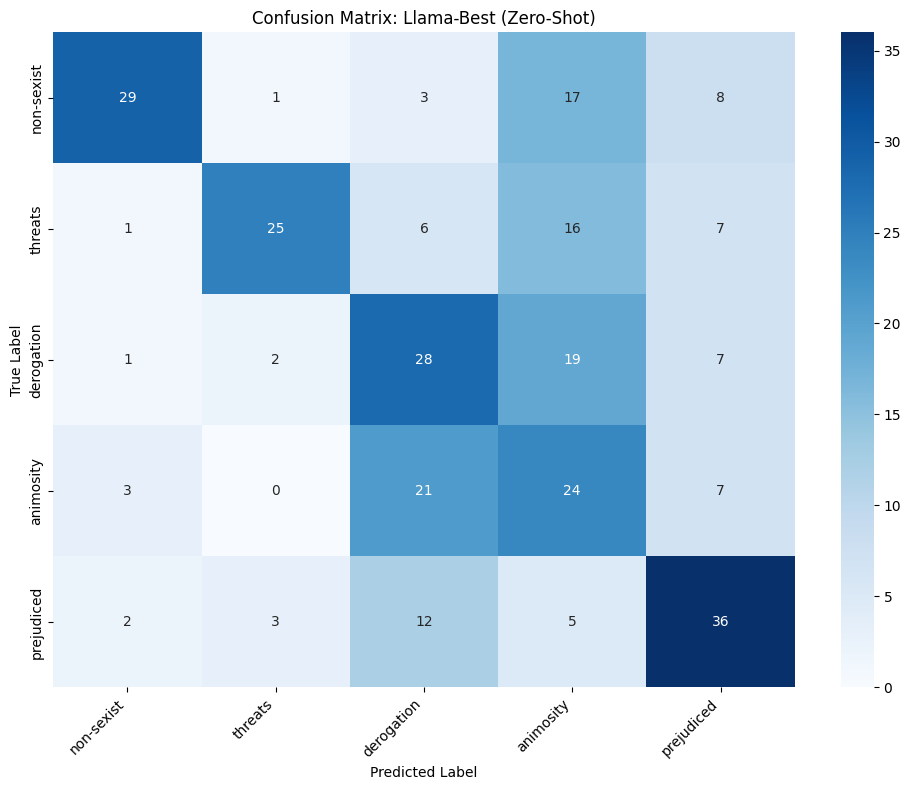


--------------------------------------------------------------------------------

  Llama-Best (Zero-Shot) - Generation Quality Analysis

Response Length Statistics:
  Average length: 1.23 words
  Median length: 1.00 words
  Range: 1 - 5 words

Parsing Quality:
  Success rate: 94.33%
  Single-word responses: 282
  Verbose responses (>5 words): 0

Response Patterns:
  Starts With Label: 283
  Contains Explanation: 17
  Has Punctuation: 0
  Uppercase: 0
  Lowercase: 282
  Mixed Case: 18

Sample Failed Parses:
  1. "I cannot annotate text that"
  2. "I cannot annotate text that"
  3. "I cannot create content that"

--------------------------------------------------------------------------------

  Llama-Best (Zero-Shot) - Error Analysis

Error Statistics:
  Total errors: 141
  Error rate: 49.82%

Most Common Error Types:
  animosity → derogation: 21 occurrences
  derogation → animosity: 19 occurrences
  non-sexist → animosity: 17 occurrences
  threats → animosity: 16 occurrences
  prejud

In [41]:
best_run_idx = results_df_l['macro_f1'].idxmax()
best_k = results_df_l.loc[best_run_idx, 'num_examples_per_class']
best_f1 = results_df_l.loc[best_run_idx, 'macro_f1']

print(f"\nBest Configuration: {best_k} examples (F1: {best_f1:.4f})")


if best_k == 0:
    best_key = "zero_shot"
    config_name = "Zero-Shot"
else:
    best_key = f"few_shot_{best_k}"
    config_name = f"Few-Shot (k={best_k})"

best_preds = all_predictions_l[best_key]


llama_detailed_stats = comprehensive_evaluation(
    model_name=f"Llama-Best ({config_name})",
    texts=texts_to_classify,
    y_true=y_true,
    raw_responses=best_preds['raw'],
    predictions=best_preds['numeric']
)

#### Qwen Analysis

Performance Table Qwen (Zero-Shot vs Few-Shot)
  Model  num_examples_per_class  macro_f1  fail_ratio
0  Qwen                       0  0.230754    0.000000
1  Qwen                       1  0.319008    0.003333
2  Qwen                       2  0.318274    0.013333
3  Qwen                       3  0.343162    0.013333
4  Qwen                       4  0.335270    0.013333

################################################################################
  COMPREHENSIVE ERROR ANALYSIS
################################################################################

  ERROR ANALYSIS: Qwen (examples_per_class=0)

Overall Statistics:
  Total samples: 300
  Valid predictions: 300
  Correct predictions: 88
  Errors: 212
  Failed parses: 0
  Accuracy: 29.33%
  Error rate: 70.67%
  Fail rate: 0.00%

Error Types (Top 10):
   1. animosity → derogation                     41 ( 19.3%)
   2. threats → derogation                       41 ( 19.3%)
   3. prejudiced → derogation                    28 ( 13.2

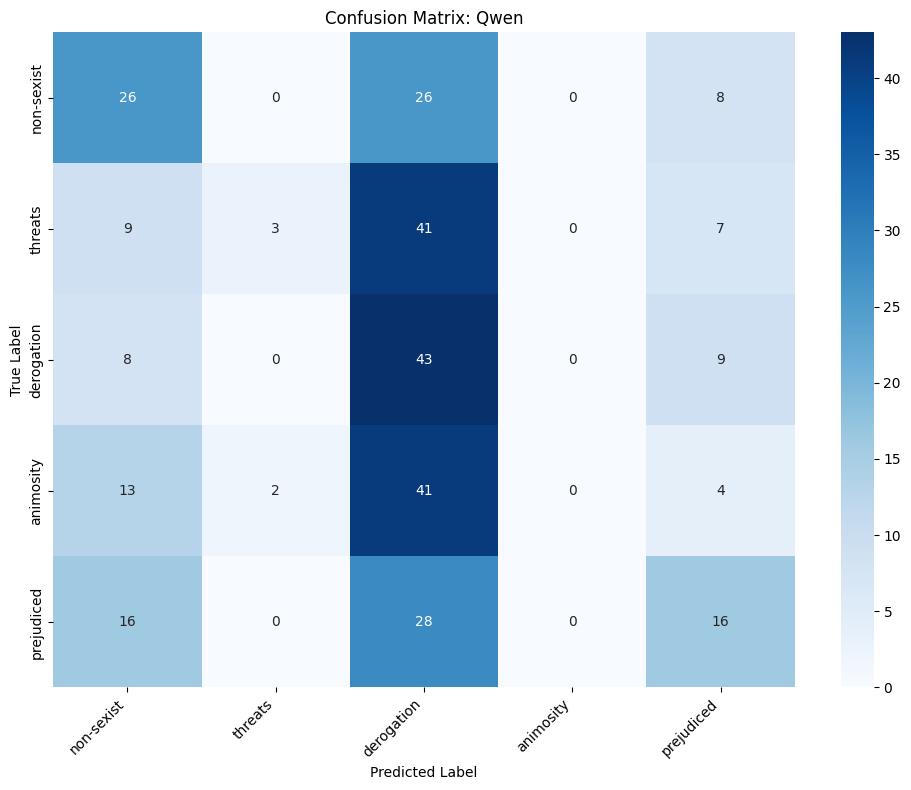


  Examples of: animosity → derogation

【Example 1】
  Text: "She wants you to go talk to her. Since you didn't - she thinks - either you didn't like her - or you..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

【Example 2】
  Text: "LOL, translation: "I was playing, I'm a pussy"."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

【Example 3】
  Text: "And not imagine all those fans of Batchelorette. The packaged story that millions buy at zero though..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

  ERROR ANALYSIS: Qwen (examples_per_class=1)

Overall Statistics:
  Total samples: 300
  Valid predictions: 299
  Correct predictions: 98
  Errors: 201
  Failed parses: 1
  Accuracy: 32.78%
  Error rate: 67.22%
  Fail rate: 0.33%

Error Types (Top 10):
   1. animosity → derogation                     50 ( 24.9%)
   2. threats → derogation                       34 ( 16.9%)
   3. prejudiced → derogatio

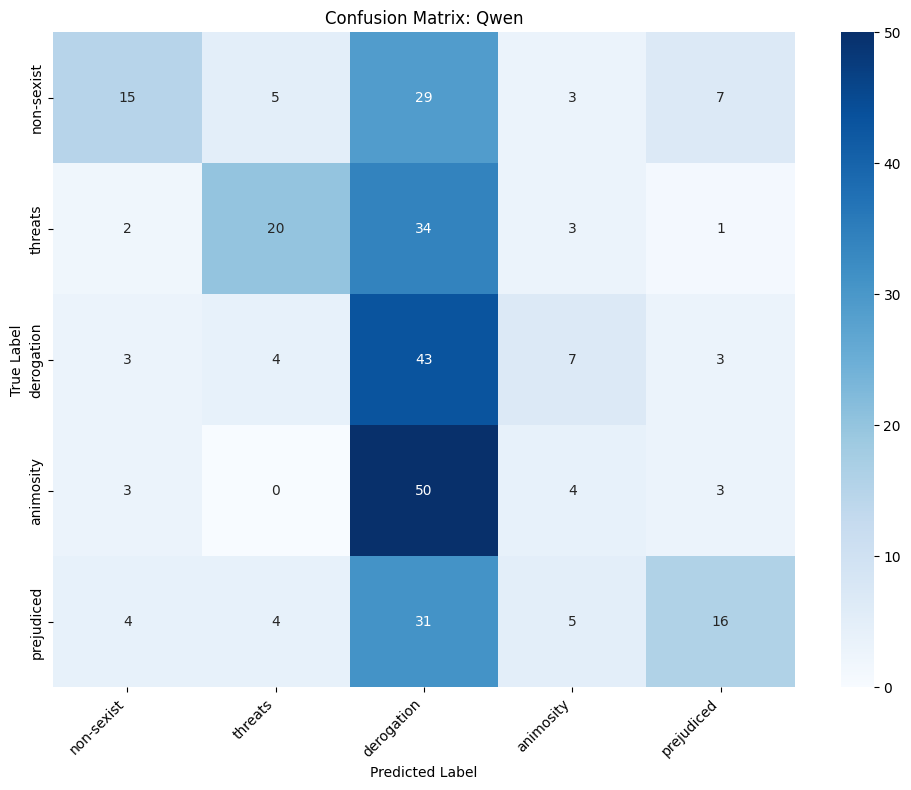


  Examples of: animosity → derogation

【Example 1】
  Text: "She wants you to go talk to her. Since you didn't - she thinks - either you didn't like her - or you..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

【Example 2】
  Text: "In my experience women don't recommend guys to their friends. If she doesn't want him then mostt lik..."
  True label: animosity
  Predicted: derogation
  Raw response: "Answer: derogation"

【Example 3】
  Text: "LOL, translation: "I was playing, I'm a pussy"."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

  FAILED PARSE EXAMPLES

【Failed Parse 1】
  Text: "Like I said. Sorry. (Sounds like I hit a nerve? Is he your girlfriend or something?)"
  True label: non-sexist
  Raw response: "not-sexist"

  ERROR ANALYSIS: Qwen (examples_per_class=2)

Overall Statistics:
  Total samples: 300
  Valid predictions: 296
  Correct predictions: 105
  Errors: 191
  Failed parses: 4
  Accuracy: 35.47%
  Error rate

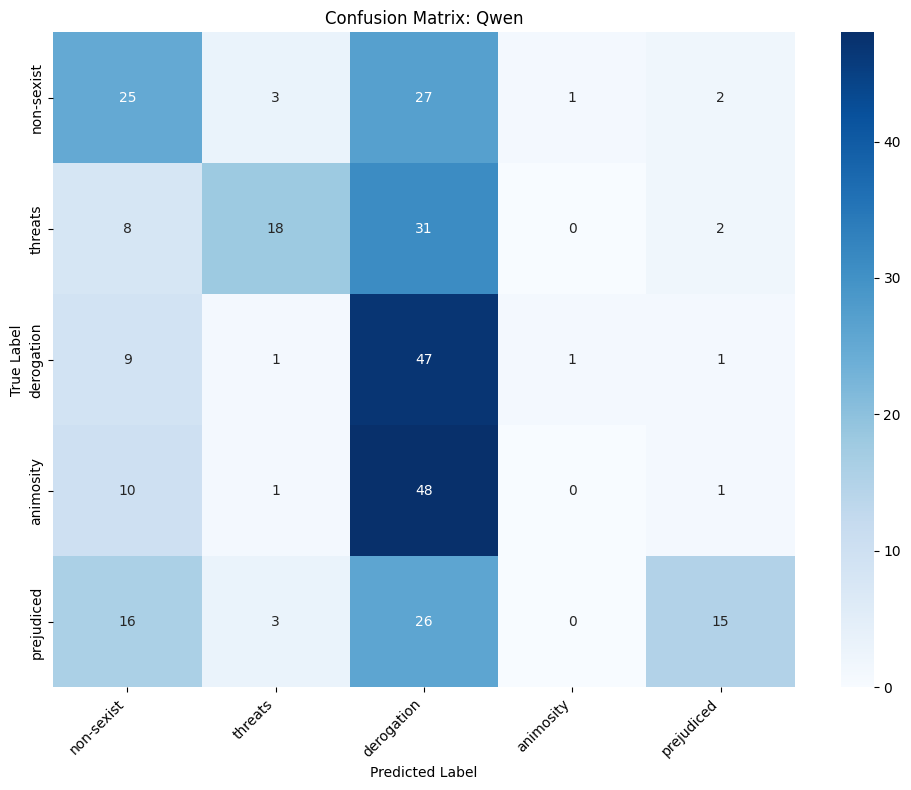


  Examples of: animosity → derogation

【Example 1】
  Text: "She wants you to go talk to her. Since you didn't - she thinks - either you didn't like her - or you..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

【Example 2】
  Text: "In my experience women don't recommend guys to their friends. If she doesn't want him then mostt lik..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

【Example 3】
  Text: "Yea they exposes closet faggots and faggots with aids and whores that fuck faggots! Edward Bernard P..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

  FAILED PARSE EXAMPLES

【Failed Parse 1】
  Text: "Russia, Russia, Russia! It's starting to be as annoying as the old Brady Bunch TV show line, Marcia,..."
  True label: non-sexist
  Raw response: "not-sexist"

【Failed Parse 2】
  Text: "Oh they're going on about Jeremy Meeks again? lol. Yes a lot of mentally unstable women who maybe re..."
  True

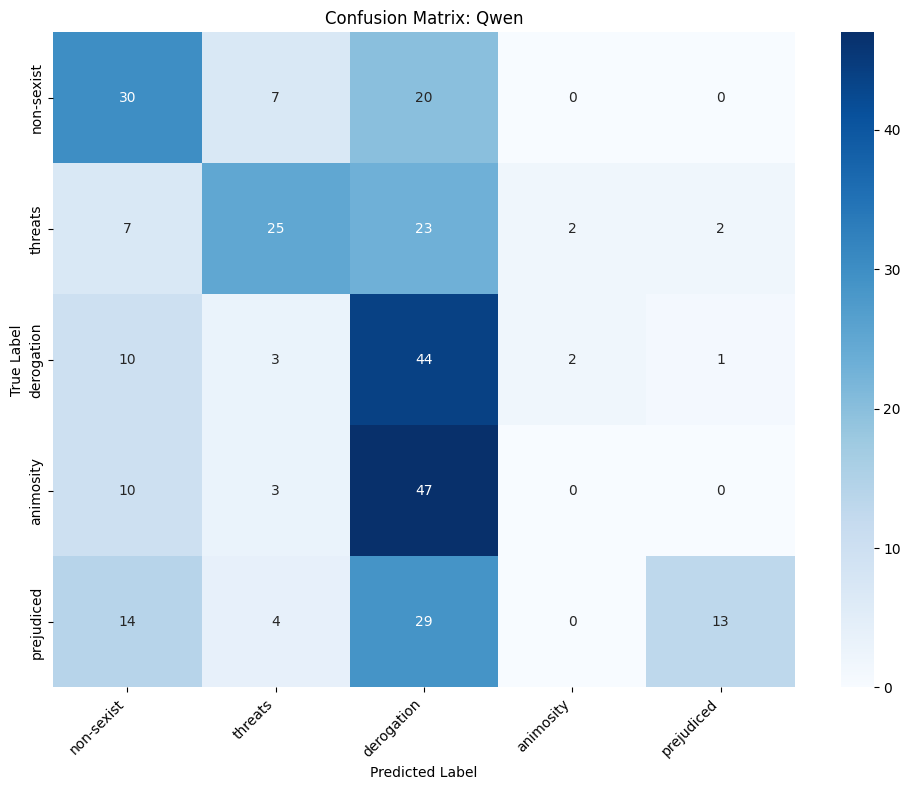


  Examples of: animosity → derogation

【Example 1】
  Text: "She wants you to go talk to her. Since you didn't - she thinks - either you didn't like her - or you..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

【Example 2】
  Text: "In my experience women don't recommend guys to their friends. If she doesn't want him then mostt lik..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

【Example 3】
  Text: "Yea they exposes closet faggots and faggots with aids and whores that fuck faggots! Edward Bernard P..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

  FAILED PARSE EXAMPLES

【Failed Parse 1】
  Text: "Russia, Russia, Russia! It's starting to be as annoying as the old Brady Bunch TV show line, Marcia,..."
  True label: non-sexist
  Raw response: "not-sexist"

【Failed Parse 2】
  Text: "Help for what you dumb fucking fool. You don't even know me and don't know my life and what I achiev..."
  True

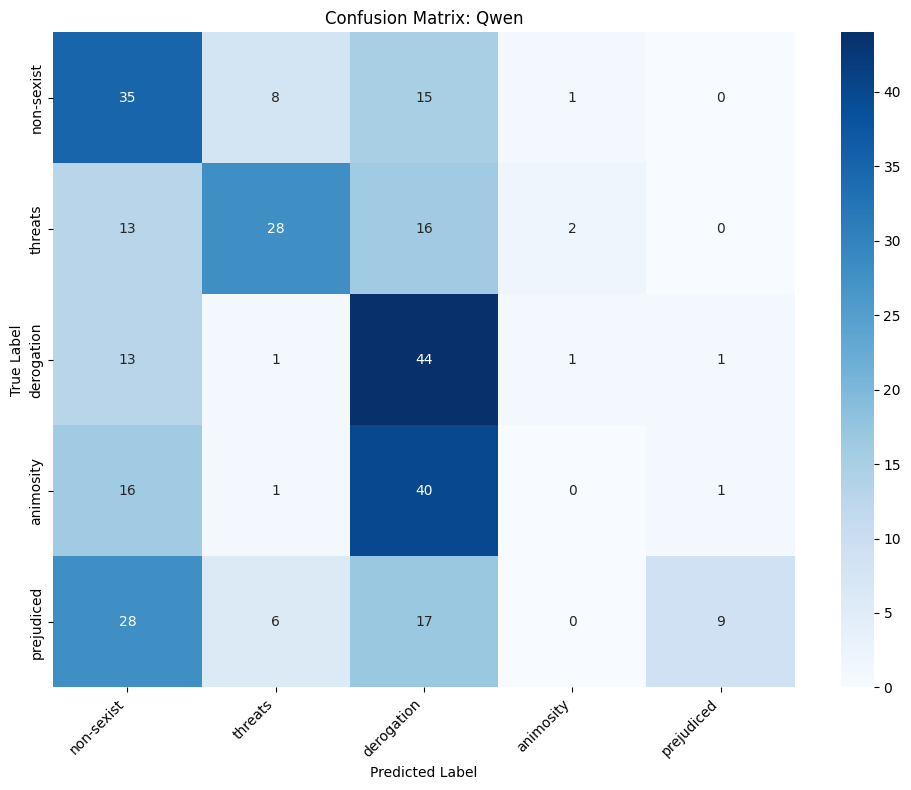


  Examples of: animosity → derogation

【Example 1】
  Text: "She wants you to go talk to her. Since you didn't - she thinks - either you didn't like her - or you..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

【Example 2】
  Text: "Yea they exposes closet faggots and faggots with aids and whores that fuck faggots! Edward Bernard P..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

【Example 3】
  Text: "LOL, translation: "I was playing, I'm a pussy"."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

  FAILED PARSE EXAMPLES

【Failed Parse 1】
  Text: "No, just no... You sound like a 14 year old girl that never shuts the fuck up and is a little TOO ha..."
  True label: animosity
  Raw response: "not-sexist"

【Failed Parse 2】
  Text: "And there is a reason to believe him. The tingles she gets from being around him and by believing hi..."
  True label: animosity
  Raw response: "not-sexist"

【Failed P

In [36]:
print("Performance Table Qwen (Zero-Shot vs Few-Shot)")

results_df_q = pd.read_csv('/content/drive/MyDrive/AssignmentsNLP/Assignment2/metrics/qwen_metrics.csv')
with open('/content/drive/MyDrive/AssignmentsNLP/Assignment2/metrics/all_predictions_q.pkl', 'rb') as f:
    all_predictions_q = pickle.load(f)
print(results_df_q)


llama_results = rebuild_full_structure(
    model_name="Qwen",
    metrics_df=results_df_q,
    all_predictions=all_predictions_q,
    texts=texts_to_classify,
    y_true=y_true
)


error_analyses_llama = comprehensive_error_analysis(llama_results)


Best Configuration: 3 examples (F1: 0.3432)

############################################################
  COMPREHENSIVE EVALUATION: Qwen-Best (Few-Shot (k=3))
############################################################

  Qwen-Best (Few-Shot (k=3)) - Evaluation Results

Overall Performance:
  Accuracy: 0.3784
  Macro F1: 0.3401
  Weighted F1: 0.3383

Prediction Statistics:
  Total samples: 300
  Valid predictions: 296
  Failed predictions: 4 (1.3%)

Per-Class Metrics:
Category             Precision    Recall       F1           Support   
------------------------------------------------------------------
non-sexist           0.4225       0.5263       0.4688       57        
threats              0.5952       0.4237       0.4950       59        
derogation           0.2699       0.7333       0.3946       60        
animosity            0.0000       0.0000       0.0000       60        
prejudiced           0.8125       0.2167       0.3421       60        

Confusion Matrix:


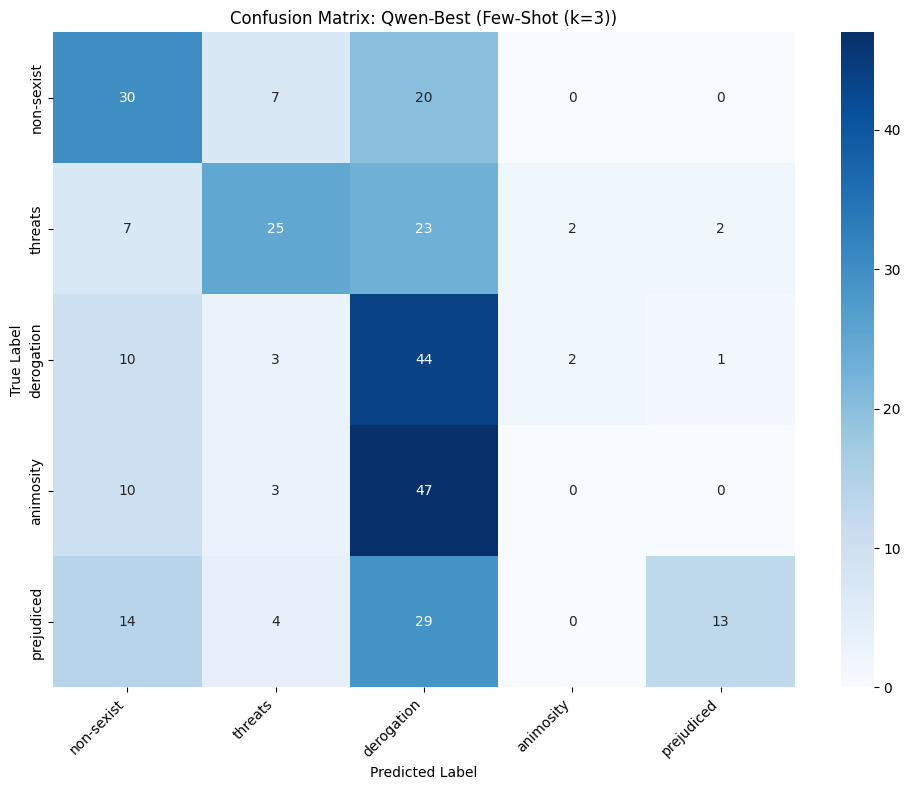


--------------------------------------------------------------------------------

  Qwen-Best (Few-Shot (k=3)) - Generation Quality Analysis

Response Length Statistics:
  Average length: 1.00 words
  Median length: 1.00 words
  Range: 1 - 1 words

Parsing Quality:
  Success rate: 98.67%
  Single-word responses: 300
  Verbose responses (>5 words): 0

Response Patterns:
  Starts With Label: 296
  Contains Explanation: 0
  Has Punctuation: 0
  Uppercase: 0
  Lowercase: 300
  Mixed Case: 0

Sample Failed Parses:
  1. "not-sexist"
  2. "not-sexist"
  3. "not-sexist"

--------------------------------------------------------------------------------

  Qwen-Best (Few-Shot (k=3)) - Error Analysis

Error Statistics:
  Total errors: 184
  Error rate: 62.16%

Most Common Error Types:
  animosity → derogation: 47 occurrences
  prejudiced → derogation: 29 occurrences
  threats → derogation: 23 occurrences
  non-sexist → derogation: 20 occurrences
  prejudiced → non-sexist: 14 occurrences

Binary C

In [42]:
best_run_idx = results_df_q['macro_f1'].idxmax()
best_k = results_df_q.loc[best_run_idx, 'num_examples_per_class']
best_f1 = results_df_q.loc[best_run_idx, 'macro_f1']

print(f"\nBest Configuration: {best_k} examples (F1: {best_f1:.4f})")


if best_k == 0:
    best_key = "zero_shot"
    config_name = "Zero-Shot"
else:
    best_key = f"few_shot_{best_k}"
    config_name = f"Few-Shot (k={best_k})"

best_preds = all_predictions_q[best_key]


qwen_detailed_stats = comprehensive_evaluation(
    model_name=f"Qwen-Best ({config_name})",
    texts=texts_to_classify,
    y_true=y_true,
    raw_responses=best_preds['raw'],
    predictions=best_preds['numeric']
)

#### Model comparison

In [43]:
def compare_models_pandas(all_results, label_names=None):
    """
    Compare multiple models side-by-side using pandas DataFrames.
    Only returns DataFrames for tables; does NOT plot confusion matrices.

    Inputs:
        all_results: list of result dictionaries from comprehensive_evaluation
        label_names: optional list of label names

    Returns:
        dict of DataFrames for each comparison type
    """
    if label_names is None:
        label_names = ['non-sexist', 'threats', 'derogation', 'animosity', 'prejudiced']

    tables = {}

    # Overall Performance
    overall_data = []
    for result in all_results:
        overall_data.append({
            'Model': result['model_name'],
            'Accuracy': result['evaluation']['accuracy'],
            'Macro F1': result['evaluation']['macro_f1'],
            'Weighted F1': result['evaluation']['weighted_f1'],
            'Parse Rate': result['generation']['parsing_success_rate']
        })
    tables['overall'] = pd.DataFrame(overall_data)

    # Per-Class F1
    per_class_data = []
    for result in all_results:
        row = {'Model': result['model_name']}
        for label in label_names:
            row[label] = result['evaluation']['per_class_metrics'][label]['f1']
        per_class_data.append(row)
    tables['per_class_f1'] = pd.DataFrame(per_class_data)

    # Error Comparison
    error_data = []
    for result in all_results:
        error_data.append({
            'Model': result['model_name'],
            'Total Errors': result['errors']['total_errors'],
            'Error Rate': result['errors']['error_rate'],
            'False Positives': len(result['errors']['binary_errors']['false_positives']),
            'False Negatives': len(result['errors']['binary_errors']['false_negatives'])
        })
    tables['errors'] = pd.DataFrame(error_data)

    # Generation Quality
    gen_data = []
    for result in all_results:
        gen_data.append({
            'Model': result['model_name'],
            'Avg Length': result['generation']['avg_response_length'],
            'Verbose': result['generation']['num_verbose_responses'],
            'Single Word': result['generation']['num_single_word']
        })
    tables['generation'] = pd.DataFrame(gen_data)

    return tables


def plot_confusion_matrices(all_results, label_names=None, figsize=(18, 5), cmap="Blues"):
    """
    Plot side-by-side confusion matrices for multiple models.

    Inputs:
        all_results: list of result dictionaries from comprehensive_evaluation
        label_names: list of labels, defaults to ['non-sexist', 'threats', 'derogation', 'animosity', 'prejudiced']
        figsize: size of the figure
        cmap: colormap for heatmaps
    """
    if label_names is None:
        label_names = ['non-sexist', 'threats', 'derogation', 'animosity', 'prejudiced']

    num_models = len(all_results)
    fig, axes = plt.subplots(1, num_models, figsize=figsize)

    if num_models == 1:
        axes = [axes]

    for ax, result in zip(axes, all_results):
        cm = result['evaluation']['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                    xticklabels=label_names, yticklabels=label_names, ax=ax)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title(result['model_name'])

    plt.tight_layout()
    plt.show()




Overall


,Model,Accuracy,Macro F1,Weighted F1,Parse Rate
0,Mistral-Best (Few-Shot (k=4)),0.515789,0.526587,0.525185,0.950000
1,Llama-Best (Zero-Shot),0.501767,0.515534,0.516823,0.943333
2,Qwen-Best (Few-Shot (k=3)),0.378378,0.340105,0.338277,0.986667



Per class F1


,Model,non-sexist,threats,derogation,animosity,prejudiced
0,Mistral-Best (Few-Shot (k=4)),0.578313,0.655172,0.431034,0.318841,0.649573
1,Llama-Best (Zero-Shot),0.617021,0.581395,0.440945,0.352941,0.585366
2,Qwen-Best (Few-Shot (k=3)),0.468750,0.495050,0.394619,0.000000,0.342105



Errors


,Model,Total Errors,Error Rate,False Positives,False Negatives
0,Mistral-Best (Few-Shot (k=4)),138,0.484211,25,10
1,Llama-Best (Zero-Shot),141,0.498233,29,7
2,Qwen-Best (Few-Shot (k=3)),184,0.621622,27,41



Generation


,Model,Avg Length,Verbose,Single Word
0,Mistral-Best (Few-Shot (k=4)),1.080000,0,282
1,Llama-Best (Zero-Shot),1.233333,0,282
2,Qwen-Best (Few-Shot (k=3)),1.000000,0,300



Confusion Matrices


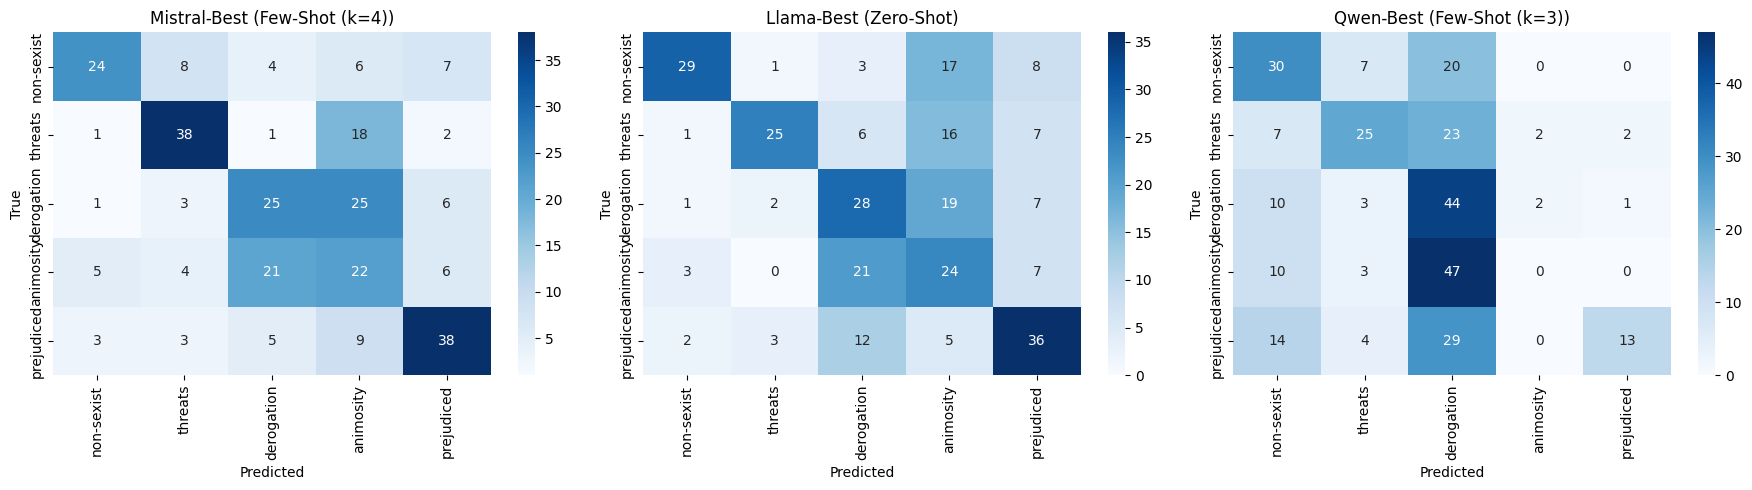

In [44]:
tables = compare_models_pandas([mistral_detailed_stats, llama_detailed_stats, qwen_detailed_stats])

print('Overall')
display(tables['overall'])
print('\nPer class F1')
display(tables['per_class_f1'])
print('\nErrors')
display(tables['errors'])
print('\nGeneration')
display(tables['generation'])

print('\nConfusion Matrices')
plot_confusion_matrices([mistral_detailed_stats, llama_detailed_stats, qwen_detailed_stats])


# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...

# [Task 8] Bonus point

For the bonus tasks we decided to use only the Mistral model since it was the one that gave the best results.

### Evaluate A1 dataset and perform comparison

In [ ]:
data_path = '/content/drive/MyDrive/AssignmentsNLP/Assignment1/data'

In [ ]:
from collections import Counter

# Load a1 Dataset
test_df = pd.read_json(os.path.join(data_path, 'test.json')).T

# Save only english tweets
test_df = test_df[test_df['lang'] == 'en']

# Compute Majority Vote
# 'labels_task1' is a list of type ['YES', 'YES', 'NO', ...]. -> We need to extract the majority to deduce if the tweet is sexist or not
def get_majority_vote(labels_list):
    return Counter(labels_list).most_common(1)[0][0]

test_df['gold_label'] = test_df['labels_task1'].apply(get_majority_vote)

# Standardize column for 'generate_respones' function
test_df = test_df.rename(columns={'tweet': 'text'})

# Keep only what we need
test_df = test_df[['text', 'gold_label']]

print(test_df.shape)
print(test_df.head())

Dataset EXIST processato (solo EN): (312, 2)
                                                     text gold_label
400178  1st day at the pool on a beautiful Sunday in N...         NO
400179  “I like your outfit too except when i dress up...        YES
400180  @KNasFanFic 🥺💖 same, though!!! the angst just ...         NO
400181  @themaxburns @GOP Fuck that cunt. Tried to vot...        YES
400182  @ultshunnie u gotta say some shit like “i’ll f...        YES


In [ ]:
# Inference using the best model from the previous results
# Try to generalize
prompts_a1 = prepare_prompts(
    texts=test_df['text'].tolist(),
    prompt_template=prompt,
    tokenizer=tokenizer_mistral
)

In [ ]:
raw_responses_a1 = generate_responses(model_mistral, prompts_a1, tokenizer_mistral)
print("\nOutput of generate_responses ('Raw' Model Responses)\n")
print(raw_responses_a1)
print("---")


Output of generate_responses ('Raw' Model Responses)

['non-sexist', 'animosity', 'derogation', 'animosity', 'animosity', 'animosity', 'animosity', 'animosity', 'animosity', 'animosity', 'prejudiced', 'prejudiced', 'animosity', 'non-sexist', 'prejudiced', 'non-sexist', 'prejudiced', 'prejudiced', 'derogation', 'derogation', 'non-sexist', 'animosity', 'non-sexist', 'derogation', 'derogation', 'prejudiced', 'derogation', 'animosity', 'non-sexist', 'non-sexist', 'prejudiced', 'non-sexist', 'non-sexist', 'non-sexist', 'non-sexist', 'prejudiced', 'non-sexist', 'non-sexist', 'derogation', 'animosity', 'animosity', 'animosity', 'non-sexist', 'animosity', 'animosity', 'non-sexist', 'non-sexist', 'animosity', 'animosity', 'animosity', 'animosity', 'animosity', 'animosity', 'animosity', 'non-sexist', 'non-sexist', 'non-sexist', 'prejudiced', 'prejudiced', 'prejudiced', 'non-sexist', 'animosity', 'animosity', 'non-sexist', 'animosity', 'prejudiced', 'non-sexist', 'animosity', 'non-sexist', 'dero

In [ ]:
preds_a1_numeric = [process_response(r) for r in raw_responses_a1]
print("\nOutput of process_response (Parsed Answers)\n")
print(preds_a1_numeric)


Output of process_response (Parsed Answers)

[0, 3, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 0, 4, 0, 4, 4, 2, 2, 0, 3, 0, 2, 2, 4, 2, 3, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 2, 3, 3, 3, 0, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 4, 4, 4, 0, 3, 3, 0, 3, 4, 0, 3, 0, 2, 3, 3, 3, 3, 0, 2, 0, 3, 0, 3, 4, 3, 3, 3, 0, 0, 0, 0, 4, 4, 2, 2, 2, 0, 4, 3, 0, 0, 2, 3, 4, 0, 0, 0, 0, 0, 3, 0, 4, 3, 0, 4, 0, 4, 0, 0, 4, 4, 3, 2, 0, 4, 0, 3, 0, 0, 3, 4, 0, 4, 3, 2, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 3, 3, 3, 2, 2, 0, 0, 4, 0, 1, 0, 3, 0, 0, 0, 0, 0, 3, 4, 0, 4, 4, 4, 0, 3, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 3, 3, 3, 3, 3, 0, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 0, 2, 0, 0, 3, 2, 3, 0, 0, 0, 0, 4, 0, 0, 0, 3, 0, 0, 3, 3, 3, 0, 0, 0, 2, 0, 0, 2, 3, 3, 3, 0, 2, 3, 0, 3, 3, 2, 4, 2, 2, 2, 3, 3, 3, 3, 4, 3, 3, 3, 3, 0, 2, 4, 4, 0, 2, 2, 0, 3, 0, 0, 0, 0, 3, 2, 0, 3, 3, 3, 4, 3, 3, 3, 3, 4, 4, 3, 4, 0, 0, 3, 4, 0, 4, 3, 0, 3, 4, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [ ]:
# Evaluate
y_true_a1 = test_df['gold_label'].tolist() # ['YES', 'NO', ...]
y_pred_a1 = []
print(y_true_a1)

# Mapping
for p in preds_a1_numeric:
    if p == 0:
        y_pred_a1.append('NO')
    elif p == -1:
        y_pred_a1.append('NO') # Fallback for parsing errors
    else:
        y_pred_a1.append('YES')

print(y_pred_a1)

['NO', 'YES', 'NO', 'YES', 'YES', 'YES', 'YES', 'NO', 'YES', 'NO', 'YES', 'NO', 'NO', 'NO', 'NO', 'YES', 'YES', 'YES', 'NO', 'NO', 'NO', 'NO', 'NO', 'YES', 'YES', 'NO', 'YES', 'NO', 'NO', 'NO', 'NO', 'NO', 'YES', 'NO', 'NO', 'NO', 'NO', 'NO', 'YES', 'YES', 'YES', 'NO', 'YES', 'YES', 'YES', 'NO', 'NO', 'YES', 'YES', 'YES', 'YES', 'YES', 'NO', 'YES', 'NO', 'NO', 'NO', 'YES', 'YES', 'NO', 'YES', 'NO', 'NO', 'NO', 'NO', 'NO', 'YES', 'YES', 'YES', 'YES', 'YES', 'YES', 'YES', 'YES', 'YES', 'YES', 'YES', 'YES', 'NO', 'NO', 'YES', 'NO', 'YES', 'NO', 'NO', 'NO', 'NO', 'NO', 'YES', 'NO', 'YES', 'YES', 'YES', 'YES', 'YES', 'NO', 'NO', 'NO', 'NO', 'NO', 'NO', 'NO', 'NO', 'NO', 'NO', 'NO', 'NO', 'NO', 'YES', 'YES', 'NO', 'YES', 'NO', 'YES', 'NO', 'YES', 'NO', 'NO', 'YES', 'YES', 'NO', 'YES', 'NO', 'YES', 'NO', 'NO', 'NO', 'YES', 'NO', 'YES', 'YES', 'YES', 'NO', 'NO', 'YES', 'NO', 'NO', 'NO', 'NO', 'NO', 'NO', 'NO', 'NO', 'YES', 'YES', 'NO', 'NO', 'NO', 'NO', 'NO', 'YES', 'NO', 'NO', 'NO', 'YES', 'N

In [ ]:
# Compute Metrics
print(classification_report(y_true_a1, y_pred_a1))

              precision    recall  f1-score   support

          NO       0.84      0.56      0.67       171
         YES       0.62      0.87      0.73       141

    accuracy                           0.70       312
   macro avg       0.73      0.72      0.70       312
weighted avg       0.74      0.70      0.70       312



In [ ]:
metrics_a1 = compute_metrics(y_pred_a1, y_true_a1)

print(f"\nResults: {metrics_m}")


Results: {'macro_f1': 0.6996739636702376, 'fail_ratio': 0.0}


In [ ]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as non-sexist
         or sexist. If sexist, classify input text according to one
         of the following four categories: threats, derogation,
         animosity, prejudiced discussion.

         Below you find sexist categories definitions:
         Threats: the text expresses intent or desire to harm a woman.
         Derogation: the text describes a woman in a derogative manner.
         Animosity: the text contains slurs or insults towards a woman.
         Prejudiced discussion: the text expresses supports for
         mistreatment of women as individuals.

         Respond only by writing one of the following categories:
         non-sexist, threats, derogation, animosity, prejudiced.

        EXAMPLES: {examples}

        TEXT: {text}

        ANSWER:
        """
    }
]

In [ ]:
# Same code of few-shot inference with introduction of mapping to binary
for i in range(1,4):


  prompts_few_shot_a1 = prepare_prompts_few_shot(
      texts=test_df['text'].tolist(),
      prompt_template=prompt,
      tokenizer=tokenizer_mistral,
      demonstrations_df=demonstrations_df,
      num_per_class=i
  )

  print(f"Prompt example Few-Shot Mistral with {i} classes of examples:\n{prompts_few_shot_a1[0]}...\n")

  print(f"Prompt example Few-Shot Mistral with {i} classes of examples:\n{prompts_few_shot_a1[1]}...\n")

  print(f"Starting Few-Shot Inference with Mistral with {i} classes of examples")
  y_pred_raw_few_shot_m_a1 = generate_responses(
      model=model_mistral,
      prompt_examples=prompts_few_shot_a1,
      tokenizer=tokenizer_mistral,
      batch_size=8
  )
  print("Few-Shot Inference completed.\n")

  y_pred_few_shot_numeric_m_a1 = [process_response(r) for r in y_pred_raw_few_shot_m_a1]

  y_pred_a1 = []

  for p in y_pred_few_shot_numeric_m_a1:
      if p == 0:
          y_pred_a1.append('NO')
      elif p == -1:
          y_pred_a1.append('NO')
      else:
          y_pred_a1.append('YES')


  print(classification_report(y_true_a1, y_pred_a1))

  few_shot_metrics_a1 = compute_metrics(y_pred_a1, y_true_a1)

  print(f"\n--- Evaluation Mistral Few-Shot with {i} classes of examples ---")
  print(f"Macro F1-Score (Few-Shot): {few_shot_metrics_a1['macro_f1']:.4f}")
  print(f"Fail Ratio (Few-Shot): {few_shot_metrics_a1['fail_ratio']:.4f}\n")

Prompt example Few-Shot Mistral with 1 classes of examples:
<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as non-sexist
         or sexist. If sexist, classify input text according to one
         of the following four categories: threats, derogation,
         animosity, prejudiced discussion.

         Below you find sexist categories definitions:
         Threats: the text expresses intent or desire to harm a woman.
         Derogation: the text describes a woman in a derogative manner.
         Animosity: the text contains slurs or insults towards a woman.
         Prejudiced discussion: the text expresses supports for
         mistreatment of women as individuals.

         Respond only by writing one of the following categories:
         non-sexist, threats, derogation, animosity, prejudiced.

        EXAMPLES: TEXT: So you want to kill all Men and straight women. That will leave just lesbians who will then all die off. Brilliant plan. L

### Prompt Engineering: CoT

In [ ]:
# Prompt Engineering: Chain-of-Thought Strategy
prompt_cot =[
    {
        'role': 'system',
        'content': 'You are an expert annotator for sexism detection. You analyze text deeply before classifying.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as non-sexist or sexist.
        Below you find sexist categories definitions:
        Threats: the text expresses intent or desire to harm a woman.
        Derogation: the text describes a woman in a derogative manner.
        Animosity: the text contains slurs or insults towards a woman.
        Prejudiced discussion: the text expresses supports for
        mistreatment of women as individuals.

        Do not answer immediately.
        1. First, analyze the text and explain step-by-step why it fits a specific category based on the definitions provided.
        2. Then, provide the final label clearly.

        IMPORTANT: Even if multiple categories apply, select ONLY the ONE most fitting category.

        CRITICAL: You must respond with ONLY the following format. Do not add any preamble, explanation, or extra text:

        REASONING: [Your step-by-step analysis here]
        CATEGORY: [Threats OR Derogation OR Animosity OR Prejudiced OR Non-sexist]

        TEXT: {text}


        """
    }
]


In [ ]:
LABEL_MAP = {
    'not-sexist': 0,
    'threats': 1,
    'derogation': 2,
    'animosity': 3,
    'prejudiced': 4
}

# y_true (textual)
y_true_text = data_test['label_category'].tolist()

# Converting text labels to numeric ones
y_true_numeric = [LABEL_MAP[label] for label in y_true_text]

y_true =  y_true_numeric

In [ ]:
import re

def process_response_cot(response):
    LABEL_MAPPING = {
        'non-sexist': 0, 'threats': 1, 'derogation': 2,
        'animosity': 3, 'prejudiced': 4
    }

    # Normalize the response
    response = response.lower()

    # 1. Extracet the response
    if "category:" in response:
        # Take everything that's after category
        final_part = response.split("category:")[-1].strip()
    else:
        # Fallback: look ath the last 10 words
        final_part = response[-100:]

    # 2. Matching
    # Look for the exact label in the last part
    final_part = final_part.split(",")[0].strip()

    # 3. Search the exact label
    for key in LABEL_MAPPING:
        if re.search(r'\b' + re.escape(key) + r'\b', final_part):
            return LABEL_MAPPING[key]

    # Default return
    return -1

In [ ]:
def generate_responses_cot(model, prompt_examples, tokenizer, batch_size=8):
    generated_texts = []
    model.eval()

    for i in range(0, len(prompt_examples), batch_size):
        batch = prompt_examples[i:i + batch_size]

        inputs = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=2048
        ).to(model.device)

        generation_config = {
            "max_new_tokens": 256,   # AUMENTATO per permettere il ragionamento
            "do_sample": False,      # Greedy decoding
            "pad_token_id": tokenizer.pad_token_id,
            "eos_token_id": tokenizer.eos_token_id,
        }

        with torch.no_grad():
            outputs = model.generate(**inputs, **generation_config)

        for i, output_sequence in enumerate(outputs):
            start_index = inputs['input_ids'][i].shape[0]
            generated_sequence = output_sequence[start_index:]
            decoded_text = tokenizer.decode(generated_sequence, skip_special_tokens=True).strip()
            generated_texts.append(decoded_text)

    return generated_texts

In [ ]:
results_cot = []
all_predictions_cot = {}

In [ ]:
# 1. Prepare CoT Prompts (both with Zero-Shot CoT or Few-Shot CoT)
# Examples of Zero-Shot CoT
prompts_cot = prepare_prompts(
    texts=texts_to_classify,
    prompt_template=prompt_cot, # New template
    tokenizer=tokenizer_mistral # We use the best tokenizer found up to now
)

print(f"Prompt example CoT:\n{prompts_cot[0]}\n")

# 2. Generate
raw_responses_cot = generate_responses_cot(model_mistral, prompts_cot, tokenizer_mistral)
print("\nOutput of generate_responses ('Raw' Model Responses)\n")
print(raw_responses_cot)


# 4. Parse and Evaluate
preds_cot_numeric = [process_response_cot(r) for r in raw_responses_cot]
print("\nOutput of process_response (Parsed Answers)\n")
print(preds_cot_numeric)


print(f"True (y_true): {y_true}")
metrics_cot = compute_metrics(preds_cot_numeric, y_true)

print(f"--- Risultati Prompt Tuning (CoT) ---")
print(f"Macro F1: {metrics_cot['macro_f1']:.4f}")
print(f"Fail Ratio: {metrics_cot['fail_ratio']:.4f}")

# 5. Add to the final results
results_cot.append({
    "Model": "Mistral (CoT)",
    "num_examples_per_class": 0,
    "macro_f1": metrics_cot["macro_f1"],
    "fail_ratio": metrics_cot["fail_ratio"],
})

all_predictions_cot["zero_shot_cot"] = {
    "raw": raw_responses_cot,
    "numeric": preds_cot_numeric
}

Prompt example CoT:
<s>[INST] You are an expert annotator for sexism detection. You analyze text deeply before classifying.

Your task is to classify input text as non-sexist or sexist.
        Below you find sexist categories definitions:
        Threats: the text expresses intent or desire to harm a woman.
        Derogation: the text describes a woman in a derogative manner.
        Animosity: the text contains slurs or insults towards a woman.
        Prejudiced discussion: the text expresses supports for
        mistreatment of women as individuals.

        Do not answer immediately.
        1. First, analyze the text and explain step-by-step why it fits a specific category based on the definitions provided.
        2. Then, provide the final label clearly.

        IMPORTANT: Even if multiple categories apply, select ONLY the ONE most fitting category.

        CRITICAL: You must respond with ONLY the following format. Do not add any preamble, explanation, or extra text:

      

In [ ]:
# Prompt Tuning: Chain-of-Thought Strategy
prompt_cot =[
    {
        'role': 'system',
        'content': 'You are an expert annotator for sexism detection. You analyze text deeply before classifying.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as non-sexist or sexist.
        Below you find sexist categories definitions:
        Threats: the text expresses intent or desire to harm a woman.
        Derogation: the text describes a woman in a derogative manner.
        Animosity: the text contains slurs or insults towards a woman.
        Prejudiced discussion: the text expresses supports for
        mistreatment of women as individuals.

        Do not answer immediately.
        1. First, analyze the text and explain step-by-step why it fits a specific category based on the definitions provided.
        2. Then, provide the final label clearly.

        IMPORTANT: Even if multiple categories apply, select ONLY the ONE most fitting category.

        CRITICAL: You must respond with ONLY the following format. Do not add any preamble, explanation, or extra text:

        REASONING: [Your step-by-step analysis here]
        CATEGORY: [Threats OR Derogation OR Animosity OR Prejudiced OR Non-sexist]

        EXAMPLES: {examples}

        TEXT: {text}
        """
    }
]

In [ ]:
for i in range(1,3):


  prompts_few_shot_cot = prepare_prompts_few_shot(
      texts=texts_to_classify,
      prompt_template=prompt_cot,
      tokenizer=tokenizer_mistral,
      demonstrations_df=demonstrations_df,
      num_per_class=i
  )

  print(f"Prompt example Few-Shot Mistral with {i} classes of examples:\n{prompts_few_shot_cot[0]}...\n")

  print(f"Prompt example Few-Shot Mistral with {i} classes of examples:\n{prompts_few_shot_cot[1]}...\n")

  print(f"Starting Few-Shot Inference CoT with Mistral with {i} classes of examples")
  y_pred_raw_few_shot_cot = generate_responses_cot(
      model=model_mistral,
      prompt_examples=prompts_few_shot_cot,
      tokenizer=tokenizer_mistral,
      batch_size=8
  )
  print("Few-Shot Inference completed.\n")

  # Parse the answers
  y_pred_few_shot_numeric_cot = [process_response_cot(r) for r in y_pred_raw_few_shot_cot]

  all_predictions_cot[f"few_shot_cot_{i}"] = {
        "raw": y_pred_raw_few_shot_cot,
        "numeric": y_pred_few_shot_numeric_cot
    }

  # Compute the metrics
  mistral_few_shot_cot_metrics = compute_metrics(y_pred_few_shot_numeric_cot, y_true)

  print(f"\n--- Evaluation Mistral Few-Shot with {i} classes of examples ---")
  print(f"Macro F1-Score (Few-Shot): {mistral_few_shot_cot_metrics['macro_f1']:.4f}")
  print(f"Fail Ratio (Few-Shot): {mistral_few_shot_cot_metrics['fail_ratio']:.4f}\n")

  results_cot.append({
        "Model": "Mistral (CoT)",
        "num_examples_per_class": i,
        "macro_f1": mistral_few_shot_cot_metrics["macro_f1"],
        "fail_ratio": mistral_few_shot_cot_metrics["fail_ratio"],
    })

Prompt example Few-Shot Mistral with 1 classes of examples:
<s>[INST] You are an expert annotator for sexism detection. You analyze text deeply before classifying.

Your task is to classify input text as non-sexist or sexist.
        Below you find sexist categories definitions:
        Threats: the text expresses intent or desire to harm a woman.
        Derogation: the text describes a woman in a derogative manner.
        Animosity: the text contains slurs or insults towards a woman.
        Prejudiced discussion: the text expresses supports for
        mistreatment of women as individuals.

        Do not answer immediately.
        1. First, analyze the text and explain step-by-step why it fits a specific category based on the definitions provided.
        2. Then, provide the final label clearly.

        IMPORTANT: Even if multiple categories apply, select ONLY the ONE most fitting category.

        CRITICAL: You must respond with ONLY the following format. Do not add any pream

In [ ]:
results_df_cot = pd.DataFrame(results_cot)
print(results_df_cot)

           Model  num_examples_per_class  macro_f1  fail_ratio
0  Mistral (CoT)                       0  0.374501         0.0
1  Mistral (CoT)                       1  0.473858         0.0
2  Mistral (CoT)                       2  0.520050         0.0


Added later: shows that adding too many examples makes the results start to get worse

In [ ]:
for i in range(3,4):


  prompts_few_shot_cot = prepare_prompts_few_shot(
      texts=texts_to_classify,
      prompt_template=prompt_cot,
      tokenizer=tokenizer_mistral,
      demonstrations_df=demonstrations_df,
      num_per_class=i
  )

  print(f"Prompt example Few-Shot Mistral with {i} classes of examples:\n{prompts_few_shot_cot[0]}...\n")

  print(f"Prompt example Few-Shot Mistral with {i} classes of examples:\n{prompts_few_shot_cot[1]}...\n")

  print(f"Starting Few-Shot Inference CoT with Mistral with {i} classes of examples")
  y_pred_raw_few_shot_cot = generate_responses_cot(
      model=model_mistral,
      prompt_examples=prompts_few_shot_cot,
      tokenizer=tokenizer_mistral,
      batch_size=8
  )
  print("Few-Shot Inference completed.\n")

  # Parse the answers
  y_pred_few_shot_numeric_cot = [process_response_cot(r) for r in y_pred_raw_few_shot_cot]

  all_predictions_cot[f"few_shot_cot_{i}"] = {
        "raw": y_pred_raw_few_shot_cot,
        "numeric": y_pred_few_shot_numeric_cot
    }

  # Compute the metrics
  mistral_few_shot_cot_metrics = compute_metrics(y_pred_few_shot_numeric_cot, y_true)

  print(f"\n--- Evaluation Mistral Few-Shot with {i} classes of examples ---")
  print(f"Macro F1-Score (Few-Shot): {mistral_few_shot_cot_metrics['macro_f1']:.4f}")
  print(f"Fail Ratio (Few-Shot): {mistral_few_shot_cot_metrics['fail_ratio']:.4f}\n")

  results_cot.append({
        "Model": "Mistral (CoT)",
        "num_examples_per_class": i,
        "macro_f1": mistral_few_shot_cot_metrics["macro_f1"],
        "fail_ratio": mistral_few_shot_cot_metrics["fail_ratio"],
    })

Prompt example Few-Shot Mistral with 3 classes of examples:
<s>[INST] You are an expert annotator for sexism detection. You analyze text deeply before classifying.

Your task is to classify input text as non-sexist or sexist.
        Below you find sexist categories definitions:
        Threats: the text expresses intent or desire to harm a woman.
        Derogation: the text describes a woman in a derogative manner.
        Animosity: the text contains slurs or insults towards a woman.
        Prejudiced discussion: the text expresses supports for
        mistreatment of women as individuals.

        Do not answer immediately.
        1. First, analyze the text and explain step-by-step why it fits a specific category based on the definitions provided.
        2. Then, provide the final label clearly.

        IMPORTANT: Even if multiple categories apply, select ONLY the ONE most fitting category.

        CRITICAL: You must respond with ONLY the following format. Do not add any pream

In [ ]:
results_df_cot = pd.DataFrame(results_cot)
print(results_df_cot)

           Model  num_examples_per_class  macro_f1  fail_ratio
0  Mistral (CoT)                       0  0.374501    0.000000
1  Mistral (CoT)                       1  0.473858    0.000000
2  Mistral (CoT)                       2  0.520050    0.000000
3  Mistral (CoT)                       3  0.509966    0.013333


In [ ]:
results_df_cot.to_csv('/content/drive/MyDrive/AssignmentsNLP/Assignment2/cot_metrics.csv', index=False)

In [ ]:
with open('/content/drive/MyDrive/AssignmentsNLP/Assignment2/metrics/all_predictions_cot.pkl', 'wb') as f:
    pickle.dump(all_predictions_cot, f)

Performance Table Mistral (CoT)
           Model  num_examples_per_class  macro_f1  fail_ratio
0  Mistral (CoT)                       0  0.374501    0.000000
1  Mistral (CoT)                       1  0.473858    0.000000
2  Mistral (CoT)                       2  0.520050    0.000000
3  Mistral (CoT)                       3  0.509966    0.013333

################################################################################
  COMPREHENSIVE ERROR ANALYSIS
################################################################################

  ERROR ANALYSIS: Mistral_CoT (examples_per_class=0)

Overall Statistics:
  Total samples: 300
  Valid predictions: 300
  Correct predictions: 119
  Errors: 181
  Failed parses: 0
  Accuracy: 39.67%
  Error rate: 60.33%
  Fail rate: 0.00%

Error Types (Top 10):
   1. animosity → derogation                     51 ( 28.2%)
   2. prejudiced → derogation                    33 ( 18.2%)
   3. non-sexist → derogation                    30 ( 16.6%)
   4. threats

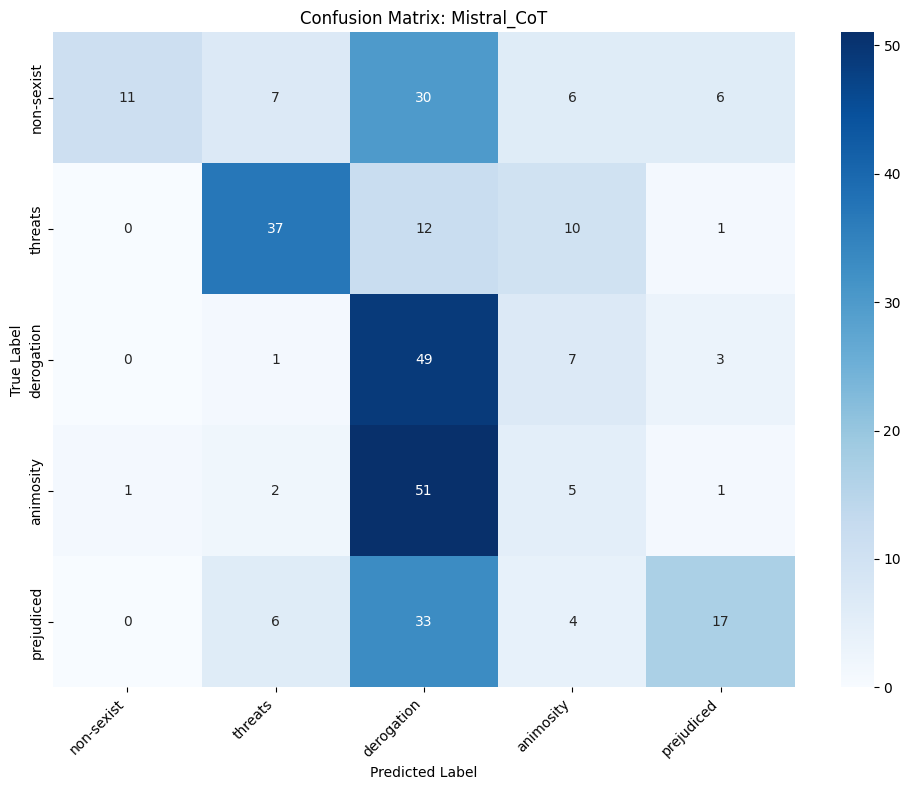


  Examples of: animosity → derogation

【Example 1】
  Text: "She wants you to go talk to her. Since you didn't - she thinks - either you didn't like her - or you..."
  True label: animosity
  Predicted: derogation
  Raw response: "REASONING: The text contains derogatory language towards a woman, specifically the use of the term "puss puss" which is often used in a derogatory manner to belittle or insult a person, especially a man, by implying they are weak or cowardly. The text also implies that the woman is judging the speaker based on their actions, which can be seen as a form of derogation.

CATEGORY: Derogation"

【Example 2】
  Text: "Yea they exposes closet faggots and faggots with aids and whores that fuck faggots! Edward Bernard P..."
  True label: animosity
  Predicted: derogation
  Raw response: "REASONING: The text uses derogatory slurs towards a man (faggot) and a woman (whore). It also implies the man has AIDS, which is a disease often stigmatized and used against men who ha

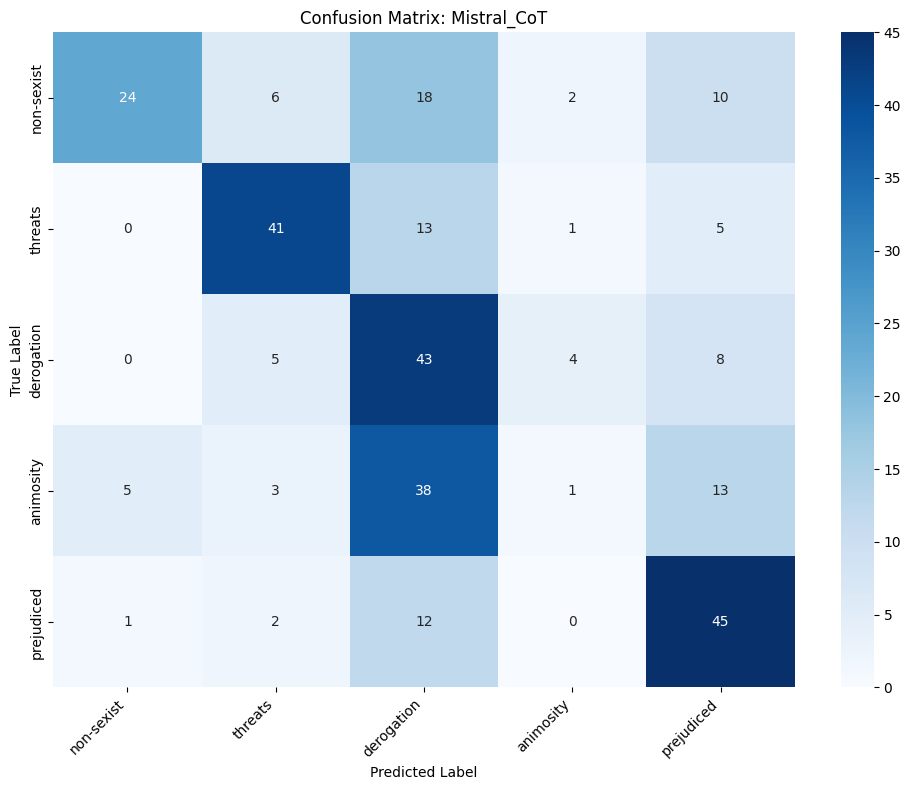


  Examples of: animosity → derogation

【Example 1】
  Text: "Yea they exposes closet faggots and faggots with aids and whores that fuck faggots! Edward Bernard P..."
  True label: animosity
  Predicted: derogation
  Raw response: "REASONING: The text uses derogatory slurs towards women (whores) and men (faggots). It also implies that women who do not want to have babies are a problem.
CATEGORY: Derogation"

【Example 2】
  Text: "Yeah some high ranking cunt periodically deletes perfectly well sourced entries. Her ~~sandbox~~ use..."
  True label: animosity
  Predicted: derogation
  Raw response: "REASONING: The text uses a derogatory term ("cunt") to refer to a woman, which fits the definition of derogation.
CATEGORY: Derogation"

【Example 3】
  Text: "And not imagine all those fans of Batchelorette. The packaged story that millions buy at zero though..."
  True label: animosity
  Predicted: derogation
  Raw response: "REASONING: The text implies a derogatory view of women, specifically r

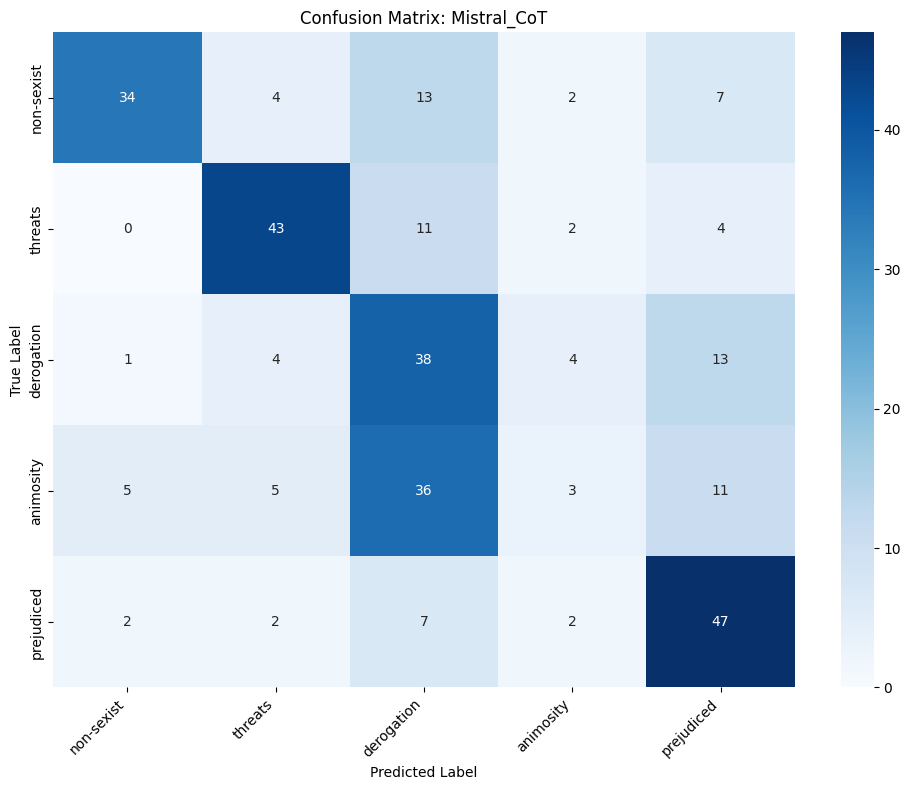


  Examples of: animosity → derogation

【Example 1】
  Text: "She wants you to go talk to her. Since you didn't - she thinks - either you didn't like her - or you..."
  True label: animosity
  Predicted: derogation
  Raw response: "ANALYSIS: The text implies that the speaker is making assumptions about the woman's feelings based on the man's actions, using derogatory language ("puss puss") to describe the man. This language is used in a derogatory manner towards men, not women, but it is still derogatory and disrespectful.

CATEGORY: Derogation"

【Example 2】
  Text: "Yea they exposes closet faggots and faggots with aids and whores that fuck faggots! Edward Bernard P..."
  True label: animosity
  Predicted: derogation
  Raw response: "REASONING: The text uses derogatory language towards individuals, specifically referring to people as "faggots" and "whores." It also implies that these individuals have HIV/AIDS, which is a health condition, not a character flaw or justification for deroga

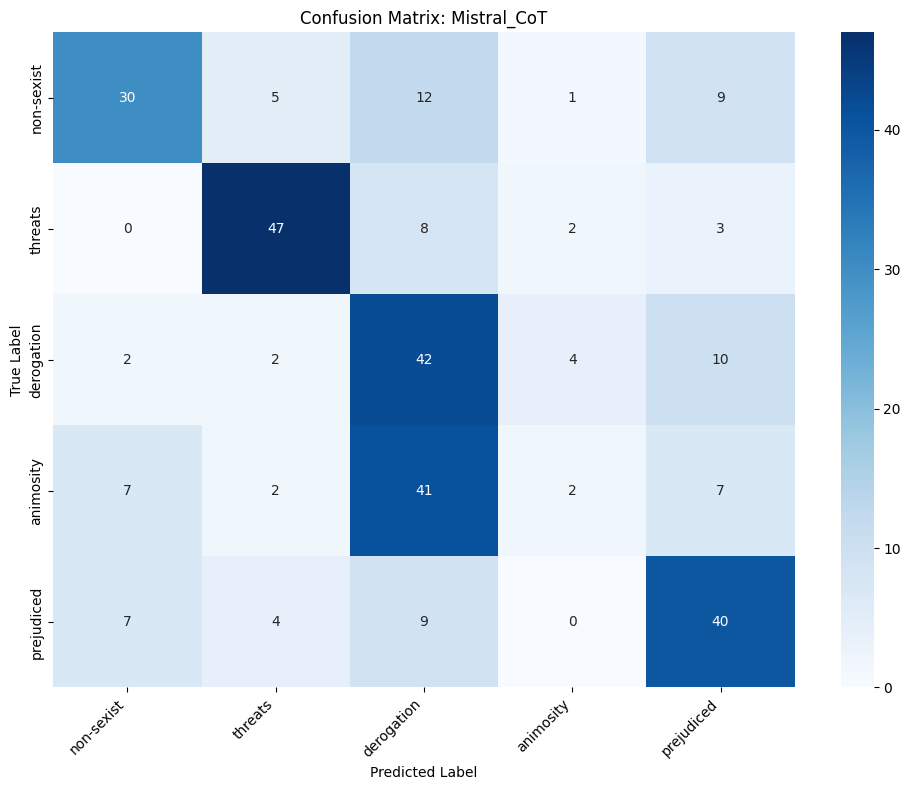


  Examples of: animosity → derogation

【Example 1】
  Text: "In my experience women don't recommend guys to their friends. If she doesn't want him then mostt lik..."
  True label: animosity
  Predicted: derogation
  Raw response: "ANALYSIS: The text suggests a generalization about all women, implying that they do not recommend men to their friends. This statement is based on the speaker's personal experience and is not specific to the individual being discussed, which can be seen as a derogatory stereotype.

CATEGORY: Derogation"

【Example 2】
  Text: "Yea they exposes closet faggots and faggots with aids and whores that fuck faggots! Edward Bernard P..."
  True label: animosity
  Predicted: derogation
  Raw response: "REASONING: The text uses derogatory language towards individuals, specifically referring to people as "faggots" and "whores." It also implies that these individuals have a sexually transmitted disease (AIDS).
CATEGORY: Derogation"

【Example 3】
  Text: "Yeah some high rank

In [55]:
print("Performance Table Mistral (CoT)")

results_df_cot = pd.read_csv('/content/drive/MyDrive/AssignmentsNLP/Assignment2/metrics/cot_metrics.csv')
with open('/content/drive/MyDrive/AssignmentsNLP/Assignment2/metrics/all_predictions_cot.pkl', 'rb') as f:
    all_predictions_m_cot = pickle.load(f)

print(results_df_cot)

# Adjust all_predictions_m_cot to match the expected keys ('zero_shot', 'few_shot_X')
# by the rebuild_full_structure function
all_predictions_for_rebuild = {}
for key, value in all_predictions_m_cot.items():
    if key == 'zero_shot_cot':
        all_predictions_for_rebuild['zero_shot'] = value
    elif key.startswith('few_shot_cot_'):
        num_examples = key.split('_')[-1]
        all_predictions_for_rebuild[f'few_shot_{num_examples}'] = value
    else:
        all_predictions_for_rebuild[key] = value # Fallback for any other unexpected keys

mistral_results_cot = rebuild_full_structure(
    model_name="Mistral_CoT",
    metrics_df=results_df_cot, # Corrected: use results_df_cot
    all_predictions=all_predictions_for_rebuild, # Use the adjusted dictionary
    texts=texts_to_classify,
    y_true=y_true
)


error_analyses_mistral_cot = comprehensive_error_analysis(mistral_results_cot)

### Prompt Tuning

In [ ]:
!pip install -q peft

In [ ]:
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer
)
from peft import (
    get_peft_model,
    PromptTuningConfig,
    TaskType,
    PromptTuningInit
)

# Config macros
model_name_or_path = model_mistral  # the best models
TRAIN_CSV = "/content/drive/MyDrive/AssignmentsNLP/Assignment2/data/demonstrations.csv"
TEST_CSV = "/content/drive/MyDrive/AssignmentsNLP/Assignment2/data/a2_test.csv"
OUTPUT_DIR = "/content/drive/MyDrive/AssignmentsNLP/Assignment2/mistral_soft_prompt"
SEED = 42
SAMPLE_TRAIN_SIZE = 1000
NUM_VIRTUAL_TOKENS = 20
MAX_INPUT_LENGTH = 256
MAX_STEPS = 300
BATCH_SIZE = 4
GRAD_ACCUM_STEPS = 8
LR = 3e-2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# Load data
train_df = pd.read_csv(TRAIN_CSV)
demonstrations_df = train_df[train_df['split'] == 'test']

if os.path.exists(TEST_CSV):
    test_df = pd.read_csv(TEST_CSV)
else:
    # small stratified-ish split: use tail as test
    test_df = train_df.sample(200, random_state=SEED)
    train_df = train_df.drop(test_df.index)

# Keep reproducibility
train_df = train_df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

tokenizer_mistral.padding_side = "right"


# Create prompts for train and test using prepare_prompts
texts_train = train_df['text'].astype(str).tolist()
texts_test = test_df['text'].astype(str).tolist()

prompts_train_full = prepare_prompts(texts_train, prompt, tokenizer_mistral)
prompts_test_full = prepare_prompts(texts_test, prompt, tokenizer_mistral)

# For speed during debugging, sample a subset of training prompts
if SAMPLE_TRAIN_SIZE and SAMPLE_TRAIN_SIZE < len(prompts_train_full):
    sampled_idx = np.random.default_rng(SEED).choice(len(prompts_train_full), SAMPLE_TRAIN_SIZE, replace=False)
    prompts_train = [prompts_train_full[i] for i in sampled_idx]
    train_labels_df = train_df.iloc[sampled_idx].reset_index(drop=True)
else:
    prompts_train = prompts_train_full
    train_labels_df = train_df.reset_index(drop=True)

In [ ]:
train_df.shape

(1000, 6)

In [ ]:
# Dataset creation: tokenize full prompt (input_text + label) and mask the instruction tokens in labels
def create_masked_dataset(prompts, labels, tokenizer, max_length=MAX_INPUT_LENGTH):
    records = []
    for i, prompt_text in enumerate(prompts):
        if prompt_text is None:
            continue
        # build the full string where label is appended after the instruction
        # The label in the train set is the target to be generated
        target_label = str(labels[i]).strip()
        full = prompt_text + " " + target_label + tokenizer.eos_token

        tokenized_full = tokenizer(
            full,
            truncation=True,
            max_length=max_length,
            padding="max_length"
        )
        # compute input_len (token length of prompt without the target label)
        input_only = prompt_text
        tokenized_input_only = tokenizer(
            input_only,
            truncation=True,
            max_length=max_length,
            padding="max_length"
        )
        input_len = len([tid for tid in tokenized_input_only['input_ids'] if tid != tokenizer.pad_token_id])

        labels_ids = tokenized_full["input_ids"].copy()
        # mask first input_len tokens → set to -100 so they don't contribute to loss
        # clip input_len to len(labels_ids)
        input_len_clipped = min(input_len, len(labels_ids))
        labels_ids[:input_len_clipped] = [-100] * input_len_clipped

        records.append({
            "input_ids": tokenized_full["input_ids"],
            "attention_mask": tokenized_full["attention_mask"],
            "labels": labels_ids
        })
    # Convert to HF Dataset
    ds = Dataset.from_list(records)
    return ds

In [ ]:
# Expected textual labels: 'non-sexist', 'threats', 'derogation', 'animosity', 'prejudiced'
train_labels_text = train_labels_df['label_category'].astype(str).tolist()
train_dataset = create_masked_dataset(prompts_train, train_labels_text, tokenizer_mistral, max_length=MAX_INPUT_LENGTH)
print("Train dataset size (examples):", len(train_dataset))

Train dataset size (examples): 1000


In [ ]:
# For test we will not create masked labels; we will use generation + process_response
prompts_test = prompts_test_full

# PEFT Prompt Tuning config and wrapping model
peft_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM,
    num_virtual_tokens=NUM_VIRTUAL_TOKENS,
    prompt_tuning_init=PromptTuningInit.TEXT,
    prompt_tuning_init_text="Classify the text into categories: non-sexist, threats, derogation, animosity, prejudiced. Answer:", # We initially also tried a simpler prompt but if not correctly guided the results were not good
    tokenizer_name_or_path="mistralai/Mistral-7B-Instruct-v0.3"
)

# Ensure embeddings require grads for soft-prompt learning (PEFT may require this helper)
try:
    model_mistral.enable_input_require_grads()
except Exception:
    # Fallback: enable grads on input embeddings
    model_mistral.get_input_embeddings().weight.requires_grad = True

model_peft = get_peft_model(model_mistral, peft_config)
model_peft.print_trainable_parameters()

trainable params: 81,920 || all params: 7,248,105,472 || trainable%: 0.0011


In [ ]:
# TrainingArguments & Trainer
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,
    learning_rate=LR,
    max_steps=MAX_STEPS,
    logging_steps=10,
    fp16=torch.cuda.is_available(),
    save_strategy="no",
    optim="paged_adamw_8bit" if torch.cuda.is_available() else "adamw_hf",
    report_to=[],  # disable wandb / other loggers
    seed=SEED,
    remove_unused_columns=False,
    lr_scheduler_type="constant_with_warmup",
    warmup_steps=30,
)

# Do not use DataCollatorForLanguageModeling here (we already prepared labels and masks)
trainer = Trainer(
    model=model_peft,
    args=training_args,
    train_dataset=train_dataset
)

In [ ]:
# Train
print("Starting Prompt Tuning...")
trainer.train()
print("Prompt tuning finished.")


Starting Prompt Tuning...


Step,Training Loss
10,5.972500
20,3.399800
30,0.296100
40,0.063900
50,0.060400
60,0.053900
70,0.052300
80,0.052700
90,0.053600
100,0.048300


Prompt tuning finished.


In [ ]:
# Save only PEFT adapters/soft-prompts
model_peft.save_pretrained(OUTPUT_DIR)
print(f"Saved prompt tuning artifacts to {OUTPUT_DIR}")

Saved prompt tuning artifacts to /content/drive/MyDrive/A2/mistral_soft_prompt


In [ ]:
tokenizer_mistral.padding_side = "left"

In [ ]:
# Inference utilities
def generate_with_peft(model, prompts, tokenizer, batch_size=8, max_new_tokens=10):
    model.eval()
    results = []
    device = next(model.parameters()).device

    for i in range(0, len(prompts), batch_size):
        batch = prompts[i:i+batch_size]
        # Filter None prompts
        batch = [p for p in batch if p is not None]
        if len(batch) == 0:
            continue
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_INPUT_LENGTH)
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )

        # extract generated portion by skipping the prefix length
        for j, out in enumerate(outputs):
            prefix_len = input_ids.shape[1]
            gen_ids = out[prefix_len:]
            decoded = tokenizer.decode(gen_ids, skip_special_tokens=True).strip()
            # sometimes model echoes prompt parts - clean spaces/newlines
            results.append(decoded)
    return results

In [ ]:
# Response processing + normalization
# Map textual canonical forms to numeric ids
CANONICAL_LABELS = {
    'non-sexist': 0,
    'threats': 1,
    'derogation': 2,
    'animosity': 3,
    'prejudiced': 4
}

# Provide synonyms/variants mapping for robustness
NORMALIZATION_MAP = {
    'not-sexist': 'non-sexist',
    'nons sexist': 'non-sexist',
    'nons-sexist': 'non-sexist',
    'non sexist': 'non-sexist',
    'nonsexist': 'non-sexist',
    'threat': 'threats',
    'threats': 'threats',
    'derogation': 'derogation',
    'derogative': 'derogation',
    'derogatory': 'derogation',
    'animosity': 'animosity',
    'animosities': 'animosity',
    'insult': 'animosity',
    'prejudiced': 'prejudiced',
    'prejudice': 'prejudiced',
    'prejudiced discussion': 'prejudiced'
}

In [ ]:
def process_response(response: str):
    if response is None:
        return -1
    s = response.strip().lower()
    s = re.sub(r'[^a-z\- ]', ' ', s)  # removing punctuation
    s = re.sub(r'\s+', ' ', s).strip() # unify spaces
    #s = s.replace(".", " ").replace(",", " ").replace("\n", " ").strip()
    # Try exact canonical match
    for k in CANONICAL_LABELS.keys():
        if k in s:
            return CANONICAL_LABELS[k]
    # Try normalization variants (substring)
    for k, canon in NORMALIZATION_MAP.items():
        if k in s:
            return CANONICAL_LABELS[canon]
    # If the model prints e.g. "Label: non-sexist", handle that
    for token in s.split():
        token = token.strip()
        if token in CANONICAL_LABELS:
            return CANONICAL_LABELS[token]
        if token in NORMALIZATION_MAP:
            return CANONICAL_LABELS[NORMALIZATION_MAP[token]]
    # Not parsable
    return -1

In [ ]:
results_peft = []
all_predictions_peft = {}


# Run inference on test set and compute metrics (with compute_metrics)
print("Generating on test prompts...")
raw_preds = generate_with_peft(
    model_peft,
    prompts_test,
    tokenizer_mistral,
    batch_size=8,
    max_new_tokens=8
)
print("Raw model outputs (excerpt):", raw_preds)

Generating on test prompts...


/usr/local/lib/python3.12/dist-packages/peft/peft_model.py:2141: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")


Raw model outputs (excerpt): ['prejudiced', 'prejudiced', ': derogation', 'prejudiced', 'prejudiced', 'prejudiced', 'animosity', 'prejudiced', 'prejudiced', 'not-sexist', 'SWER: prejudiced', '.\n        non-sexist', 'prejudiced', 'derogation', 'derogation', 'derogation', 'not-sexist', 'SWER: prejudiced', 'prejudiced', 'prejudiced', 'threats', 'prejudiced', 'prejudiced', 'derogation', 'derogation', 'not-sexist', 'derogation', 'prejudiced', 'ER: threats', 'not-sexist', 'not-sexist', 'not-sexist', 'not-sexist', 'prejudiced', 'not-sexist', 'derogation', 'prejudiced', 'ANSWER: threats', 'derogation', 'not-sexist', 'not-sexist', 'not-sexist', 'prejudiced', 'not-sexist', 'prejudiced', 'derogation', 'not-sexist', 'not-sexist', 'derogation', 'prejudiced', 'Melania Trump is a woman we know', 'not-sexist', 'not-sexist', 'prejudiced', 'animosity', 'not-sexist', 'animosity', 'not-sexist', 'not-sexist', 'derogation', 'not-sexist', 'derogation', 'threats', 'derogation', 'not-sexist', 'prejudiced', 'n

In [ ]:
# Parse responses
parsed_preds = [process_response(r) for r in raw_preds]

# Save the dictionary
all_predictions_peft[f"peft_zero_shot"] = {
    "raw": raw_preds,
    "numeric": parsed_preds
}
print("Parsed predictions (excerpt):", parsed_preds)

Parsed predictions (excerpt): [4, 4, 2, 4, 4, 4, 3, 4, 4, 0, 4, 0, 4, 2, 2, 2, 0, 4, 4, 4, 1, 4, 4, 2, 2, 0, 2, 4, 1, 0, 0, 0, 0, 4, 0, 2, 4, 1, 2, 0, 0, 0, 4, 0, 4, 2, 0, 0, 2, 4, -1, 0, 0, 4, 3, 0, 3, 0, 0, 2, 0, 2, 1, 2, 0, 4, 0, 1, 1, 3, 4, 1, 2, 4, 0, 2, -1, 3, 2, 2, 2, 1, 0, 4, 4, 2, 2, 2, 0, 4, 4, 1, 1, 4, 0, 0, 0, 2, 4, 4, 2, 2, 4, 1, 4, 2, 0, 0, 3, 1, -1, 4, 4, 4, 3, 4, 4, 0, 2, 2, 2, 4, 0, 2, 3, 4, -1, 3, 2, 1, 0, 2, 2, 1, 0, 4, 2, 1, 2, 0, 4, 2, 4, 1, 2, 0, 0, 1, 1, 0, 0, 4, 3, 0, 4, 1, 0, 2, 1, 2, 4, 0, 0, 4, 2, 4, 1, 0, 1, 4, 4, 2, 1, 3, 3, 2, 4, -1, 3, 4, 2, 0, 1, 0, 0, 2, 2, 4, 2, 1, 1, 0, 4, 4, 1, -1, 4, 3, 0, 4, 0, 0, 1, 0, 4, 2, 1, 0, 4, 1, 1, 4, 0, 0, 0, 4, 4, 2, -1, 2, 0, 2, 4, 0, 2, 1, 3, 1, 1, 4, 4, -1, 2, 2, 2, 0, 4, 2, 1, 1, 4, 4, 1, 4, 3, 2, 0, 0, 3, 1, 2, 3, 0, 4, 2, 4, 3, 0, 0, 0, 0, 0, 1, 2, 2, 4, 1, 4, 1, 4, 3, 2, 2, 1, 4, 1, 3, 2, 4, 1, 1, 1, 0, 0, 4, 4, 0, 4, 1, 1, 4, 4, 1, 2, 2, 2, 3, 4, 2, 3]


In [ ]:
# Ground truth numeric
LABEL_MAP = {
    'non-sexist': 0,
    'threats': 1,
    'derogation': 2,
    'animosity': 3,
    'prejudiced': 4
}
y_true_text = test_df['label_category'].astype(str).tolist()
y_true = [LABEL_MAP.get(lbl.strip(), 0) for lbl in y_true_text]
print(y_true)

[2, 4, 2, 4, 4, 4, 3, 4, 3, 0, 4, 4, 4, 2, 2, 2, 0, 4, 4, 4, 1, 0, 2, 2, 2, 0, 4, 4, 1, 0, 0, 0, 0, 2, 0, 2, 4, 1, 3, 0, 2, 3, 4, 0, 4, 0, 3, 0, 3, 4, 0, 0, 4, 0, 0, 1, 2, 0, 0, 2, 1, 2, 1, 3, 0, 4, 2, 1, 1, 3, 4, 1, 2, 4, 0, 3, 3, 2, 2, 2, 2, 1, 3, 4, 4, 2, 3, 2, 0, 2, 0, 1, 4, 4, 0, 0, 2, 2, 3, 4, 3, 2, 2, 3, 3, 0, 0, 0, 3, 1, 0, 4, 2, 3, 1, 1, 4, 1, 2, 3, 2, 4, 1, 3, 4, 3, 3, 1, 3, 1, 0, 3, 3, 1, 3, 4, 2, 1, 2, 4, 4, 2, 4, 1, 3, 0, 0, 1, 1, 3, 0, 3, 3, 0, 4, 1, 0, 4, 1, 2, 4, 0, 0, 3, 3, 4, 1, 2, 3, 4, 3, 3, 2, 0, 2, 3, 4, 2, 3, 4, 2, 0, 1, 1, 0, 3, 2, 4, 3, 1, 1, 4, 3, 2, 1, 2, 3, 3, 0, 3, 1, 0, 1, 2, 4, 3, 1, 1, 0, 1, 1, 4, 0, 1, 0, 1, 4, 2, 1, 2, 4, 3, 2, 0, 4, 1, 1, 1, 0, 4, 3, 3, 3, 2, 2, 3, 4, 3, 1, 1, 2, 1, 1, 3, 2, 2, 0, 0, 3, 1, 3, 3, 2, 4, 2, 4, 0, 0, 0, 0, 0, 0, 1, 3, 3, 4, 1, 2, 1, 3, 0, 2, 3, 0, 4, 1, 3, 3, 2, 1, 1, 1, 0, 0, 1, 4, 0, 4, 1, 1, 4, 4, 1, 1, 2, 4, 2, 4, 2, 2]


In [ ]:
# Use compute_metrics
metrics = compute_metrics(parsed_preds, y_true)
results_peft.append({
        "Model": "Mistral-7B + PEFT",
        "num_examples_per_class": 0,
        "macro_f1": metrics["macro_f1"],
        "fail_ratio": metrics['fail_ratio'],
    })

macro_f1 = metrics["macro_f1"]
fail_ratio = metrics["fail_ratio"]
#y_pred_for_metrics = metrics["clean_pred"]

print("\n--- RESULTS (Prompt Tuning, no Few-Shot) ---")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Fail ratio: {fail_ratio:.4f}")



--- RESULTS (Prompt Tuning, no Few-Shot) ---
Macro F1: 0.5844
Fail ratio: 0.0267


In [ ]:
# Save metrics
results_peft_df = pd.DataFrame(results_peft)
results_peft_df.to_csv('/content/drive/MyDrive/AssignmentsNLP/Assignment2/peft_metrics.csv', index=False)

#print("\nSaved metrics CSV to:", os.path.join(SAVE_DIR, "peft_metrics.csv"))
print(results_peft_df)

# Save predictions on pickle
with open('/content/drive/MyDrive/AssignmentsNLP/Assignment2/metrics/all_predictions_peft.pkl', 'wb') as f:
    pickle.dump(all_predictions_peft, f)

               Model  num_examples_per_class  macro_f1  fail_ratio
0  Mistral-7B + PEFT                       0  0.584416    0.026667


Performance Table Mistral (Prompt Tuning)
               Model  num_examples_per_class  macro_f1  fail_ratio
0  Mistral-7B + PEFT                       0  0.584416    0.026667

################################################################################
  COMPREHENSIVE ERROR ANALYSIS
################################################################################

  ERROR ANALYSIS: Mistral_Prompt_Tuning (examples_per_class=0)

Overall Statistics:
  Total samples: 300
  Valid predictions: 292
  Correct predictions: 181
  Errors: 111
  Failed parses: 8
  Accuracy: 61.99%
  Error rate: 38.01%
  Fail rate: 2.67%

Error Types (Top 10):
   1. animosity → derogation                     26 ( 23.4%)
   2. animosity → prejudiced                     14 ( 12.6%)
   3. derogation → prejudiced                    11 (  9.9%)
   4. threats → non-sexist                        8 (  7.2%)
   5. derogation → non-sexist                     6 (  5.4%)
   6. animosity → non-sexist                      6 

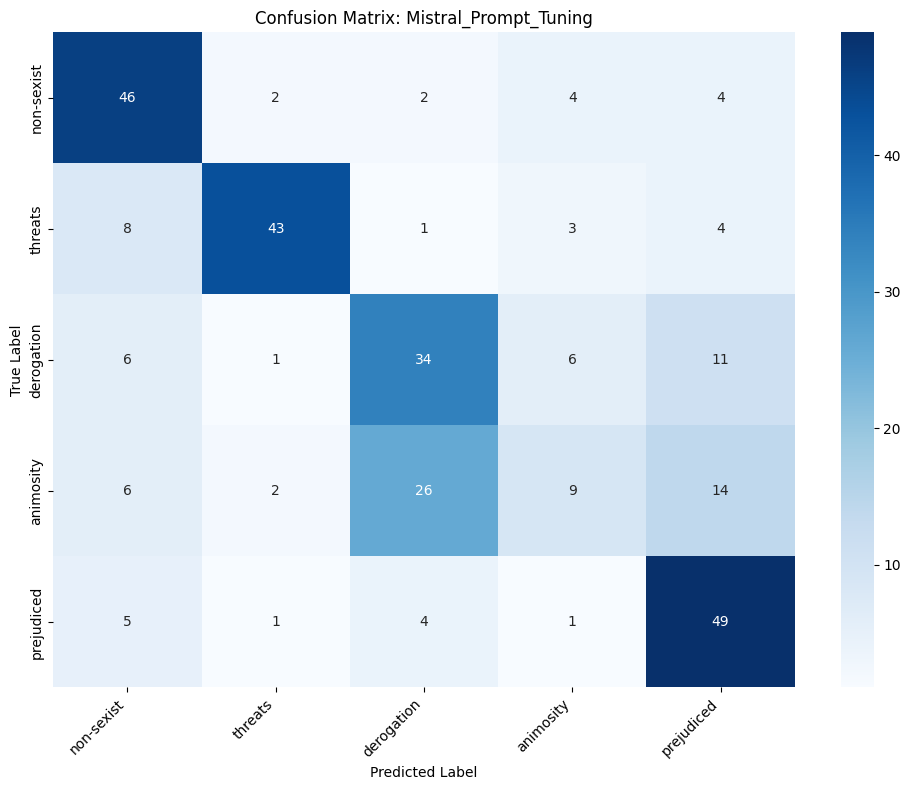


  Examples of: animosity → derogation

【Example 1】
  Text: "Yea they exposes closet faggots and faggots with aids and whores that fuck faggots! Edward Bernard P..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

【Example 2】
  Text: "And not imagine all those fans of Batchelorette. The packaged story that millions buy at zero though..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

【Example 3】
  Text: "Women aren't renown for originality in general. Feminism is just female nagging and mind games with ..."
  True label: animosity
  Predicted: derogation
  Raw response: "derogation"

  FAILED PARSE EXAMPLES

【Failed Parse 1】
  Text: "that's NOT the Mr.McMahon THAT WE KNOW. GET UP STAND UP FIGHT BACK! THIS MESSAGE COMES DIRECTLY FROM..."
  True label: non-sexist
  Raw response: "Melania Trump is a woman we know"

【Failed Parse 2】
  Text: "Yeah, he makes a 6 figure salary and she has this grand "plan" for him, he pussy blind en

In [47]:
print("Performance Table Mistral (Prompt Tuning)")

results_df_m = pd.read_csv('/content/drive/MyDrive/A2/metrics/peft_metrics.csv')
with open('/content/drive/MyDrive/A2/metrics/all_predictions_peft.pkl', 'rb') as f:
    all_predictions_m = pickle.load(f)

print(results_df_m)

# Adjust all_predictions_m to match the expected key 'zero_shot'
# by the rebuild_full_structure function for PEFT zero-shot
all_predictions_for_rebuild = {}
if 'peft_zero_shot' in all_predictions_m:
    all_predictions_for_rebuild['zero_shot'] = all_predictions_m['peft_zero_shot']
else:
    all_predictions_for_rebuild = all_predictions_m # Fallback if key name is already 'zero_shot' or different context

mistral_results = rebuild_full_structure(
    model_name="Mistral_Prompt_Tuning",
    metrics_df=results_df_m,
    all_predictions=all_predictions_for_rebuild, # Use the adjusted dictionary
    texts=texts_to_classify,
    y_true=y_true
)


error_analyses_mistral = comprehensive_error_analysis(mistral_results)

# FAQ

Please check this frequently asked questions before contacting us.

### Model cards

You can pick any open-source model card you like.

We recommend starting from those reported in this assignment.

### Implementation

Everything can be done via ``transformers`` APIs.

However, you are free to test frameworks, such as [LangChain](https://www.langchain.com/), [LlamaIndex](https://www.llamaindex.ai/) [LitParrot](https://github.com/awesome-software/lit-parrot), provided that you correctly address task instructions.

### Task Performance

The task is challenging and zero-shot prompting may show relatively low performance depending on the chosen model.

### Prompt Template

Do not change the provided prompt template.

You are only allowed to change it in case of a possible extension.

### Optimizations

Any kind of code optimization (e.g., speedup model inference or reduce computational cost) is more than welcome!

### Bonus Points

0.5 bonus points are arbitrarily assigned based on significant contributions such as:

- Outstanding error analysis
- Masterclass code organization
- Evaluate A1 dataset and perform comparison
- Perform prompt tuning

Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

# The End